In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [38]:
# load the image files
bead_date =20200930
bead_number = 1
dataset = "/Shaking/Shaking345/"
FOI = "NoShakingNoSpin1"
filename = "/data/new_trap/" + str(bead_date) + "/Bead%s/" %bead_number +dataset + "Pictures_0/" + FOI
data = load_npy_files(path=filename+"*",max_files=10000)

/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_0.npy 0
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_1.npy 1
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_2.npy 2
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_3.npy 3
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_4.npy 4
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_5.npy 5
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_6.npy 6
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_7.npy 7
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_8.npy 8
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_9.npy 9
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pictures_0/NoShakingNoSpin1_10.npy 10
/data/new_trap/20200930/Bead1//Shaking/Shaking345/Pi

In [39]:
pixel_size_cal = 0.512 # obtained from attractor calibration data February2020, but cross checked during Wilson itself
attractor_0 = 241 # 0 position of attractor as extrapolated from image analysis of z=50 and z=27. Obtained from Wilson attractor screening.

(650.0, 720.0)

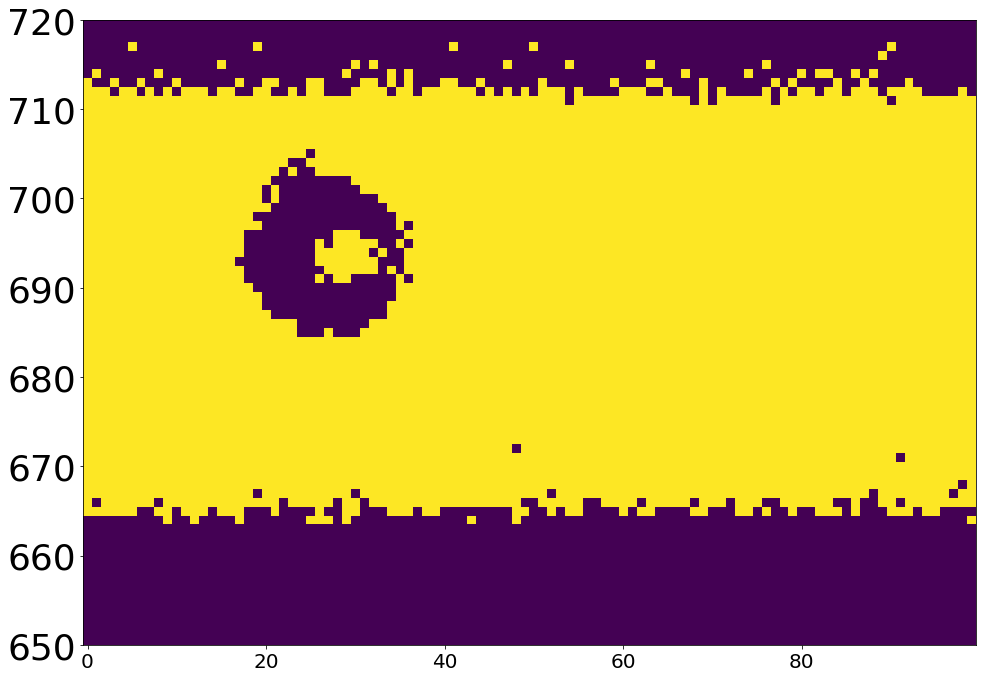

In [65]:
ret,thresh = cv2.threshold(data[-1],145,255,0)
plt.imshow(thresh[::,600:700])
plt.ylim(650,720)

In [41]:
def from_shadow_image_to_height(image,threshold,area_low_limits=[670,730],area_widths=[40,70],flb=460,fub=510,area_max=3000,width_max=7,plot=False):
    thresh = threshold_image(image.copy(),threshold,256)
    img = thresh.transpose()
    z1 = np.mean(img[area_low_limits[0]:area_low_limits[0]+area_widths[0]],axis=0)
    z2 = np.mean(img[area_low_limits[1]:area_low_limits[1]+area_widths[1]],axis=0)
    fit_img = z1-z2
    m = gaussian_fit_shadow_height(fit_img,low_y_lim=flb,up_y_lim=fub,upper_area=area_max,up_lim_width=width_max,img_type="Diff_Projection",)   
    if(plot==True):
        plt.plot(fit_img)
        plt.plot(range(1024),gaussian(range(1024),params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]),label="fit")
        plt.xlim(m.values["mean"]-100,m.values["mean"]+100)
    # height =  pixel_to_height(m.values["mean"],calibration=calibration)        
    return m.values["mean"],m # in pixels


In [42]:
def imp_from_shadow_image_to_height(image,threshold,area_low_limits=[670,730],area_widths=[40,70],flb=460,fub=510,area_max=3000,width_max=5,plot=False):
    thresh = threshold_image(image.copy(),threshold,256)
    img = thresh.transpose()
    z1 = np.mean(img[area_low_limits[0]:area_low_limits[0]+area_widths[0]],axis=0)
    z2 = np.mean(img[area_low_limits[1]:area_low_limits[1]+area_widths[1]],axis=0)
    fit_img_raw = z1-z2
    fit_img = []
    for elements in fit_img_raw: 
        if(elements<0): value=elements 
        else: value=0
        fit_img.append(value)
    m = gaussian_fit_shadow_height(fit_img,low_y_lim=flb,up_y_lim=fub,upper_area=area_max,up_lim_width=width_max,img_type="Diff_Projection",)   
    if(plot==True):
        plt.plot(fit_img)
        plt.plot(range(1024),gaussian(range(1024),params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]),label="fit")
        plt.xlim(m.values["mean"]-100,m.values["mean"]+100)
    # height =  pixel_to_height(m.values["mean"],calibration=calibration)        
    return m.values["mean"],m # in pixels


In [52]:
def gaussian_fit_shadow_height(img,low_x_lim=670,up_x_lim=710,low_y_lim=400,up_y_lim=750,upper_area=3000,up_lim_width=7,img_type="Image"):    
    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevalue, ndf)    
    def chisquare_gaussian(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
        
    fit_range_low = low_y_lim
    fit_range_high = up_y_lim
        
    if(img_type=="Image"):
        img2 = img.transpose()
        data_x = np.arange(fit_range_low,fit_range_high,1)
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0)[fit_range_low:fit_range_high] # give y data 
        constant=255
    if(img_type=="Projection"): 
        data_x = np.arange(fit_range_low,fit_range_high,1)
        data_y = img[fit_range_low:fit_range_high]
        constant=255
    if(img_type=="Diff_Projection"): 
        data_x = range(len(img)) # give x data
        data_y = img
        constant = 0
        

    data_y_error = np.sqrt(np.abs(data_y))+1 # give y uncertainty
    low_lim_mean = low_y_lim
    up_lim_mean = up_y_lim

    m=Minuit(chisquare_gaussian, 
             area = -1000, # set start parameter
             error_area = 1,
             limit_area= (-upper_area,0), # if you want to limit things
             #fix_area = "False", # you can also fix it
             mean = (low_y_lim+up_y_lim)/2,
             error_mean = 1,
             #fix_mean = "True",
             limit_mean = (low_lim_mean,up_lim_mean),
             sigma = 4,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant = constant,
             error_constant = 1,
             fix_constant="True",
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    #print(np.median(data_y))
    return m



In [56]:
height = [] # get the height using the shadow method
for i in tqdm(np.arange(0,len(data),1)):
    mean, m = from_shadow_image_to_height(data[i],145,area_low_limits=[600,530],area_widths=[45,70],flb=650,fub=725,plot=False)
    height.append(pixel_to_height(mean,calibration=True,pix_size_from_calib=pixel_size_cal))
    print(m.values["mean"])
    plt.show()

 27%|██▋       | 13/48 [00:00<00:00, 58.85it/s]

684.6474147887037
685.327991609625
684.3557297016667
684.2579956943771
684.4501642588688
685.0324491623434
684.2970211774907
684.660013199692
685.3297603120062
686.1373134475787
686.6178992181125
686.6604750057542
687.0909957532151


 44%|████▍     | 21/48 [00:00<00:00, 63.24it/s]

687.1941708330403
686.9235714329756
687.3646842926925
688.4549296732159
688.1273204566905
688.1468372401334
688.6920771776274
688.8510280989257
688.9430342202975
689.1727012487997
689.9272456929729
689.5515610015036
689.6029918489792
690.0508713593562


 71%|███████   | 34/48 [00:00<00:00, 59.87it/s]

690.3821186763688
690.52964573938
690.0530390390666
690.4998253985815
690.6383269933378
690.7101642194972
691.0261972037243
691.1083939514356
691.0304274973762
691.1106387821267
691.487294508179


 94%|█████████▍| 45/48 [00:00<00:00, 51.50it/s]

692.5701667038202
692.3929839332675
692.6337724659874
692.4745957461246
692.5298528785607
692.5328808891396
693.0705245345238
692.484482246088
693.0992234228555


100%|██████████| 48/48 [00:00<00:00, 55.84it/s]

694.7598655587069


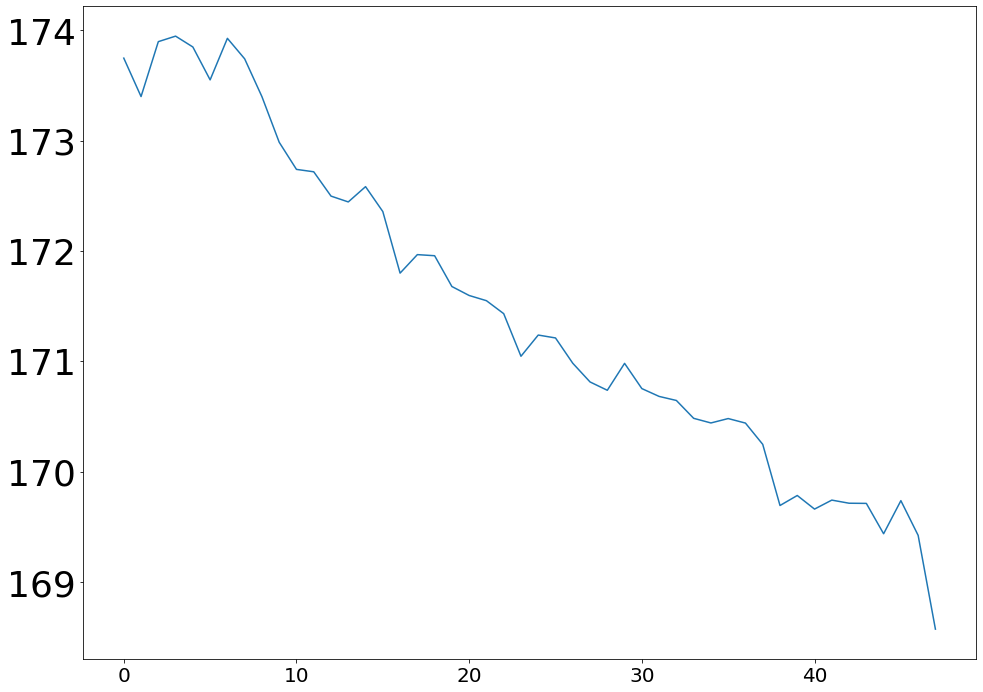

In [57]:
plt.plot(height)

In [20]:
folder = "/data/new_trap/" + str(bead_date) + "/Bead%s/" %bead_number +dataset 

height_list = load_dir_reduced_to_height(folder,FOI,1000)


100%|██████████| 10/10 [01:31<00:00,  8.99s/it]

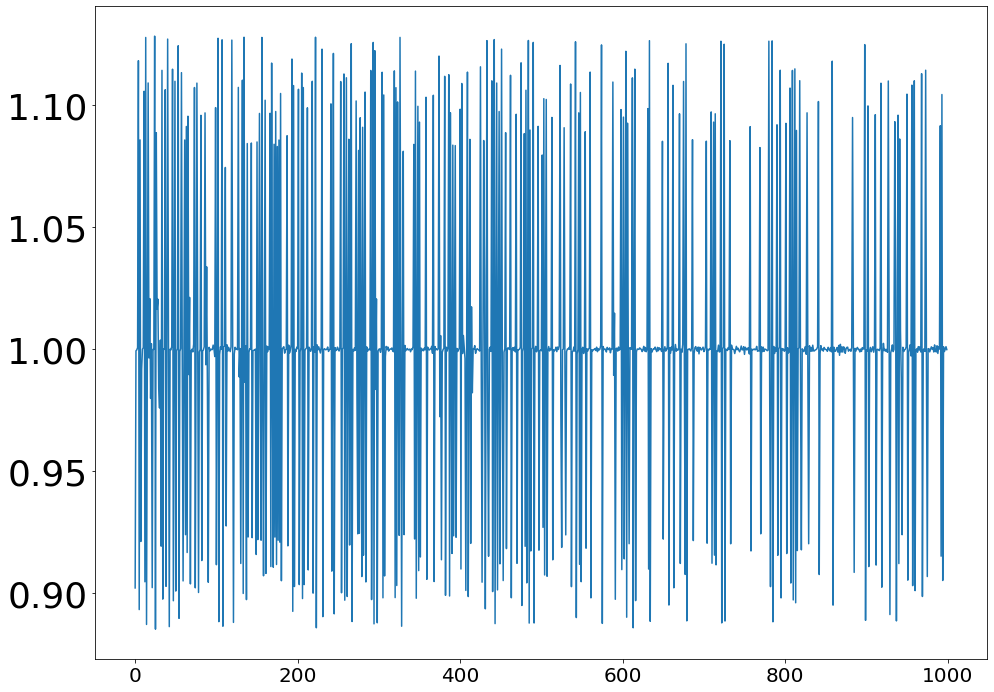

In [38]:
plt.plot(np.divide(height_list,height))

  0%|          | 0/213 [00:00<?, ?it/s]

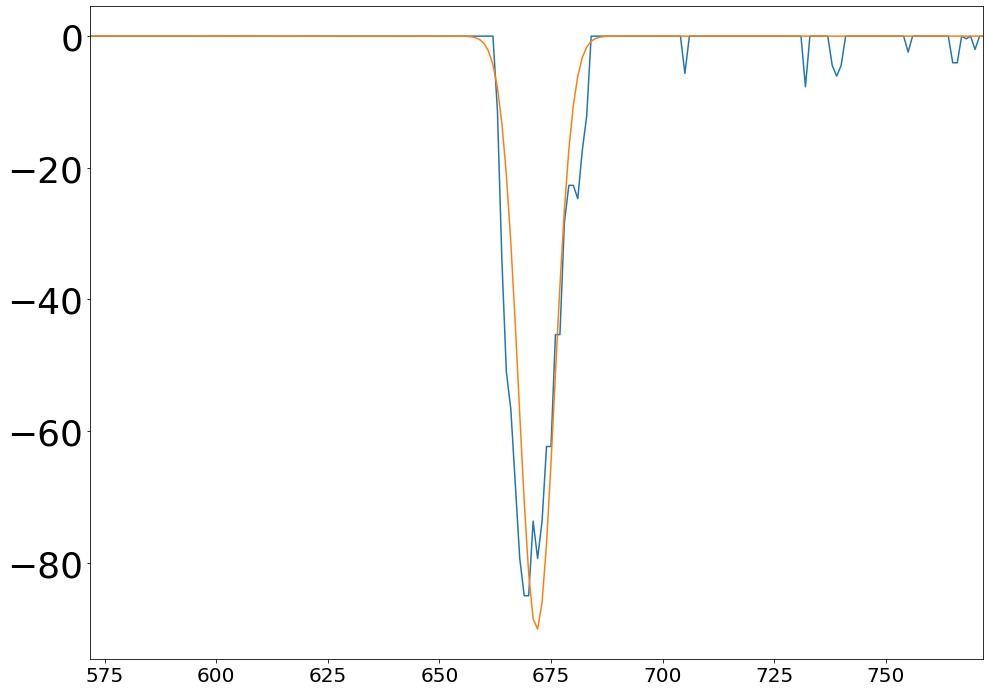

  0%|          | 1/213 [00:00<00:32,  6.60it/s]

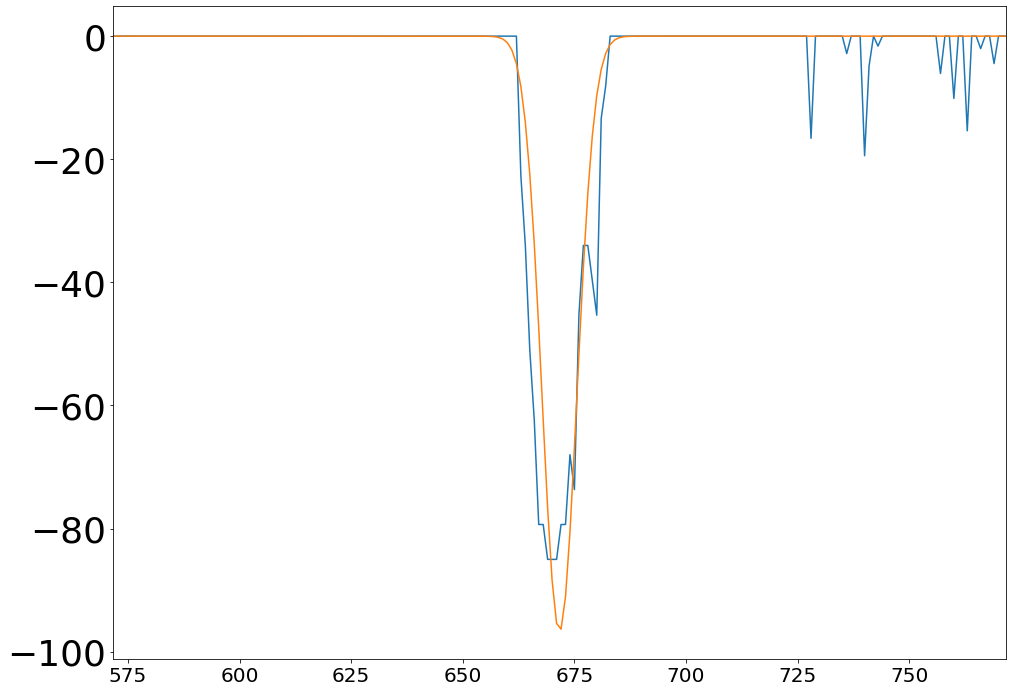

  1%|          | 2/213 [00:00<00:32,  6.51it/s]

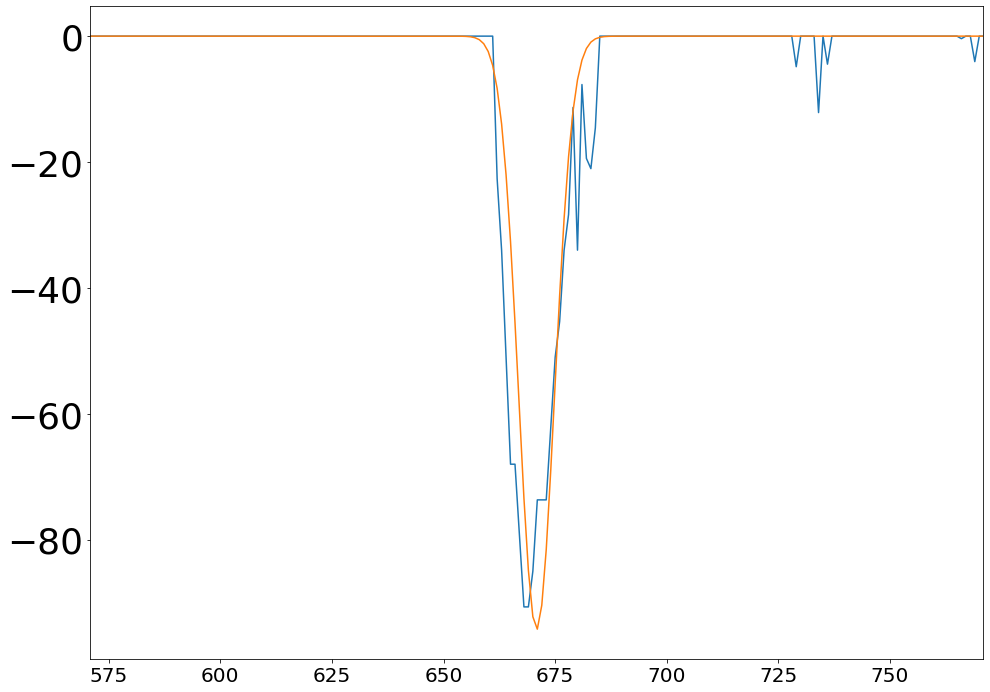

  1%|▏         | 3/213 [00:00<00:31,  6.59it/s]

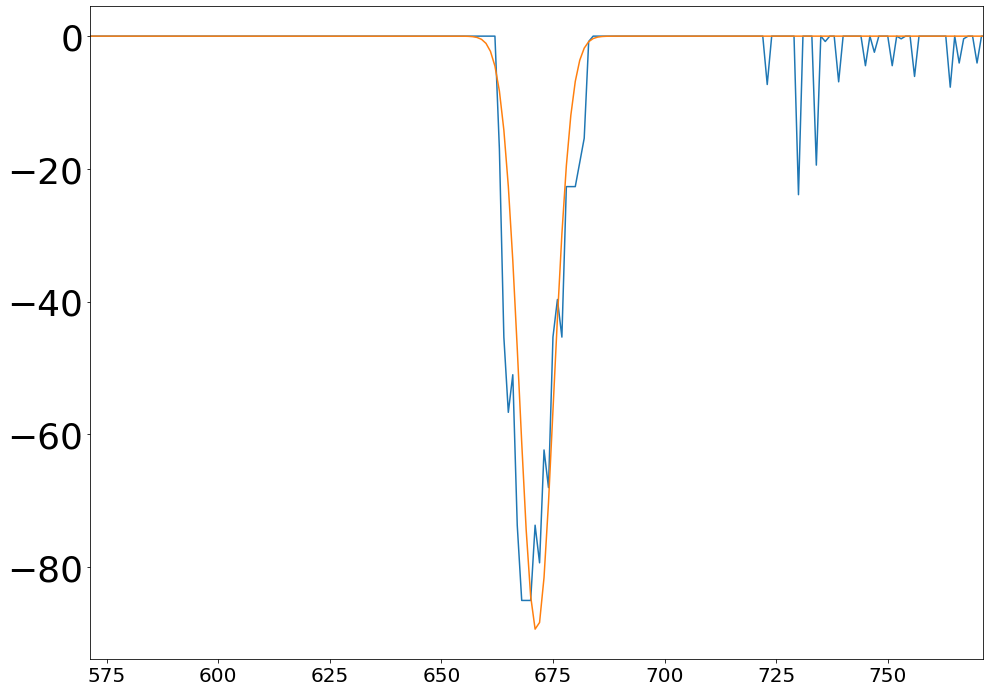

  2%|▏         | 4/213 [00:00<00:31,  6.67it/s]

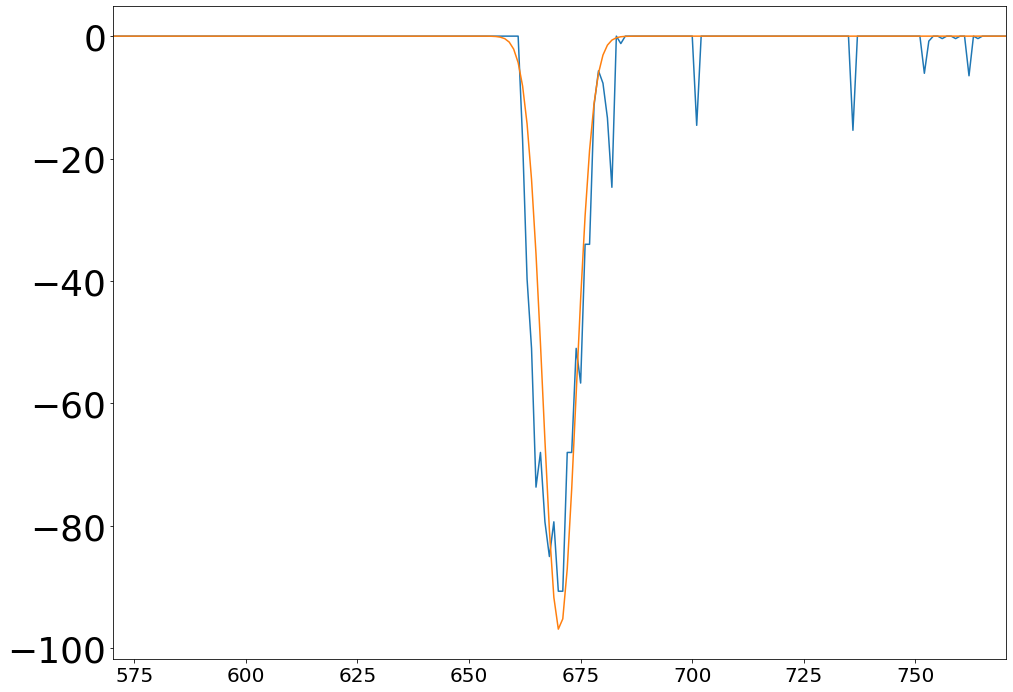

  2%|▏         | 5/213 [00:00<00:31,  6.70it/s]

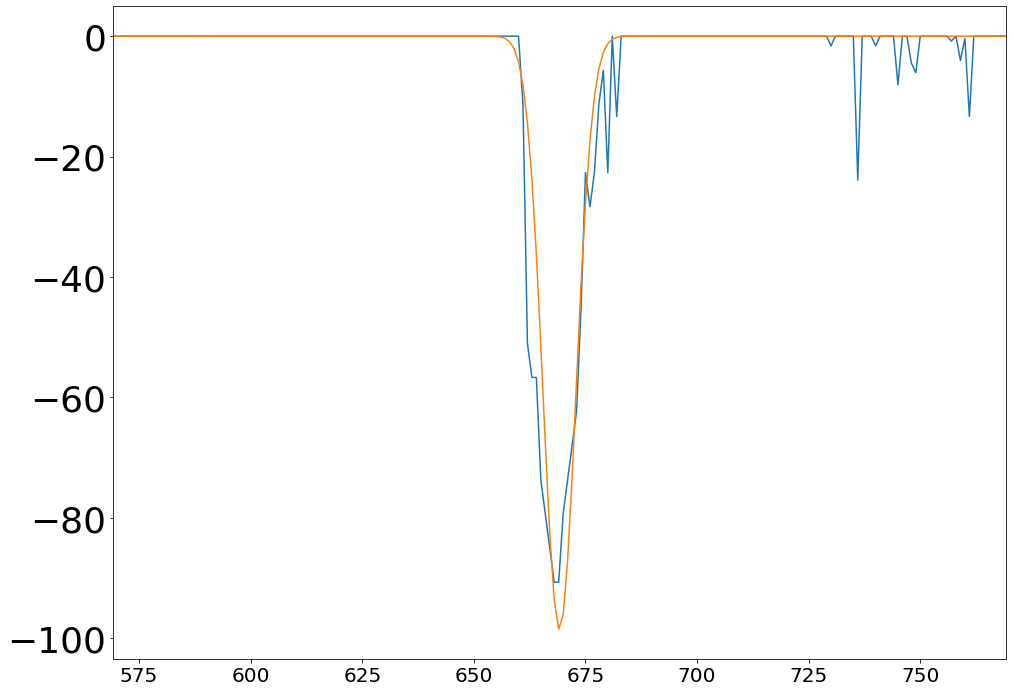

  3%|▎         | 6/213 [00:00<00:31,  6.54it/s]

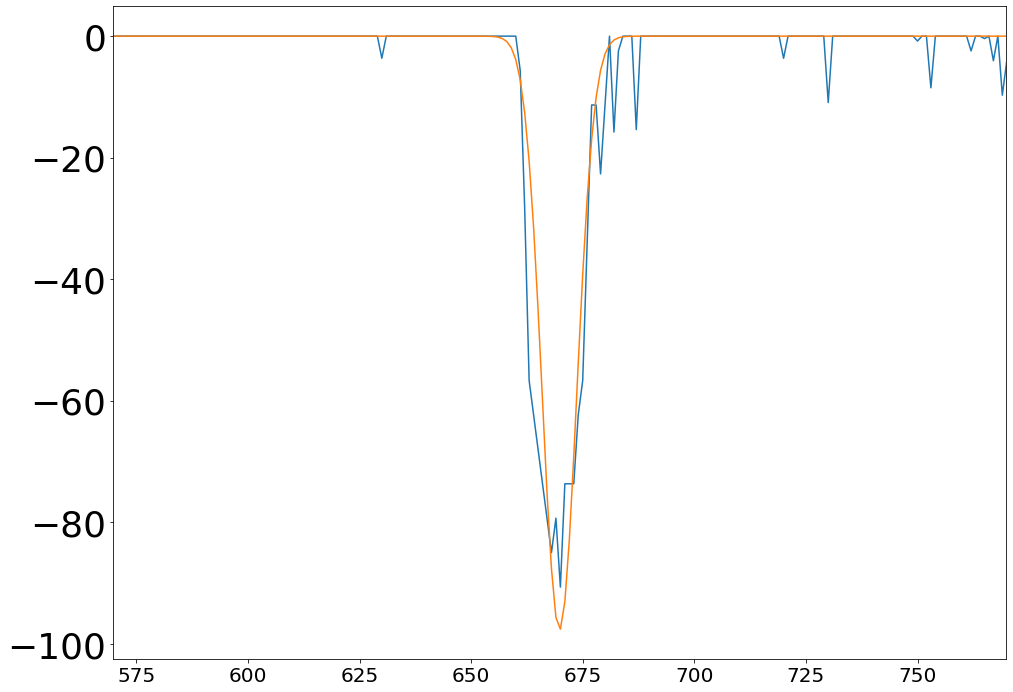

  3%|▎         | 7/213 [00:01<00:31,  6.49it/s]

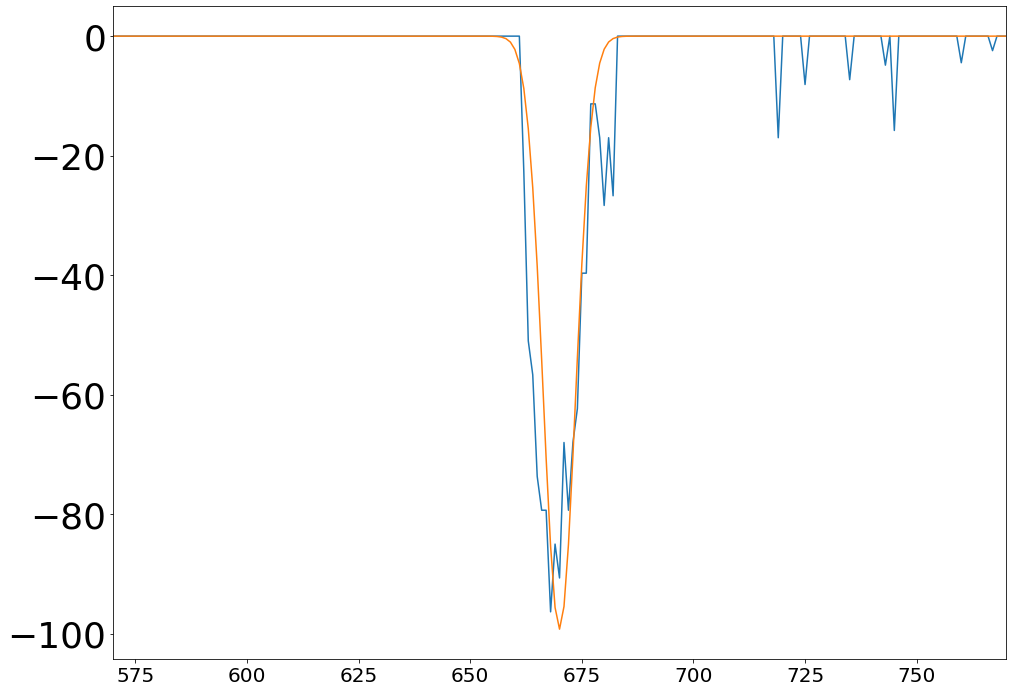

  4%|▍         | 8/213 [00:01<00:31,  6.45it/s]

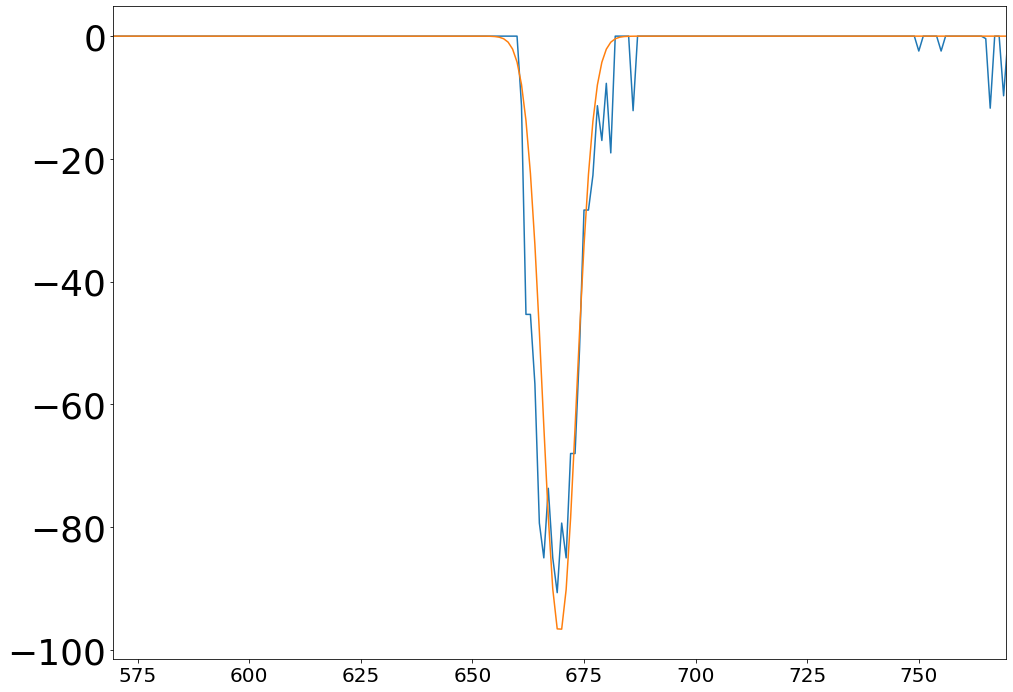

  4%|▍         | 9/213 [00:01<00:31,  6.39it/s]

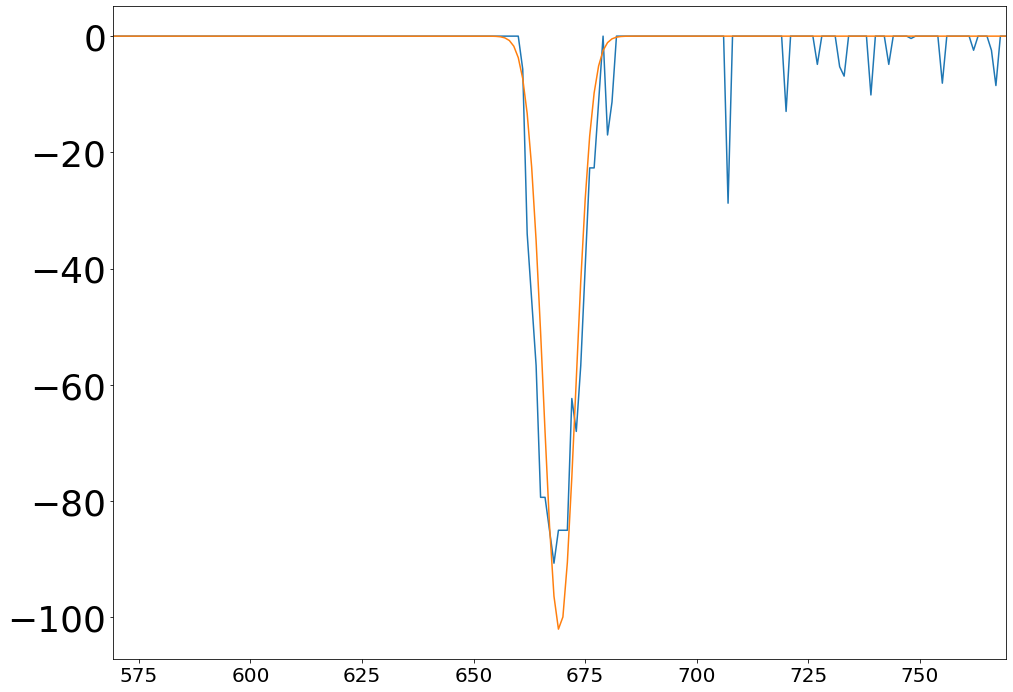

  5%|▍         | 10/213 [00:01<00:32,  6.25it/s]

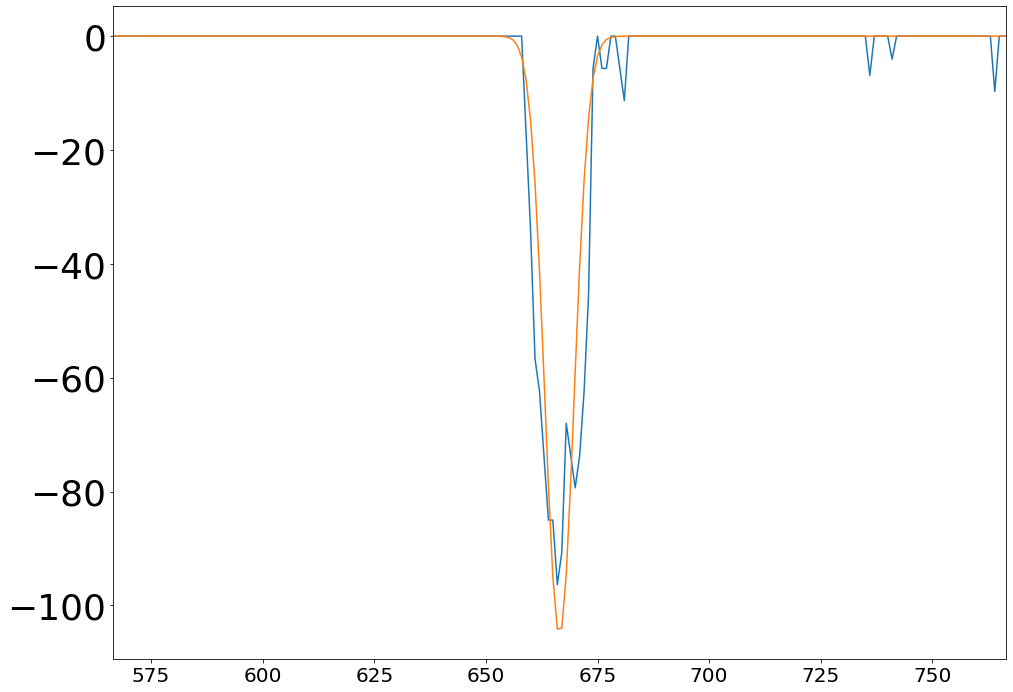

  5%|▌         | 11/213 [00:01<00:32,  6.30it/s]

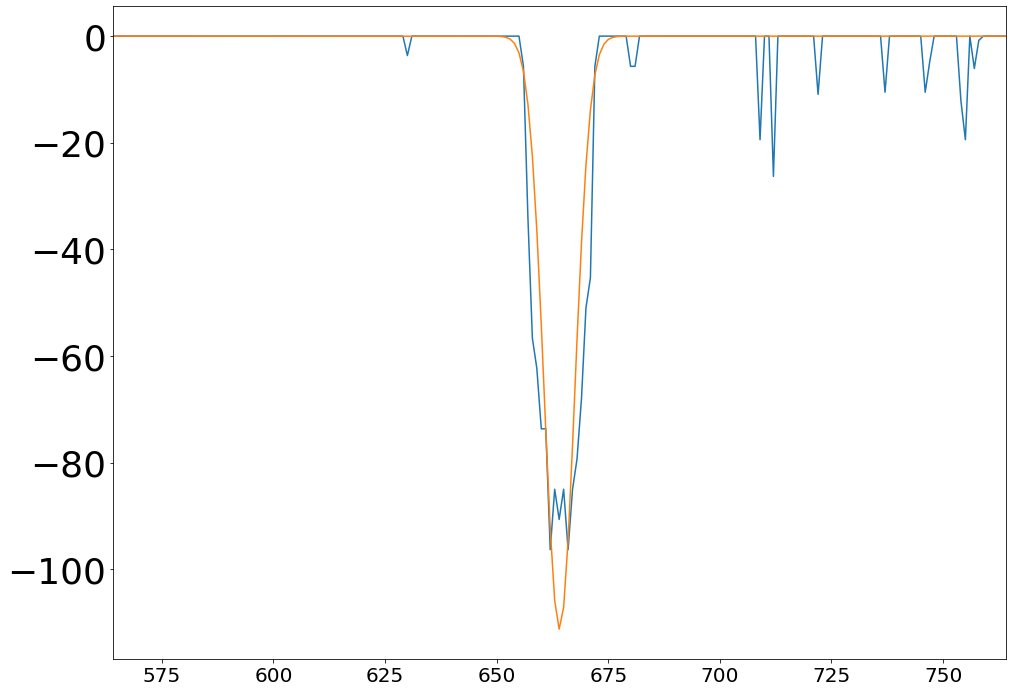

  6%|▌         | 12/213 [00:01<00:31,  6.38it/s]

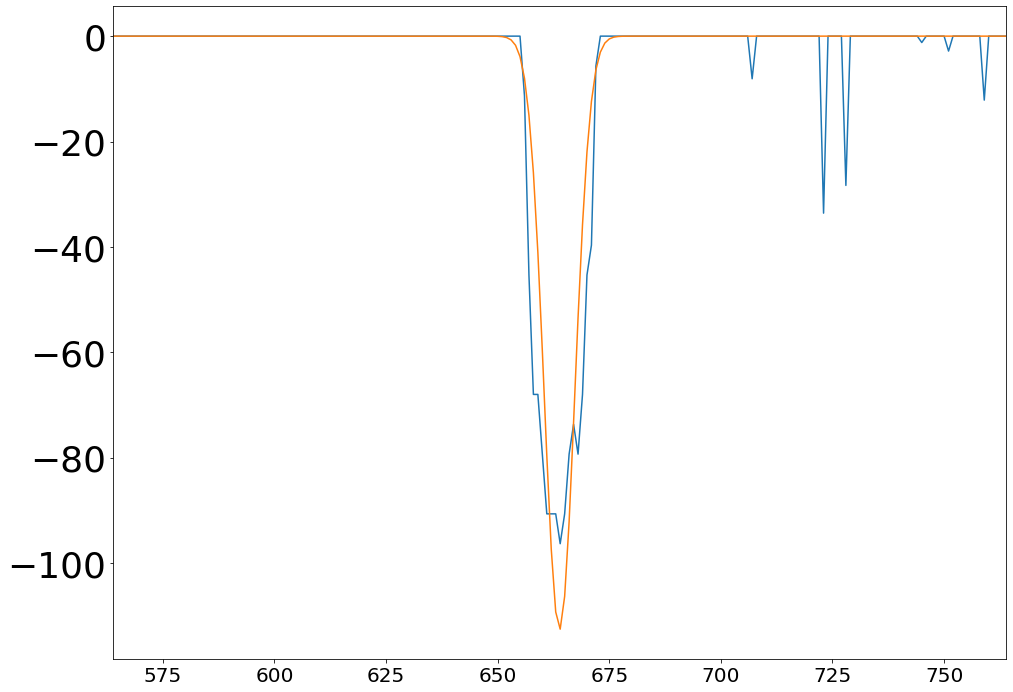

  6%|▌         | 13/213 [00:02<00:34,  5.73it/s]

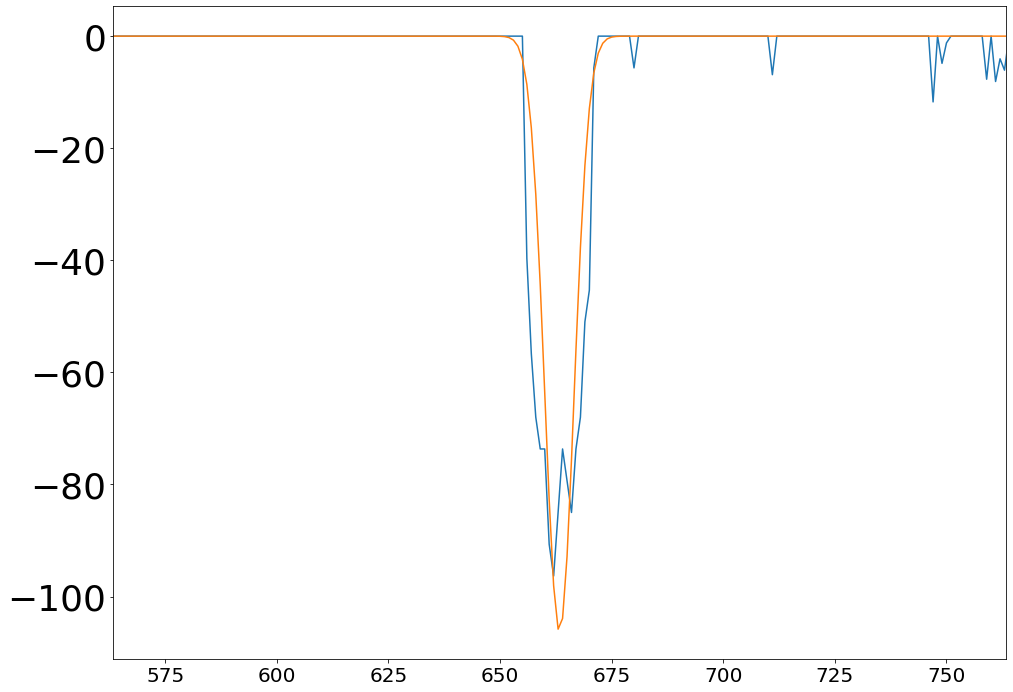

  7%|▋         | 14/213 [00:02<00:33,  5.93it/s]

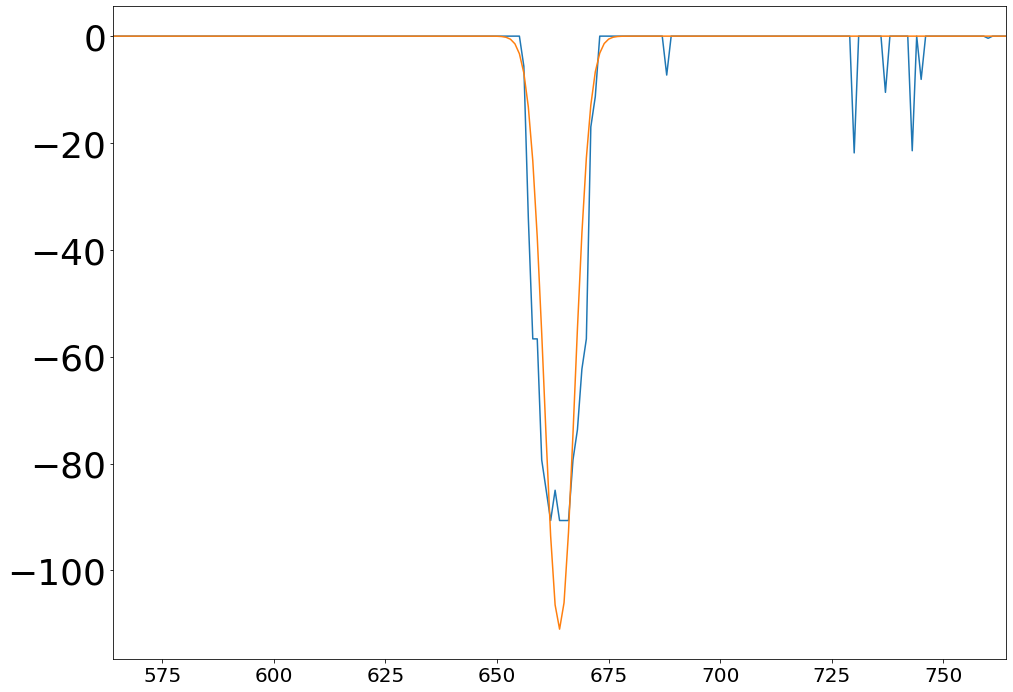

  7%|▋         | 15/213 [00:02<00:32,  6.14it/s]

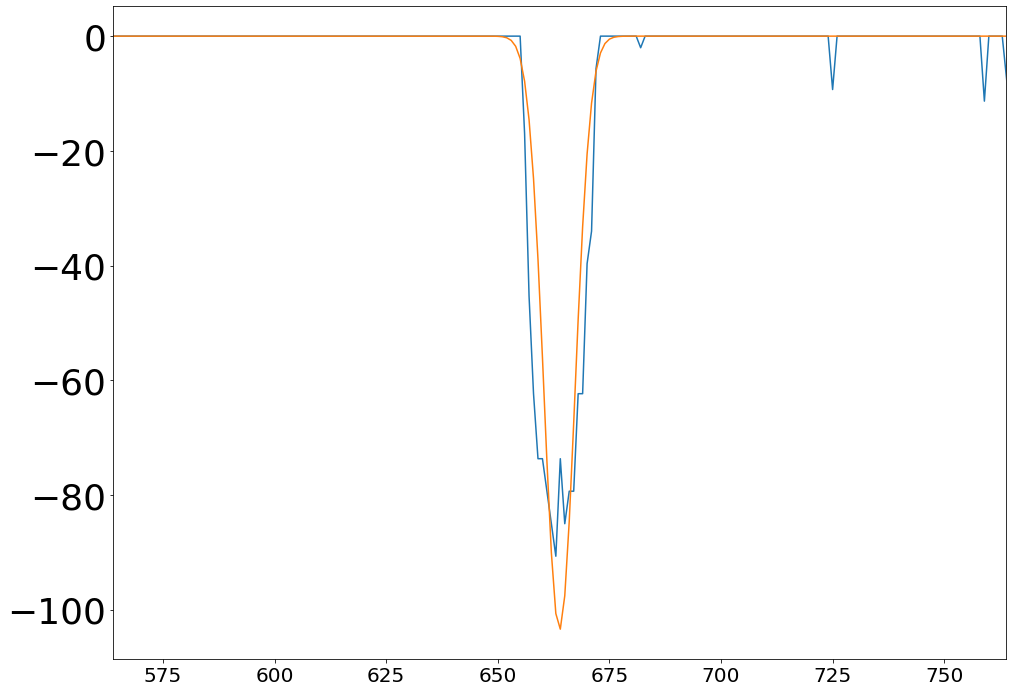

  8%|▊         | 16/213 [00:02<00:31,  6.32it/s]

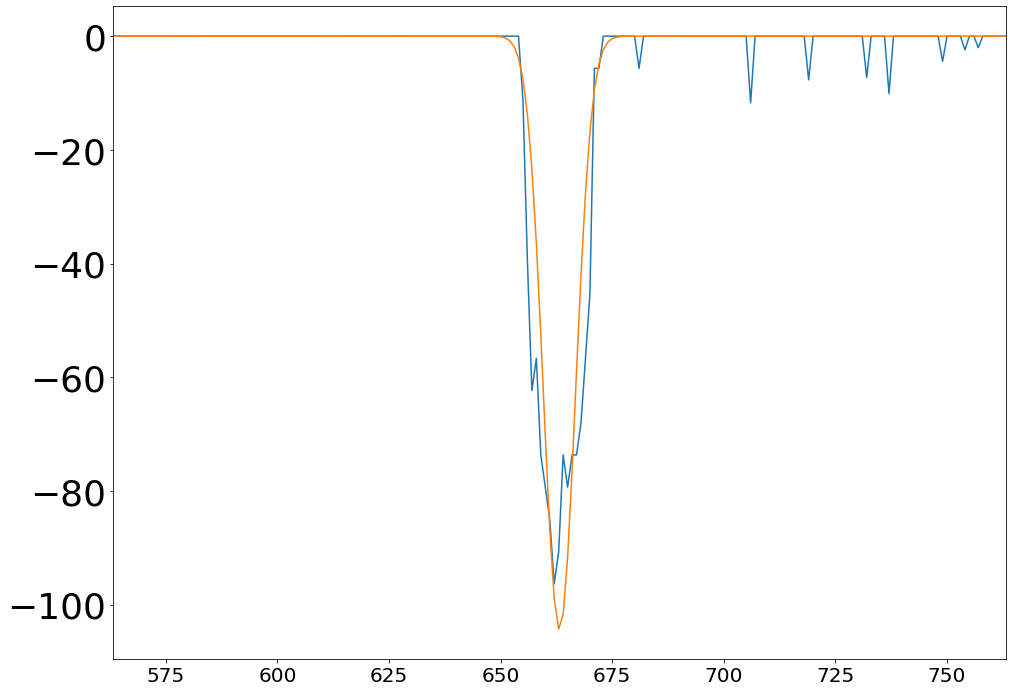

  8%|▊         | 17/213 [00:02<00:30,  6.44it/s]

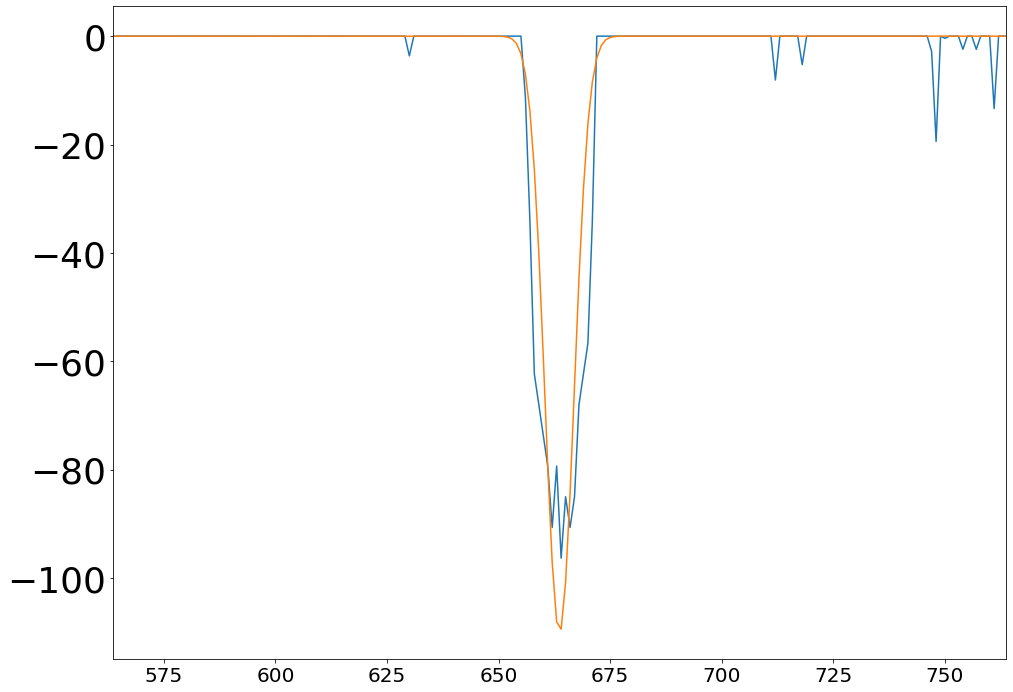

  8%|▊         | 18/213 [00:02<00:30,  6.47it/s]

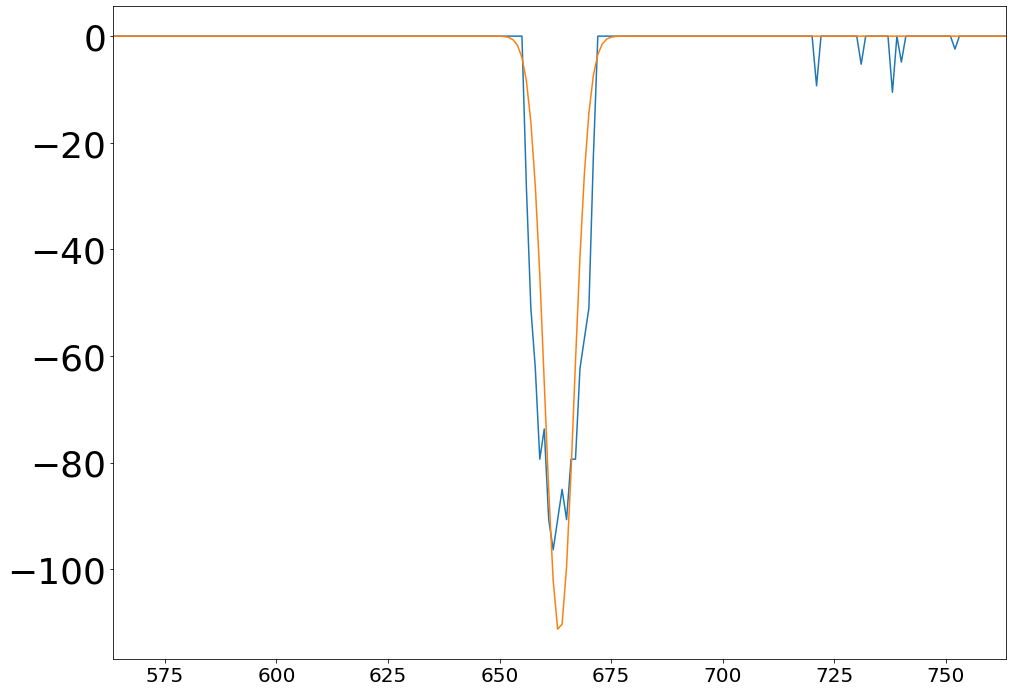

  9%|▉         | 19/213 [00:02<00:29,  6.51it/s]

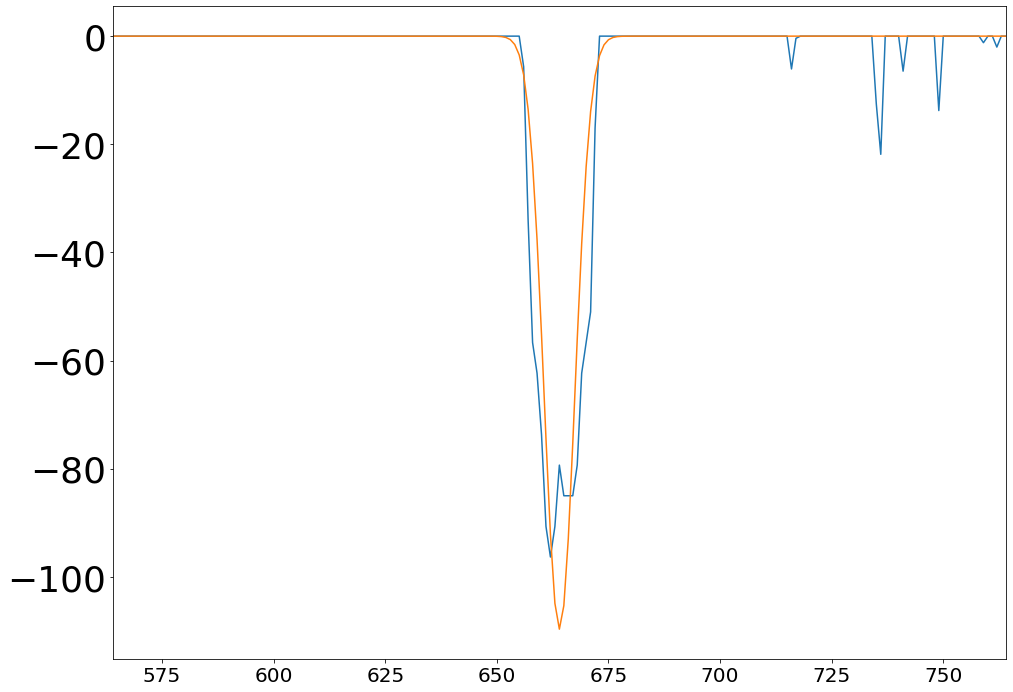

  9%|▉         | 20/213 [00:03<00:29,  6.55it/s]

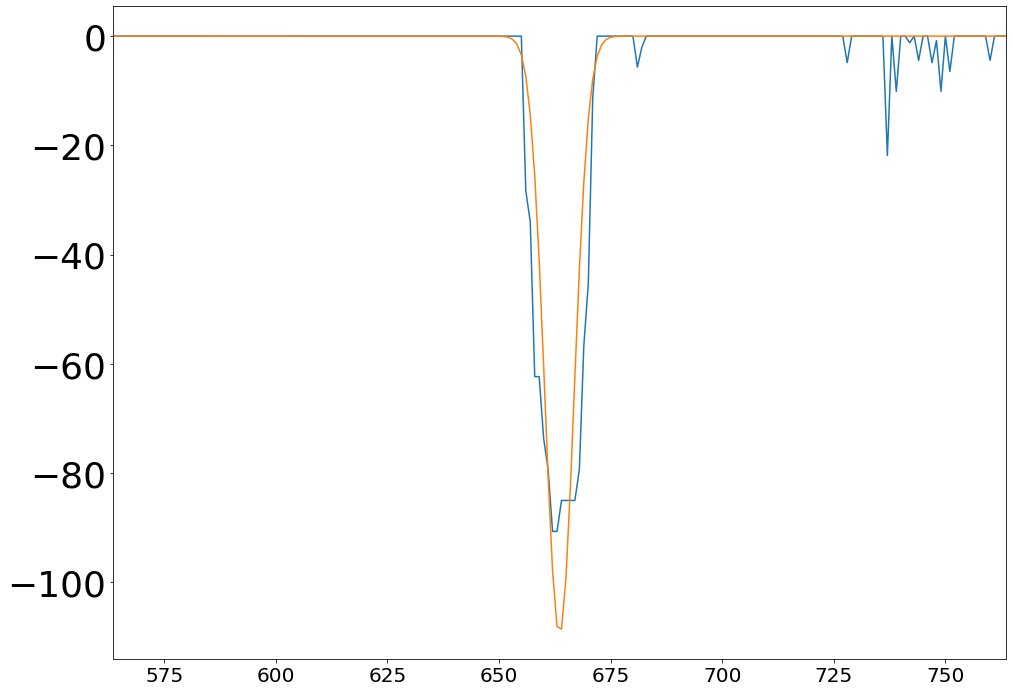

 10%|▉         | 21/213 [00:03<00:29,  6.61it/s]

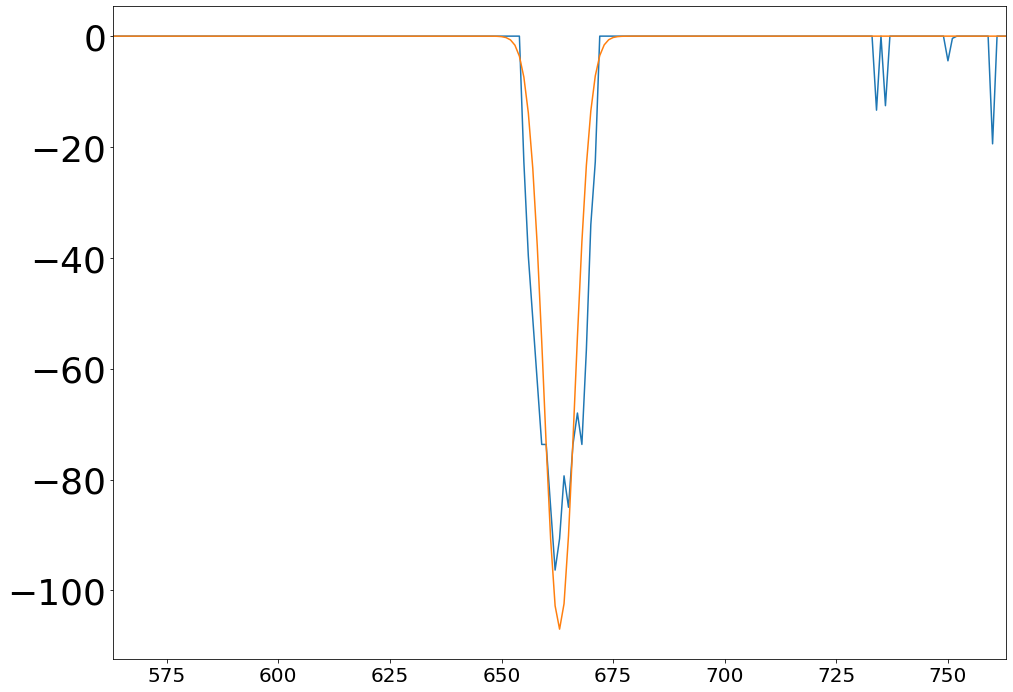

 10%|█         | 22/213 [00:03<00:28,  6.63it/s]

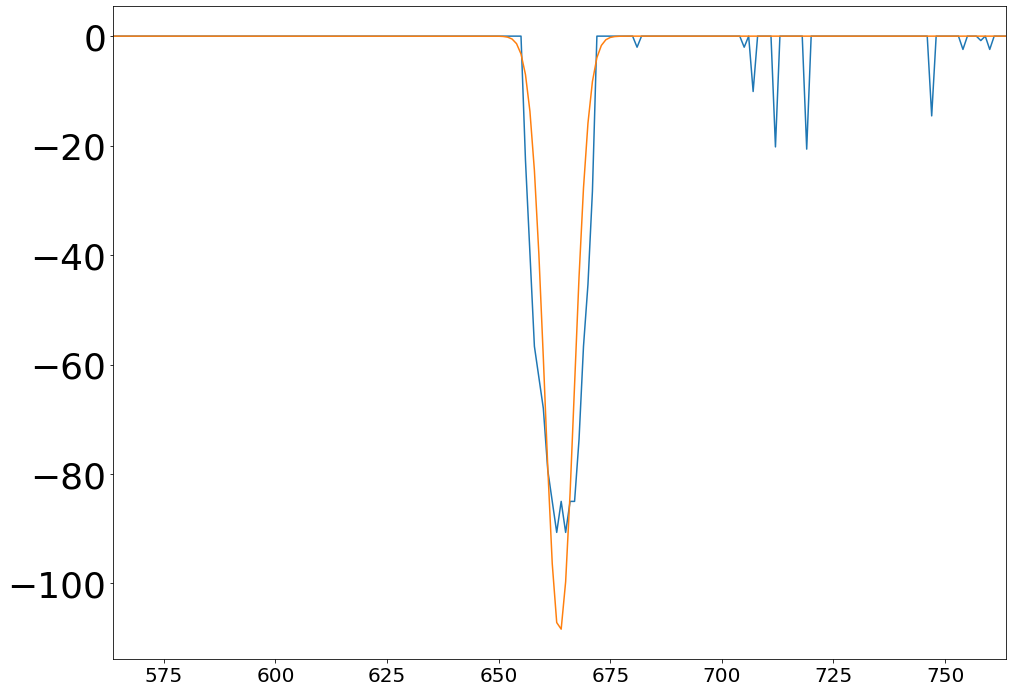

 11%|█         | 23/213 [00:03<00:28,  6.65it/s]

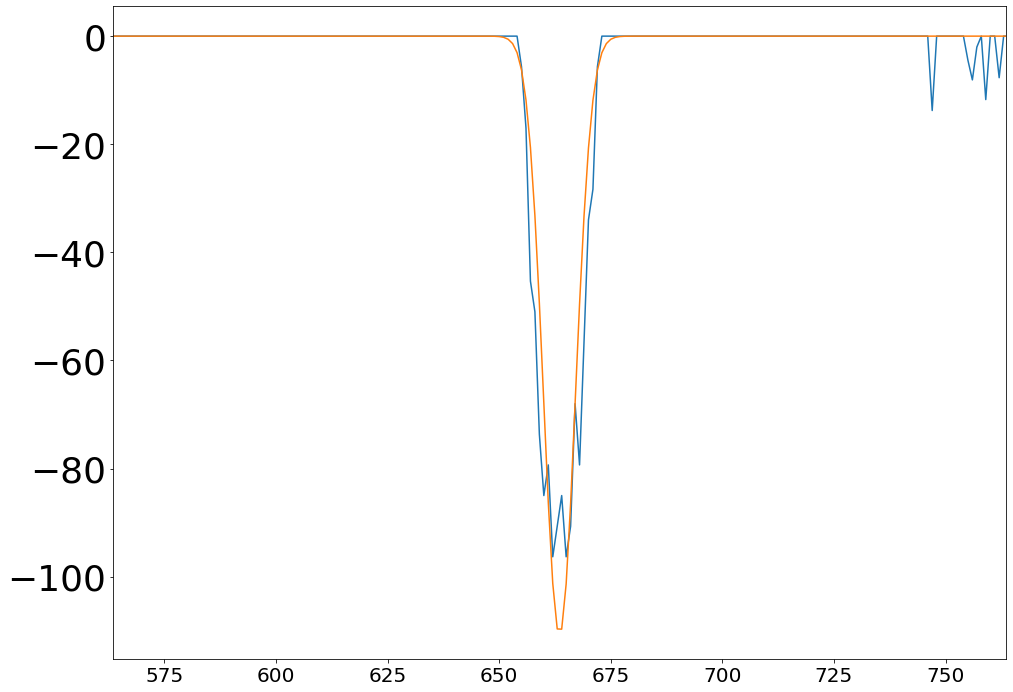

 11%|█▏        | 24/213 [00:03<00:28,  6.67it/s]

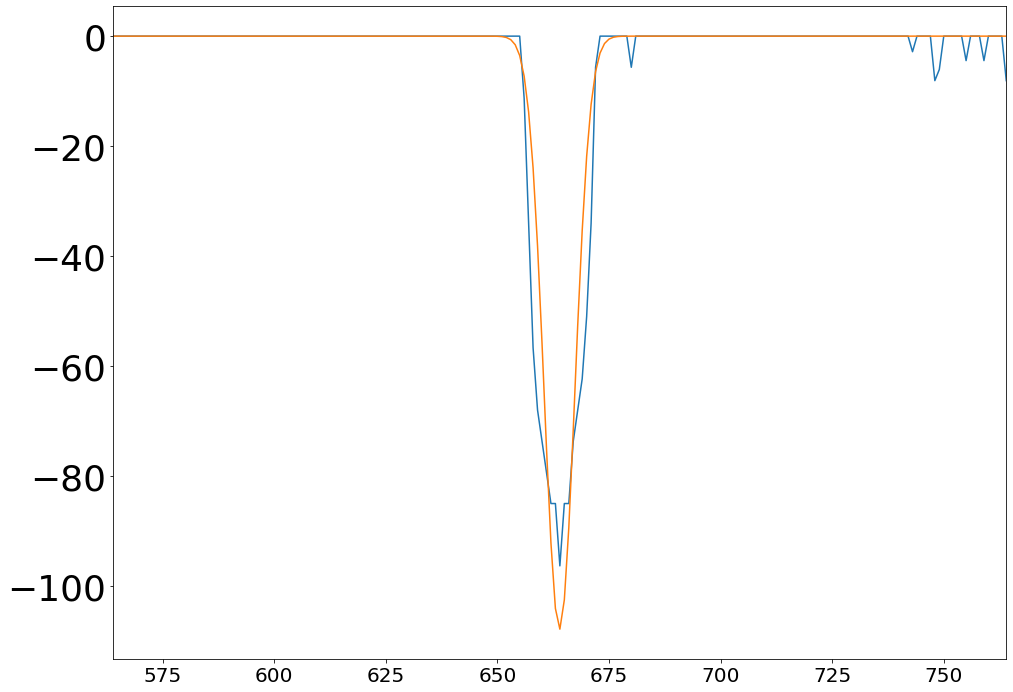

 12%|█▏        | 25/213 [00:03<00:27,  6.72it/s]

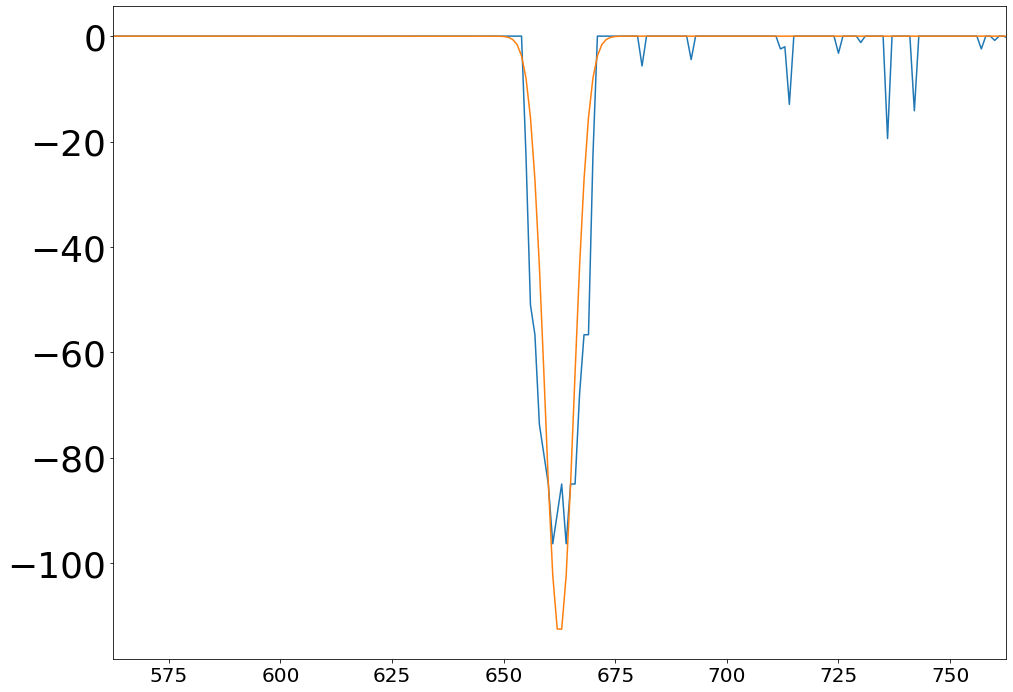

 12%|█▏        | 26/213 [00:04<00:30,  6.09it/s]

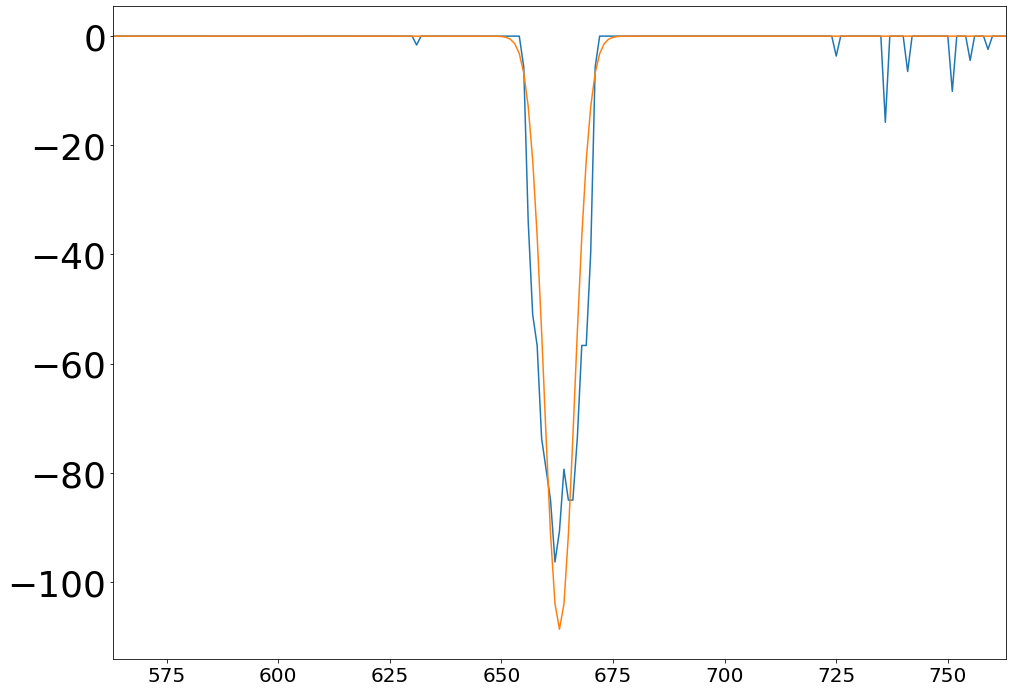

 13%|█▎        | 27/213 [00:04<00:29,  6.21it/s]

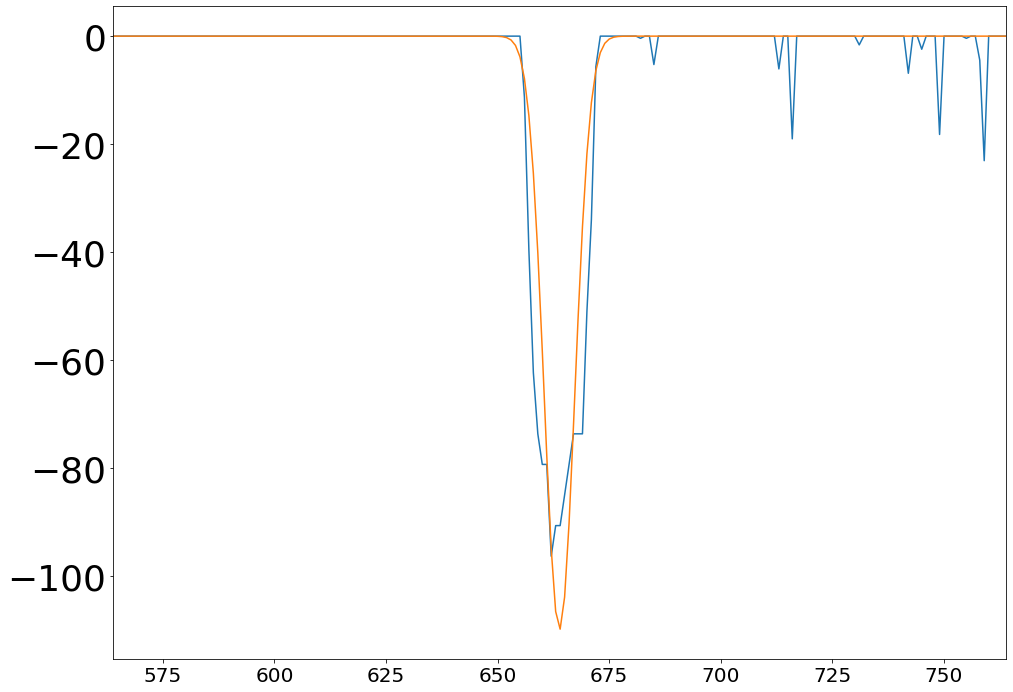

 13%|█▎        | 28/213 [00:04<00:29,  6.30it/s]

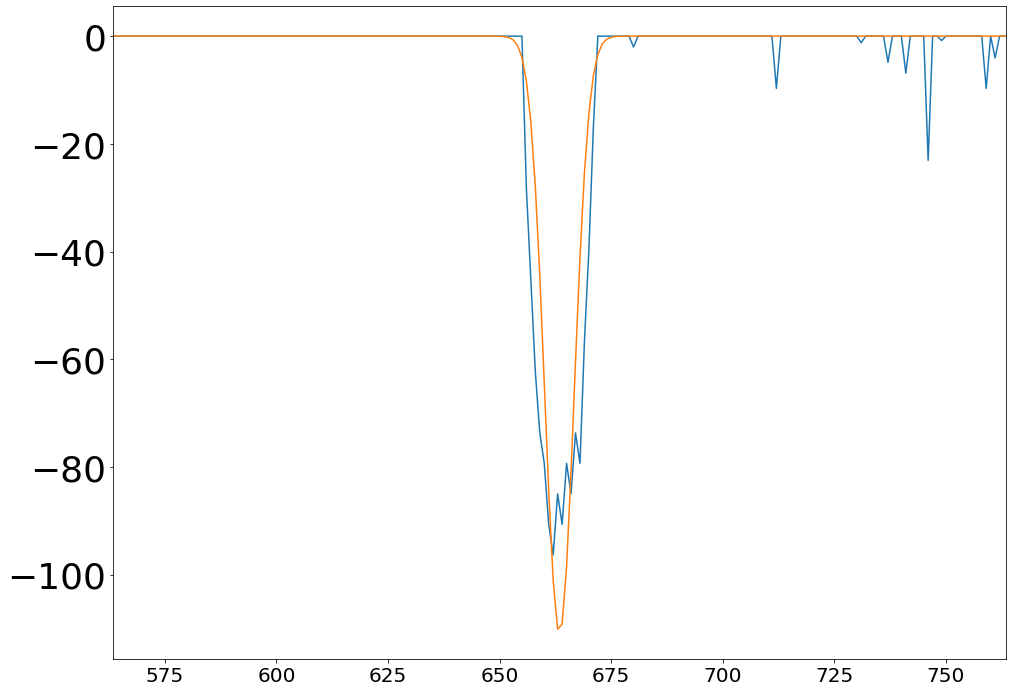

 14%|█▎        | 29/213 [00:04<00:28,  6.44it/s]

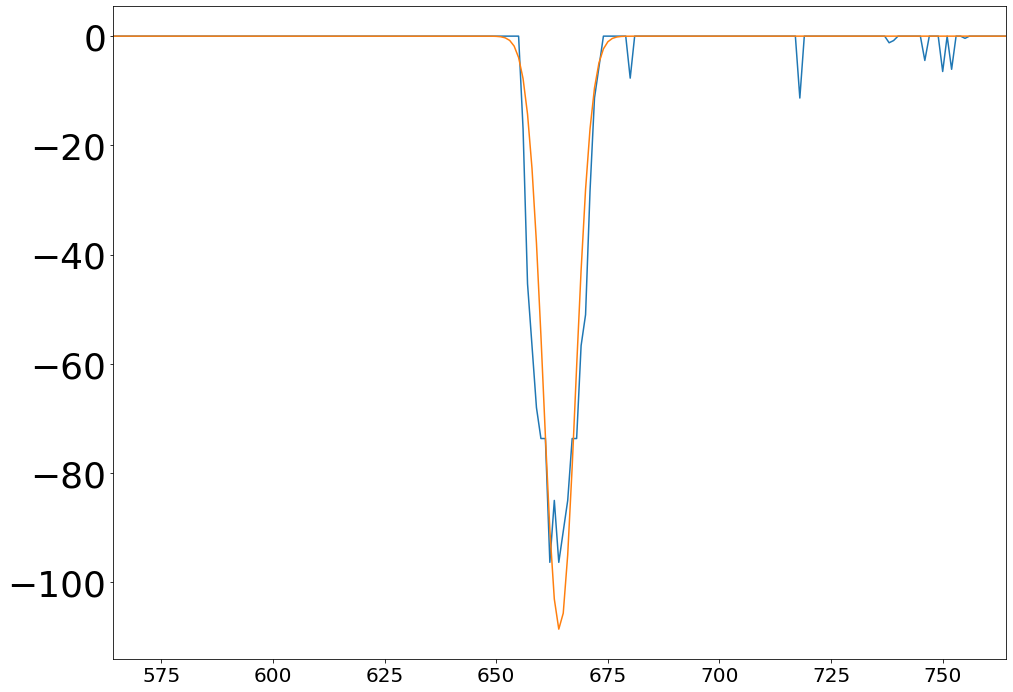

 14%|█▍        | 30/213 [00:04<00:28,  6.47it/s]

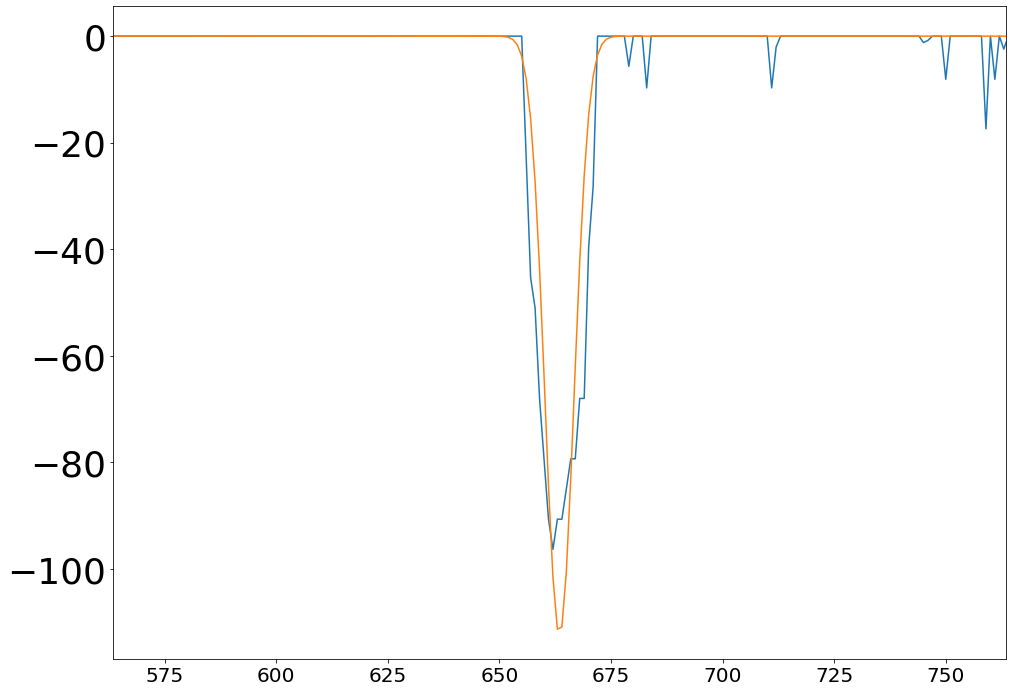

 15%|█▍        | 31/213 [00:04<00:27,  6.58it/s]

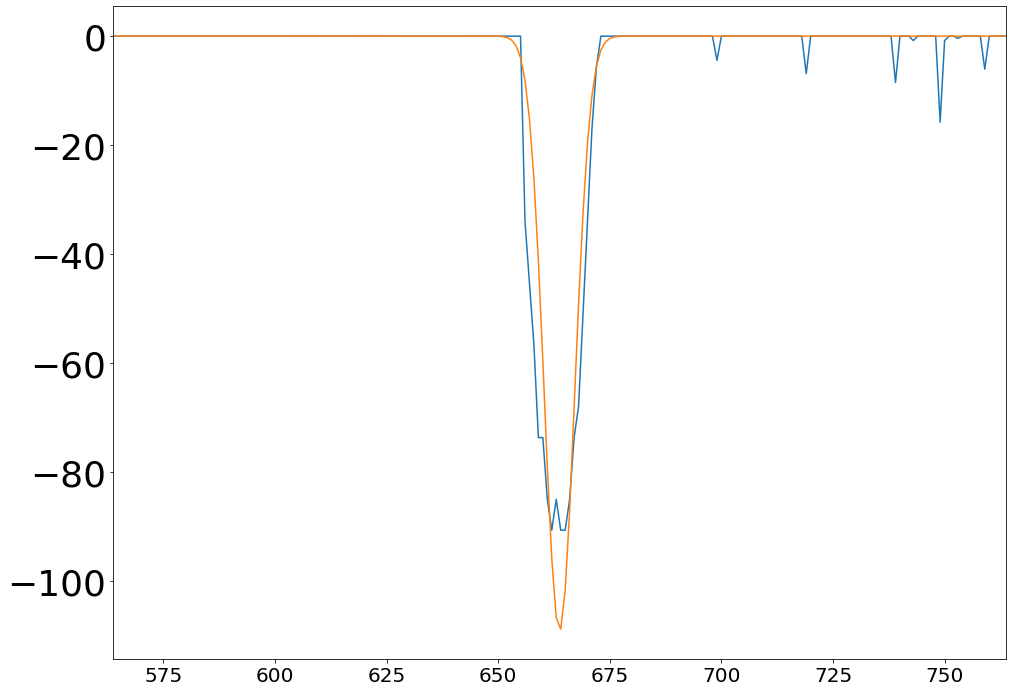

 15%|█▌        | 32/213 [00:04<00:27,  6.65it/s]

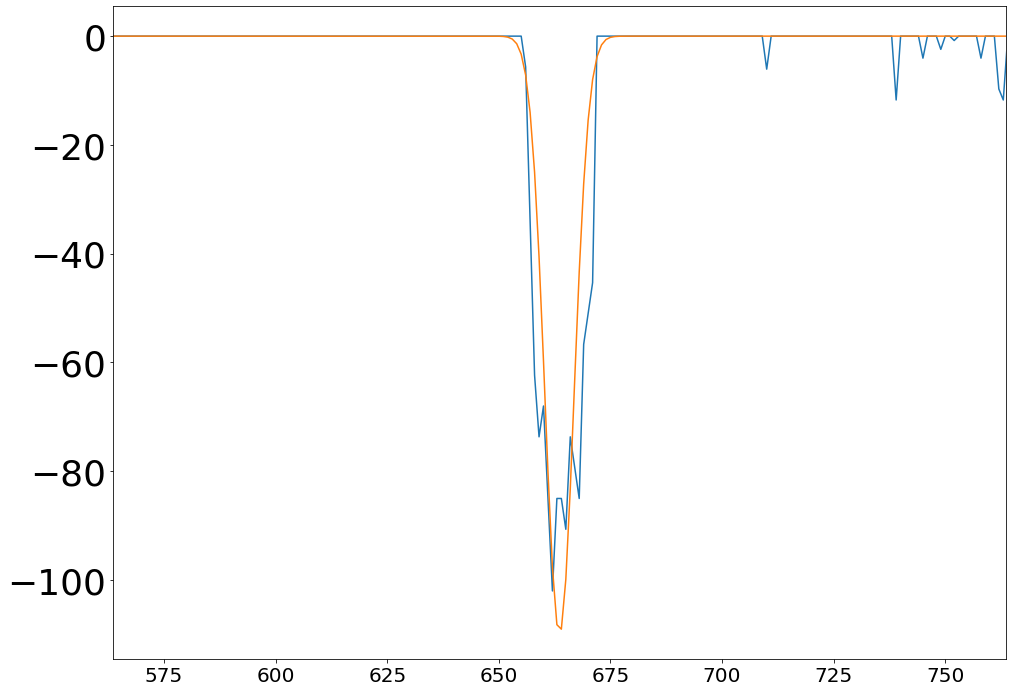

 15%|█▌        | 33/213 [00:05<00:27,  6.63it/s]

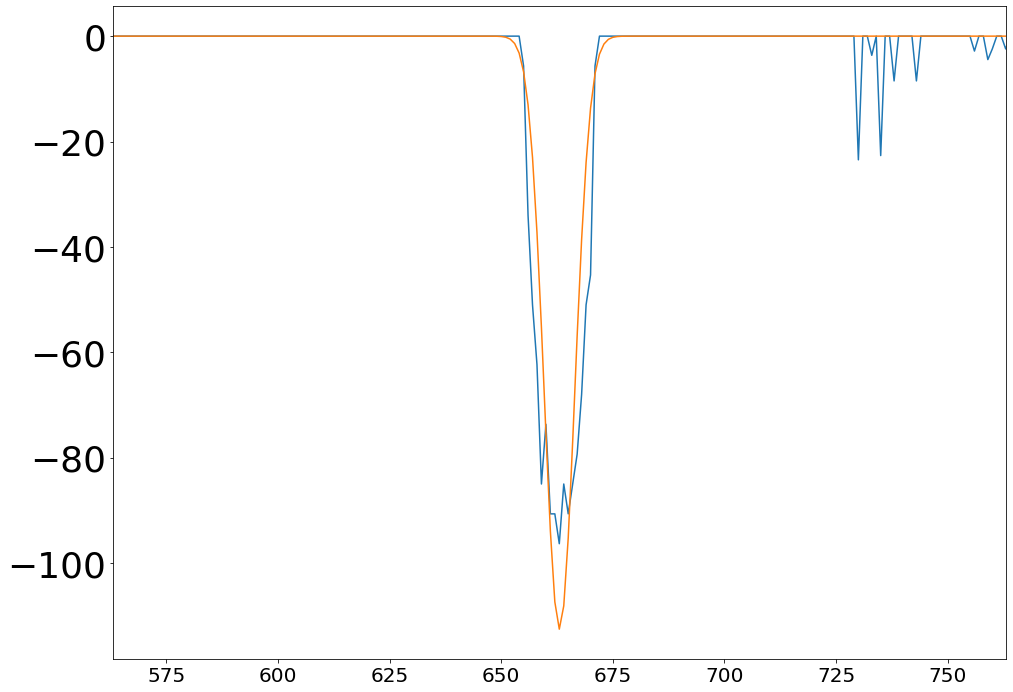

 16%|█▌        | 34/213 [00:05<00:26,  6.69it/s]

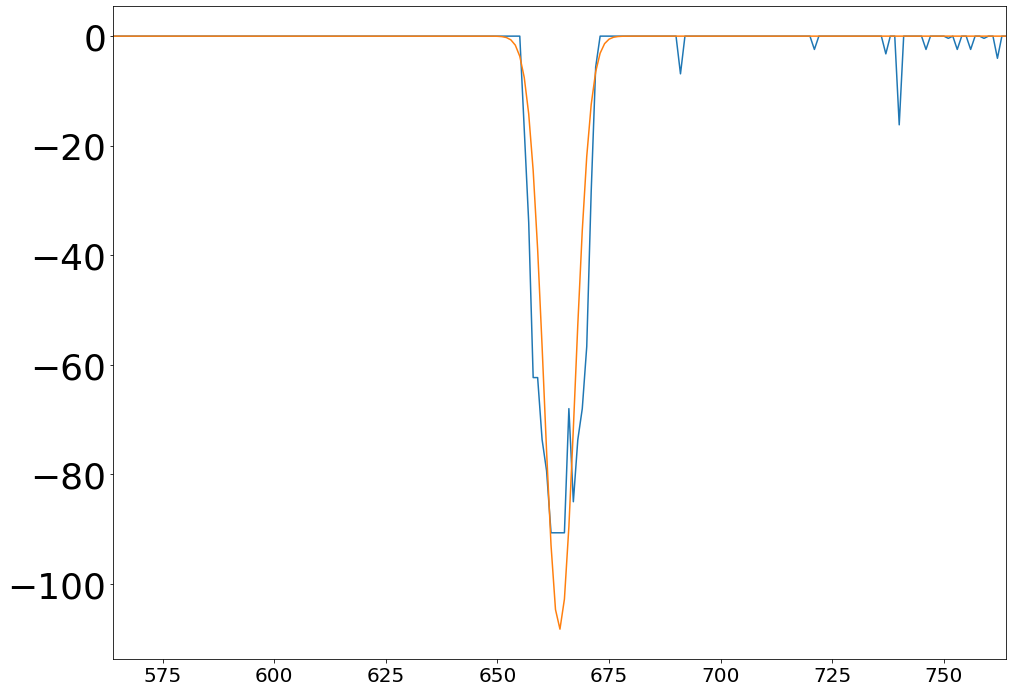

 16%|█▋        | 35/213 [00:05<00:26,  6.73it/s]

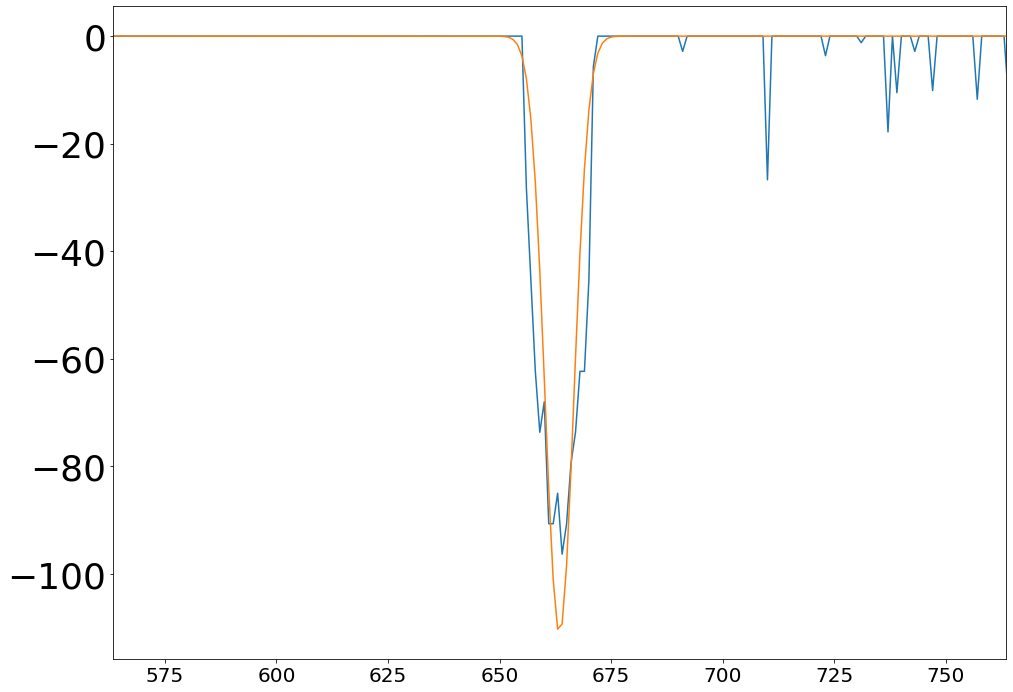

 17%|█▋        | 36/213 [00:05<00:26,  6.74it/s]

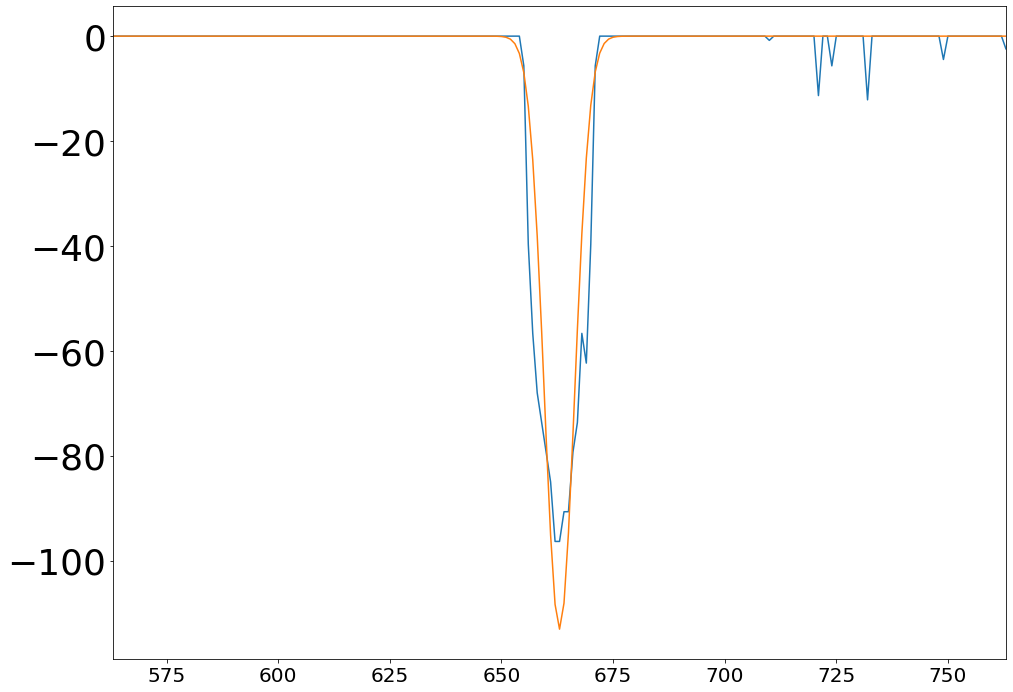

 17%|█▋        | 37/213 [00:05<00:26,  6.77it/s]

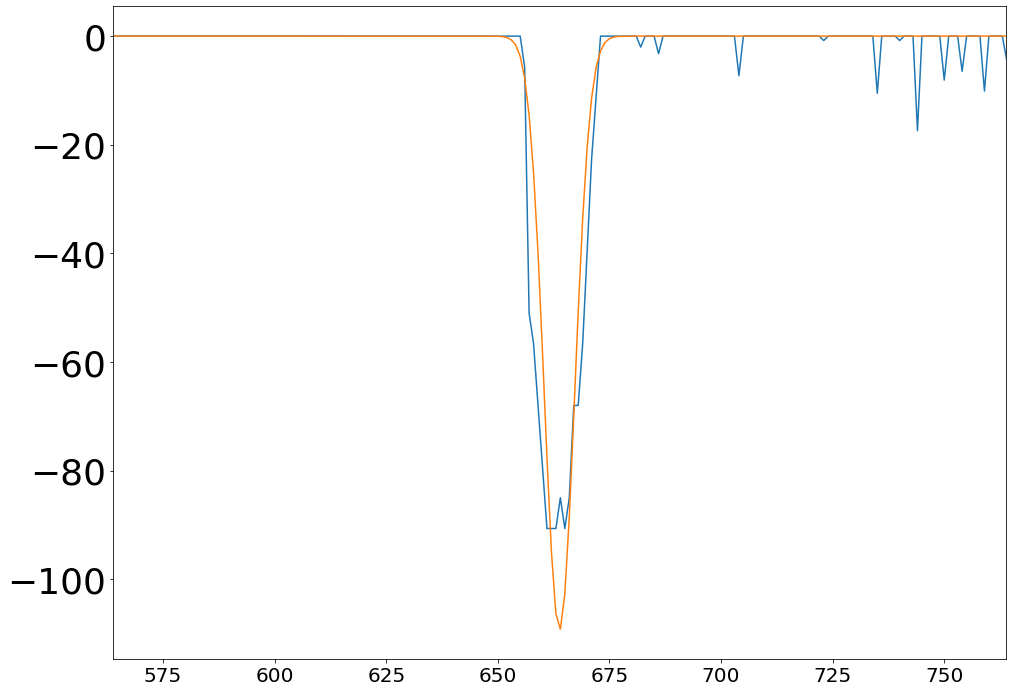

 18%|█▊        | 38/213 [00:05<00:26,  6.73it/s]

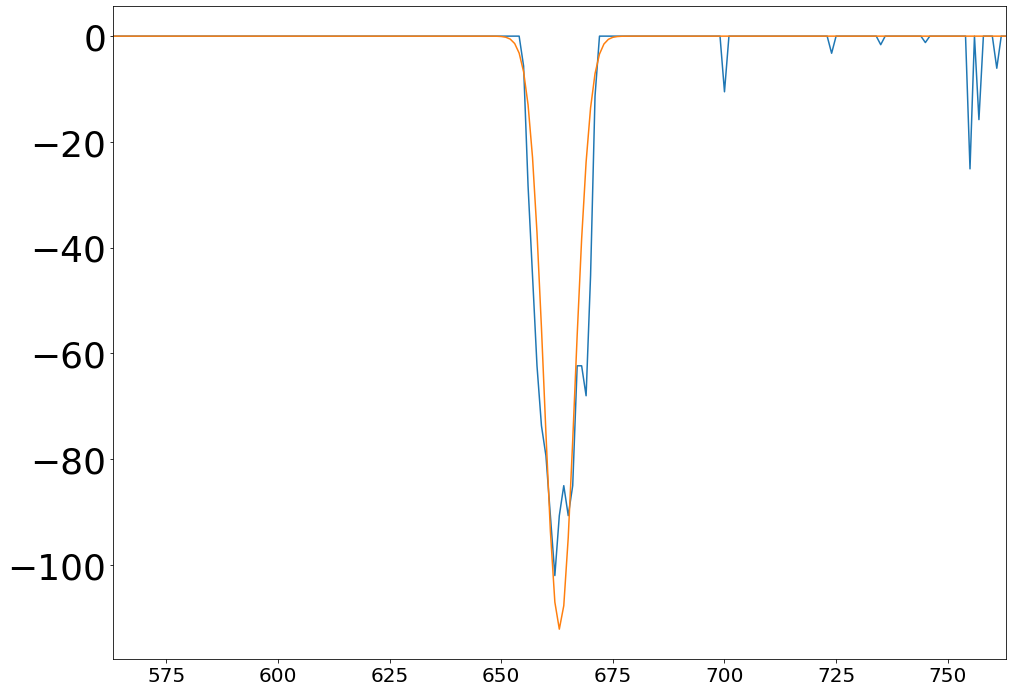

 18%|█▊        | 39/213 [00:06<00:28,  6.14it/s]

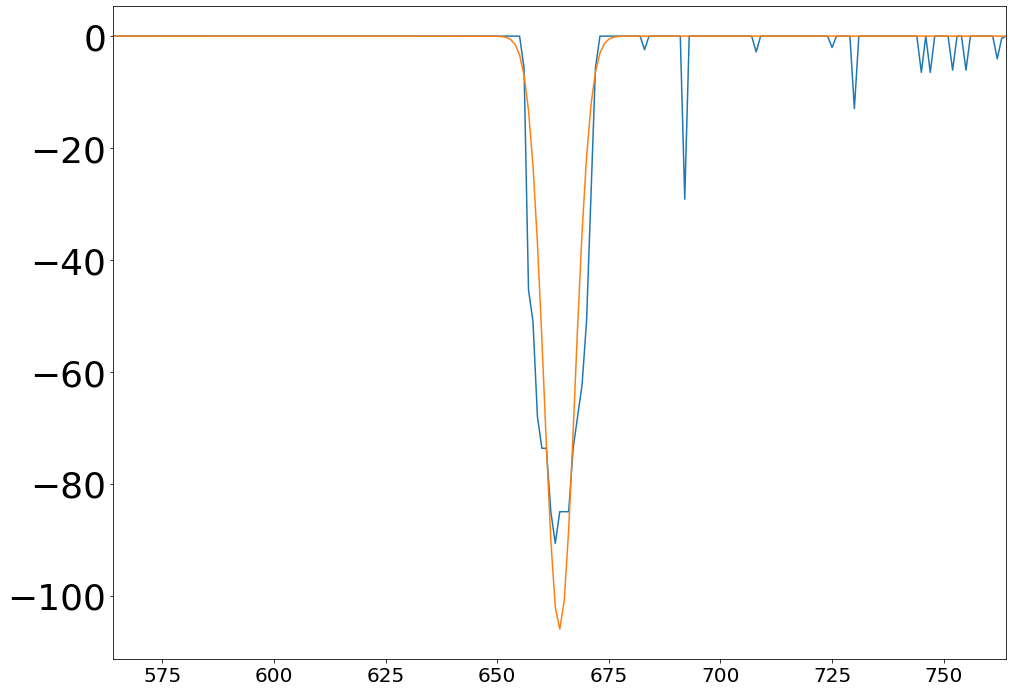

 19%|█▉        | 40/213 [00:06<00:27,  6.26it/s]

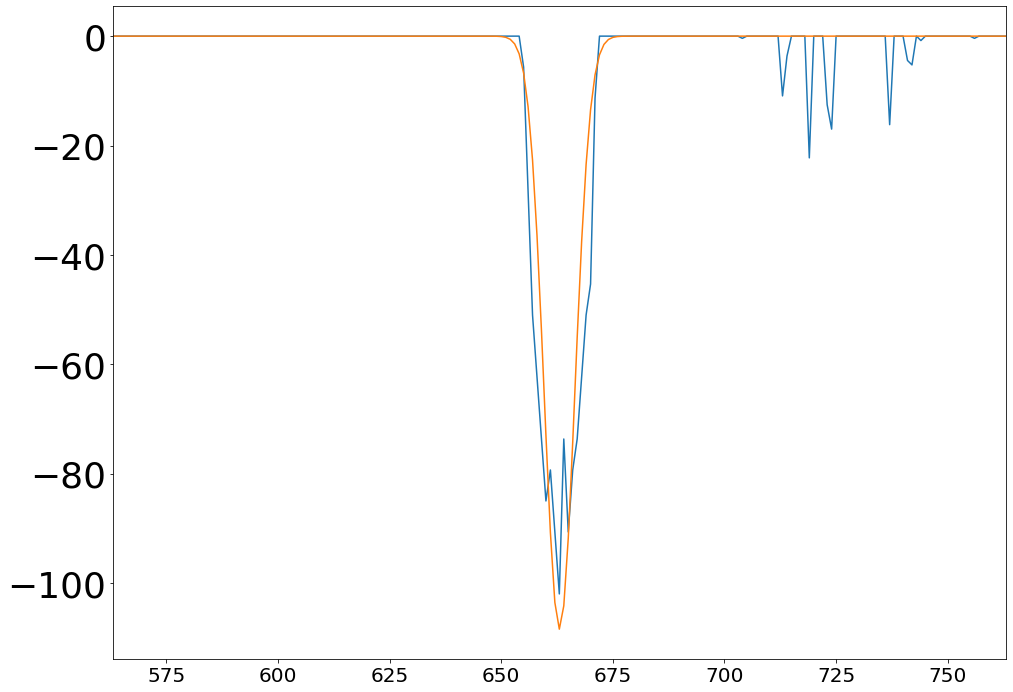

 19%|█▉        | 41/213 [00:06<00:26,  6.44it/s]

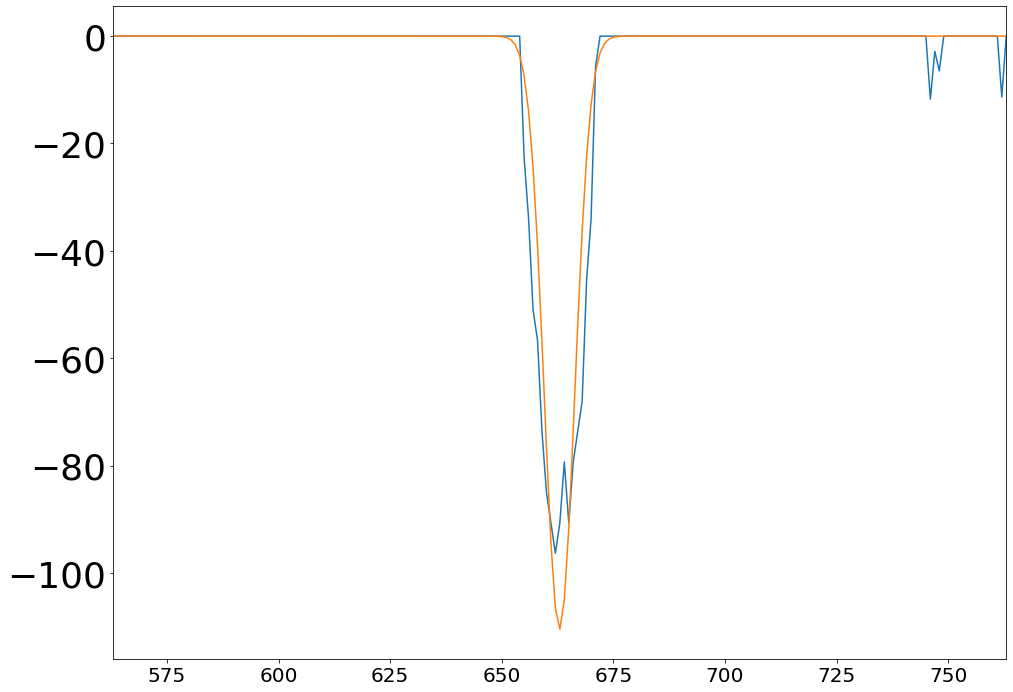

 20%|█▉        | 42/213 [00:06<00:25,  6.59it/s]

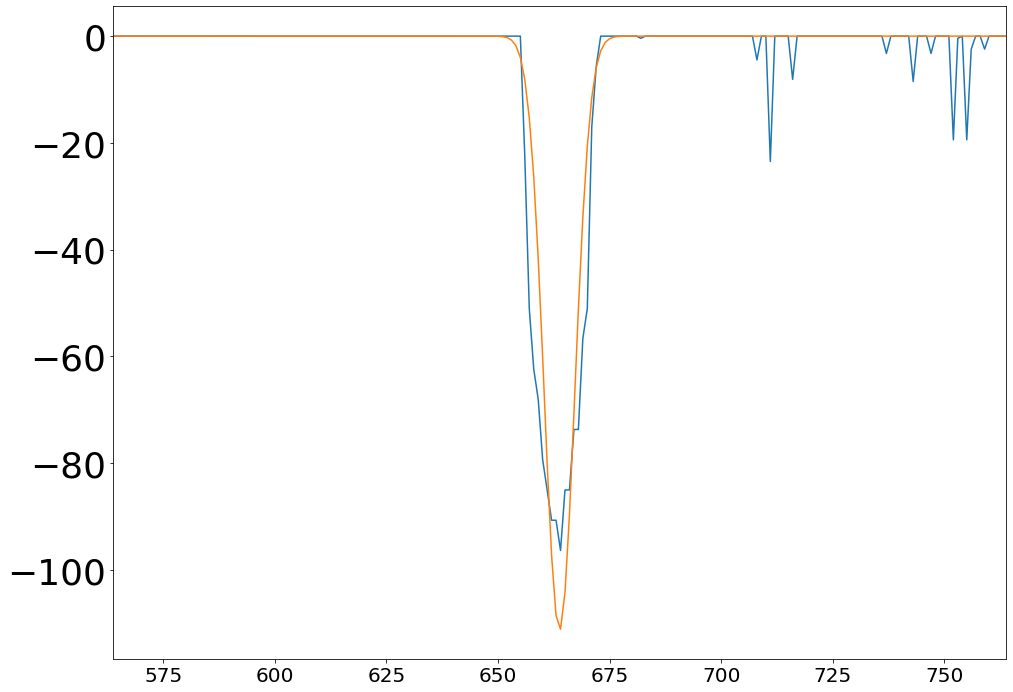

 20%|██        | 43/213 [00:06<00:25,  6.67it/s]

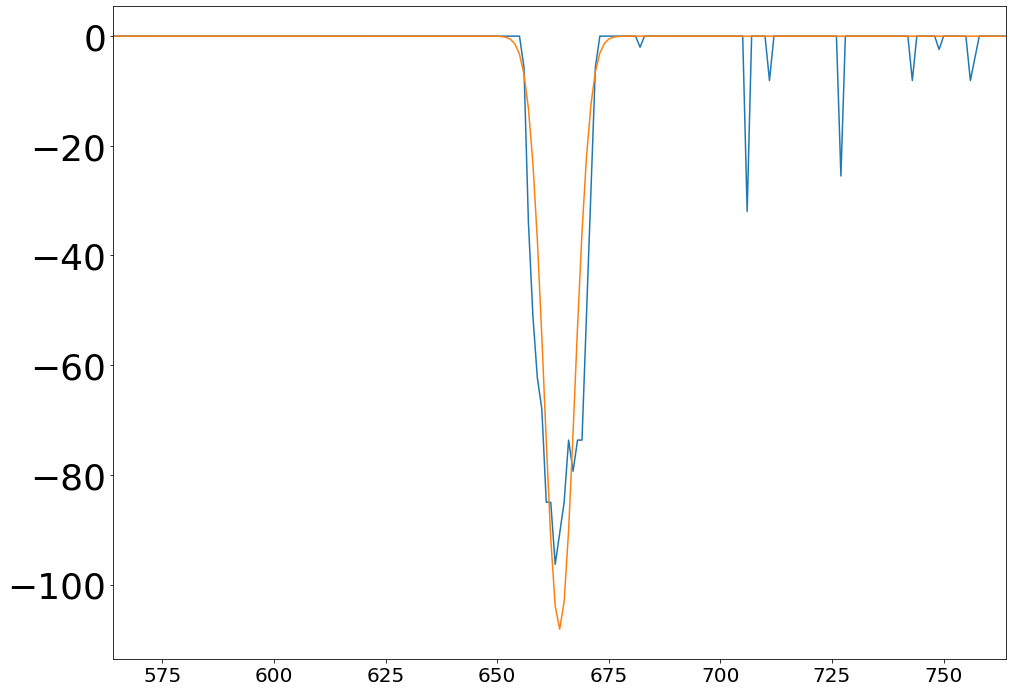

 21%|██        | 44/213 [00:06<00:25,  6.68it/s]

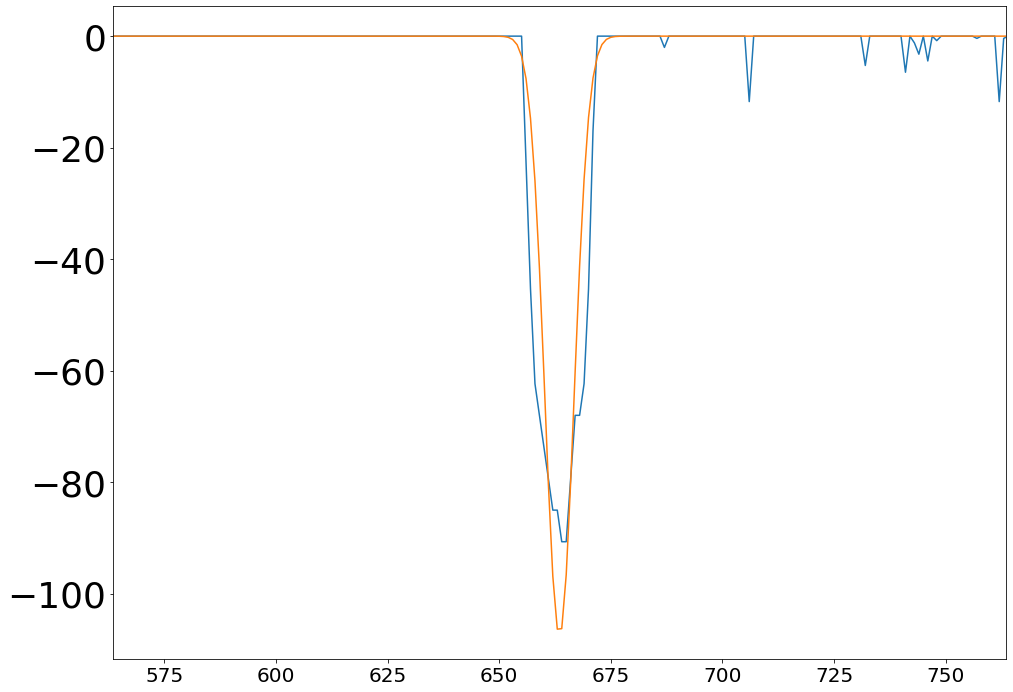

 21%|██        | 45/213 [00:06<00:25,  6.70it/s]

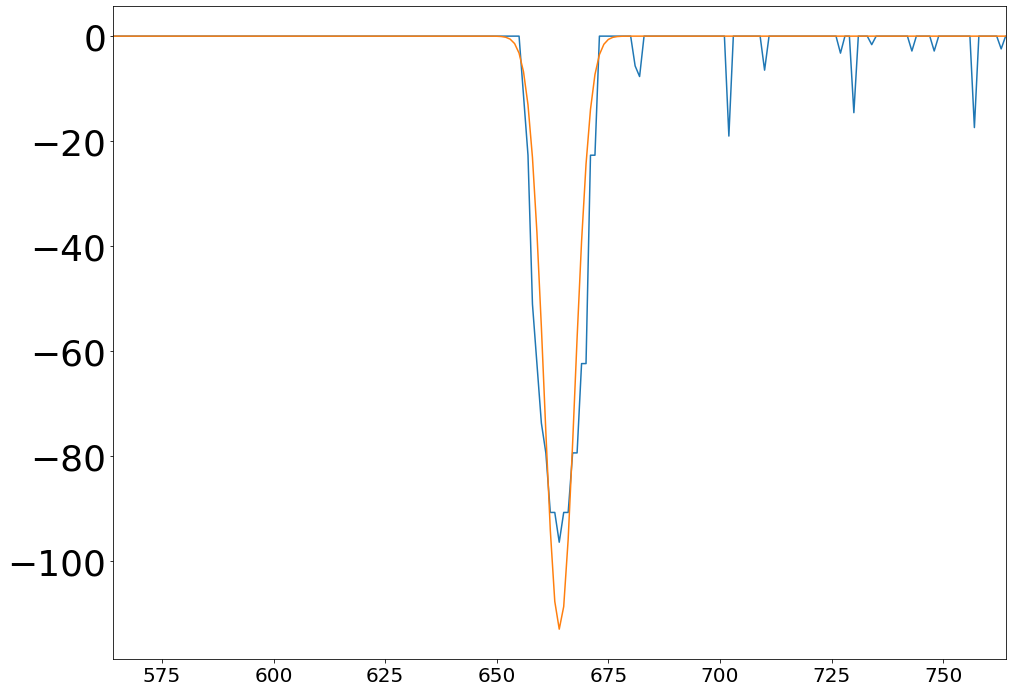

 22%|██▏       | 46/213 [00:07<00:24,  6.78it/s]

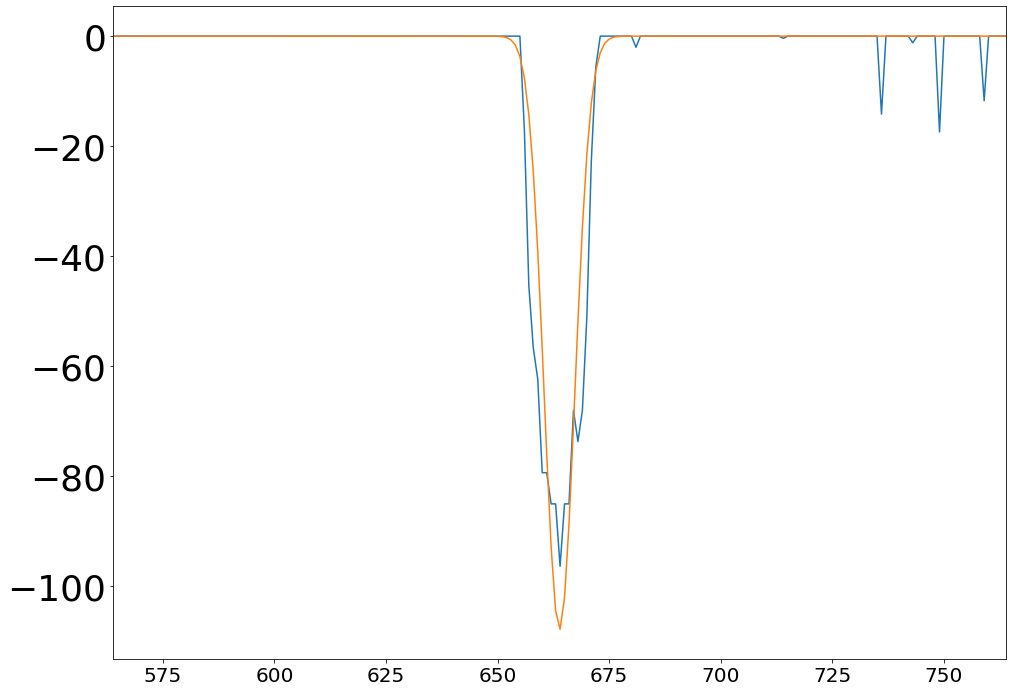

 22%|██▏       | 47/213 [00:07<00:24,  6.81it/s]

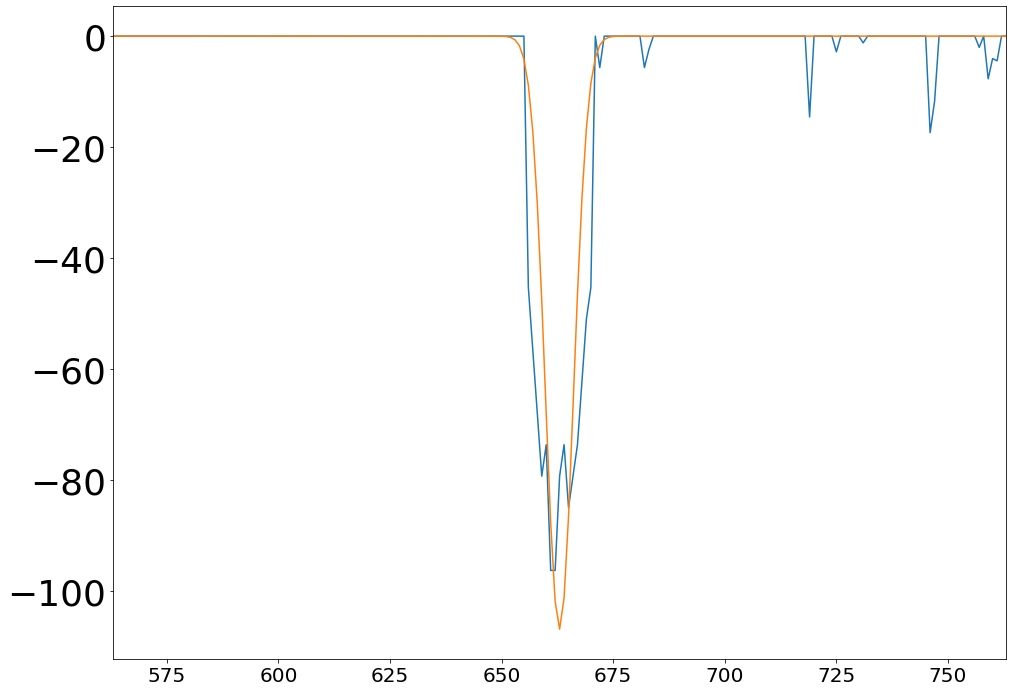

 23%|██▎       | 48/213 [00:07<00:24,  6.75it/s]

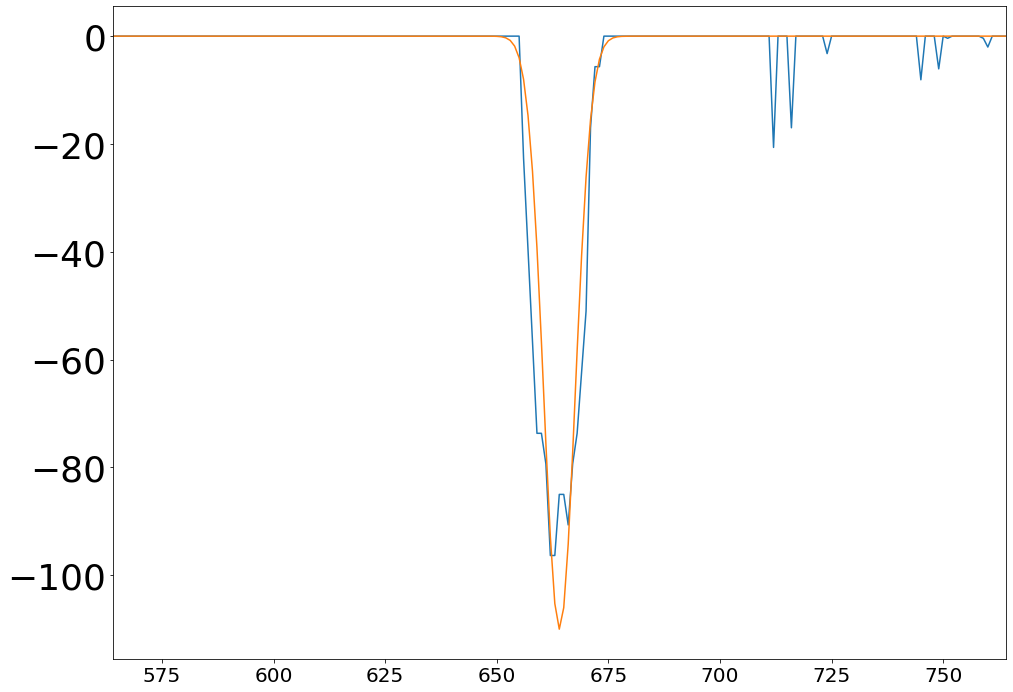

 23%|██▎       | 49/213 [00:07<00:24,  6.71it/s]

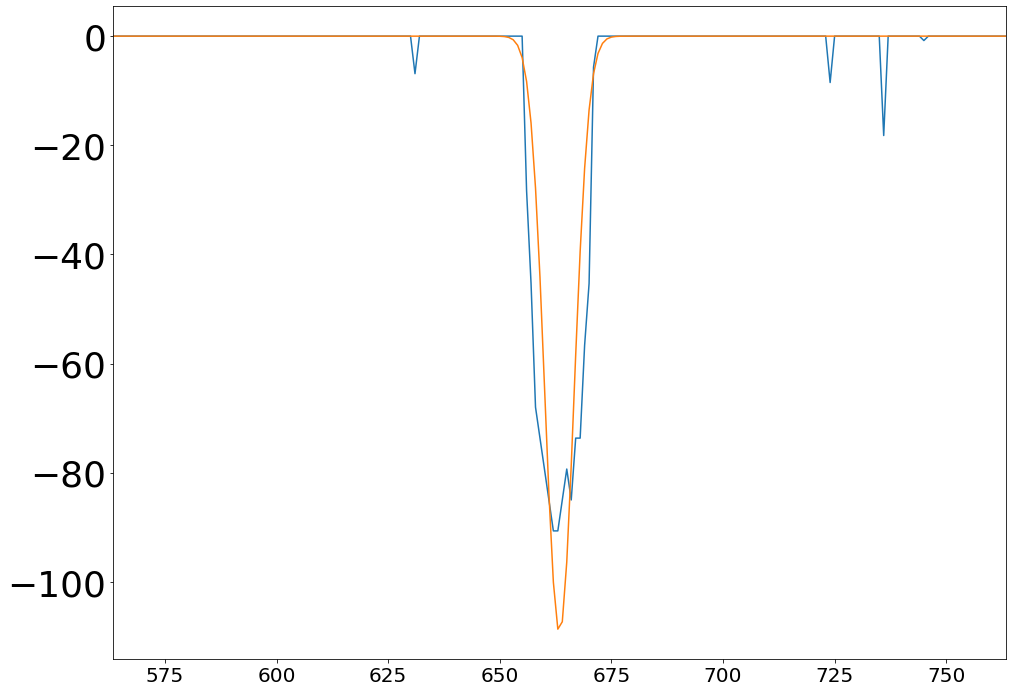

 23%|██▎       | 50/213 [00:07<00:24,  6.77it/s]

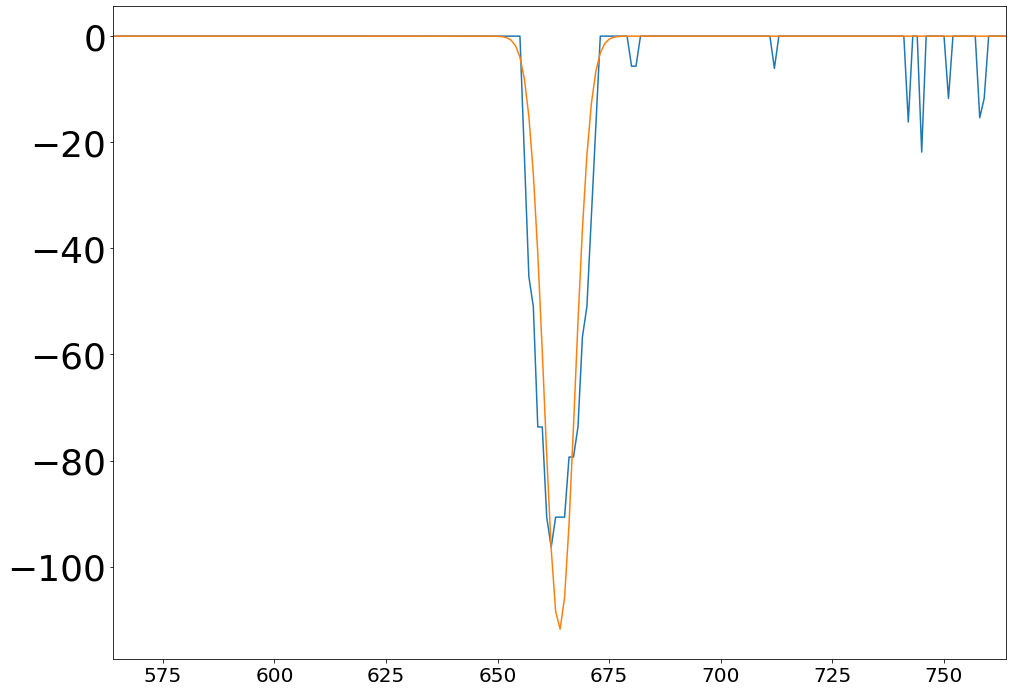

 24%|██▍       | 51/213 [00:07<00:23,  6.84it/s]

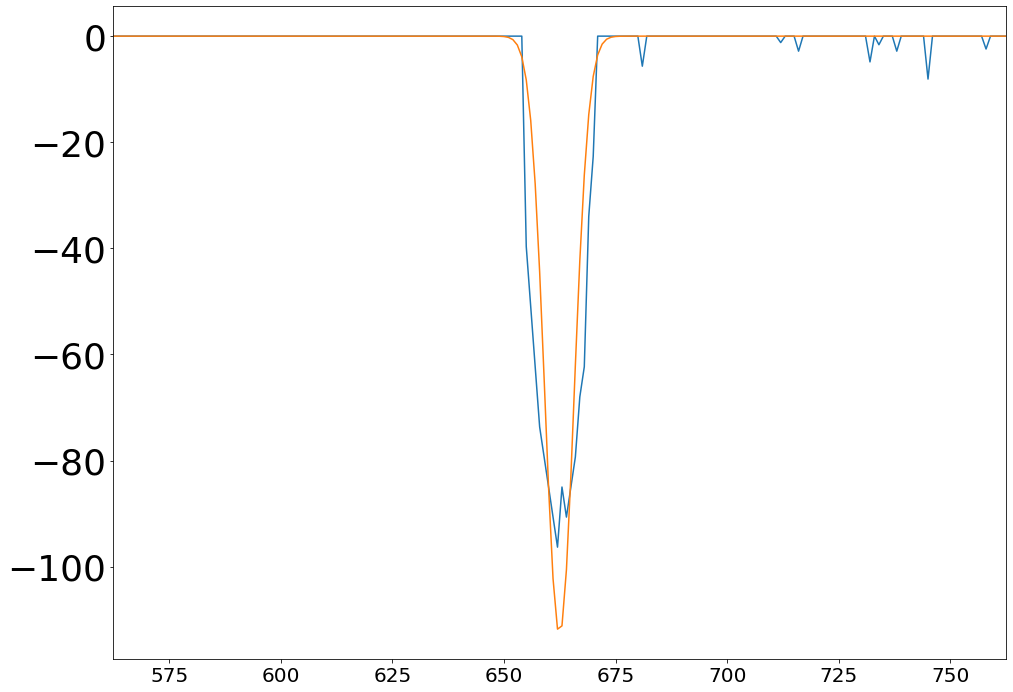

 24%|██▍       | 52/213 [00:08<00:25,  6.19it/s]

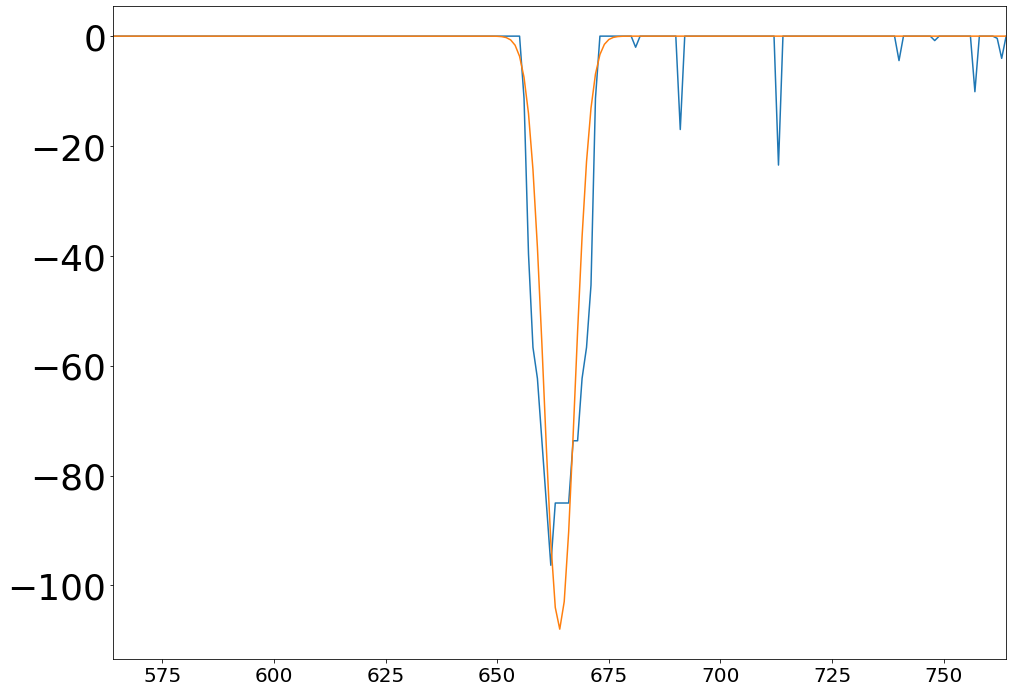

 25%|██▍       | 53/213 [00:08<00:25,  6.32it/s]

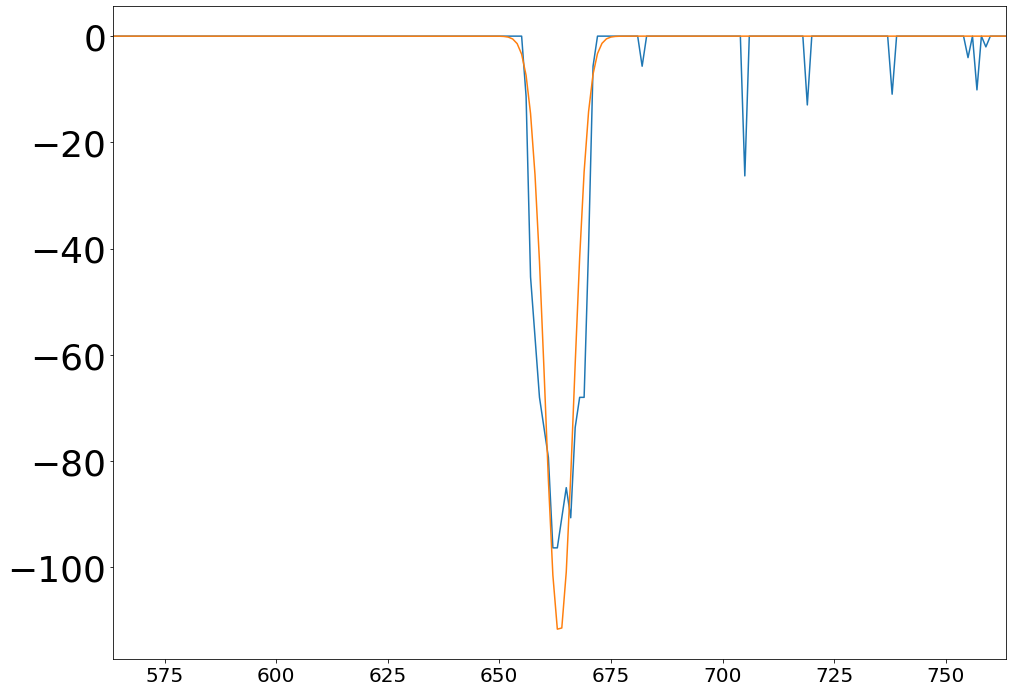

 25%|██▌       | 54/213 [00:08<00:24,  6.49it/s]

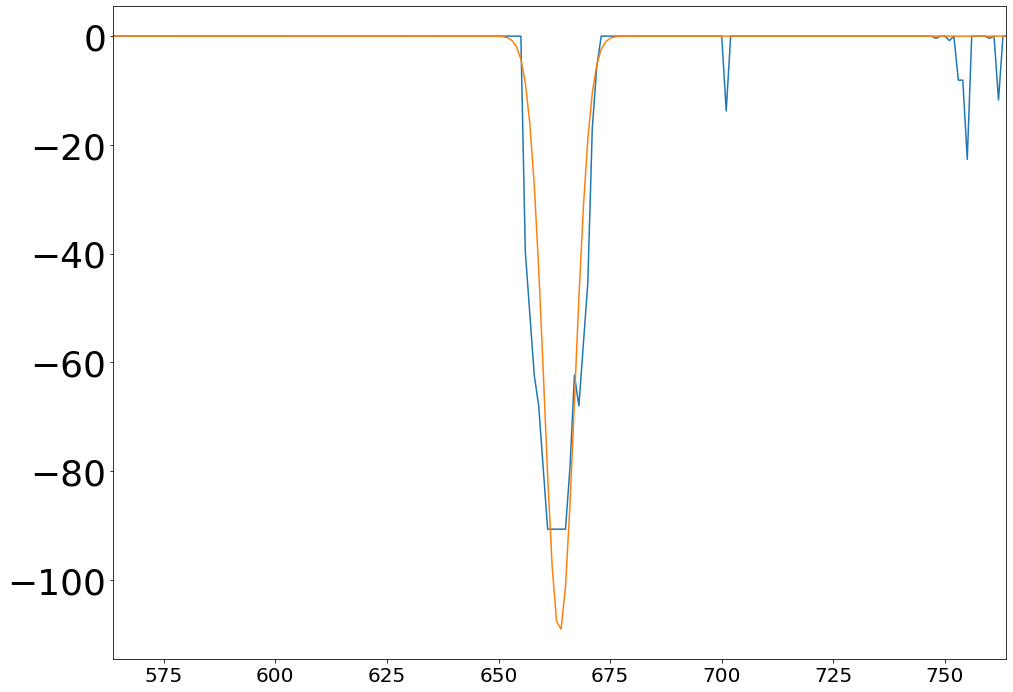

 26%|██▌       | 55/213 [00:08<00:23,  6.60it/s]

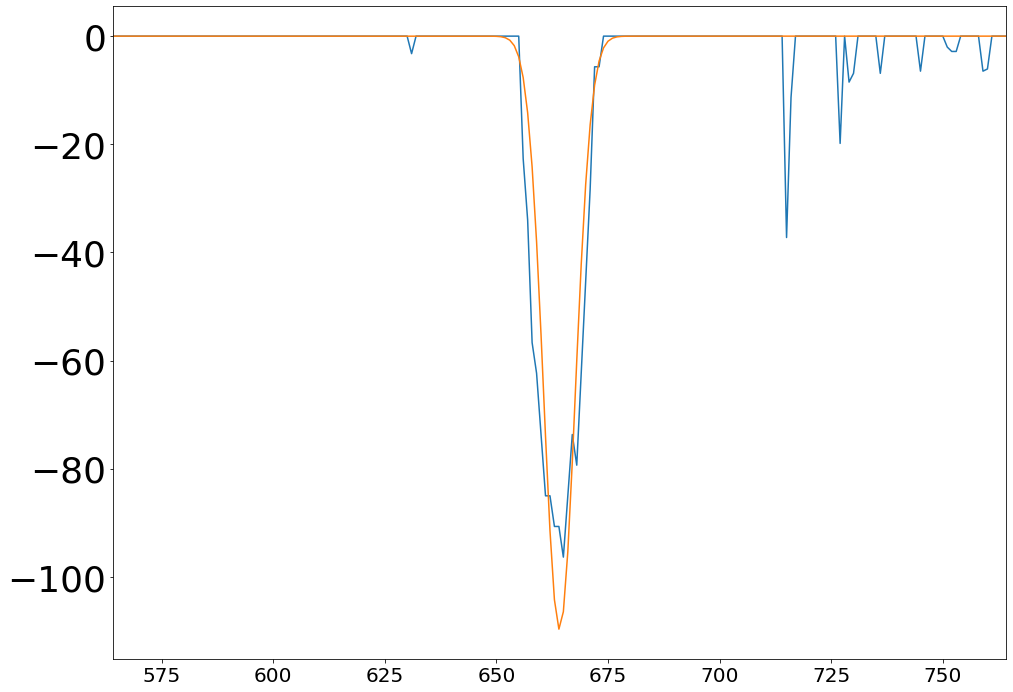

 26%|██▋       | 56/213 [00:08<00:23,  6.57it/s]

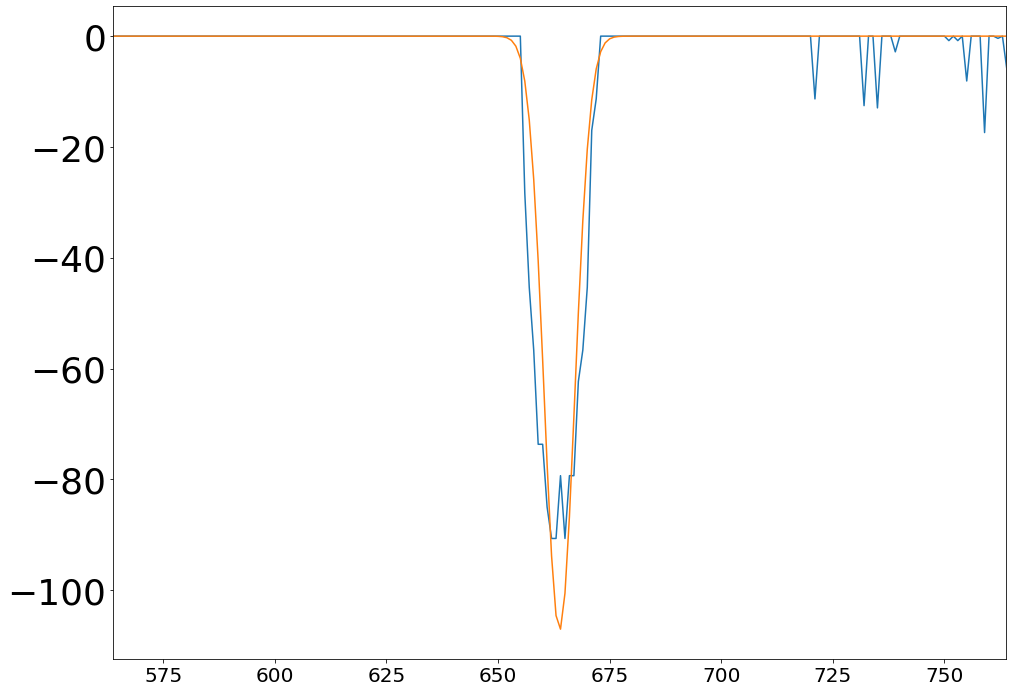

 27%|██▋       | 57/213 [00:08<00:23,  6.70it/s]

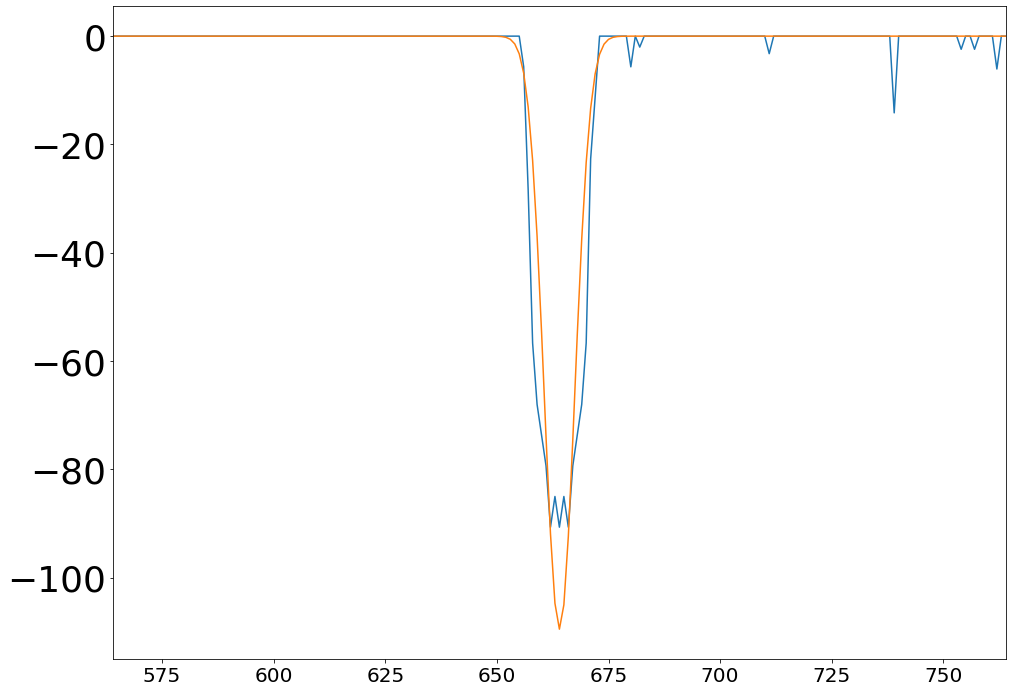

 27%|██▋       | 58/213 [00:08<00:23,  6.70it/s]

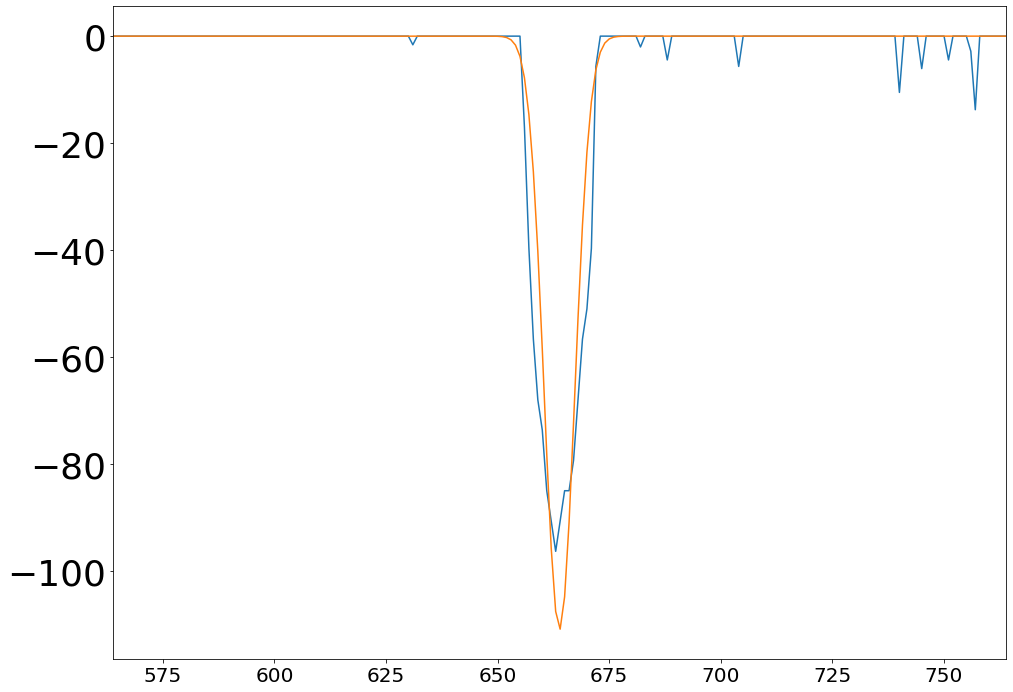

 28%|██▊       | 59/213 [00:09<00:23,  6.69it/s]

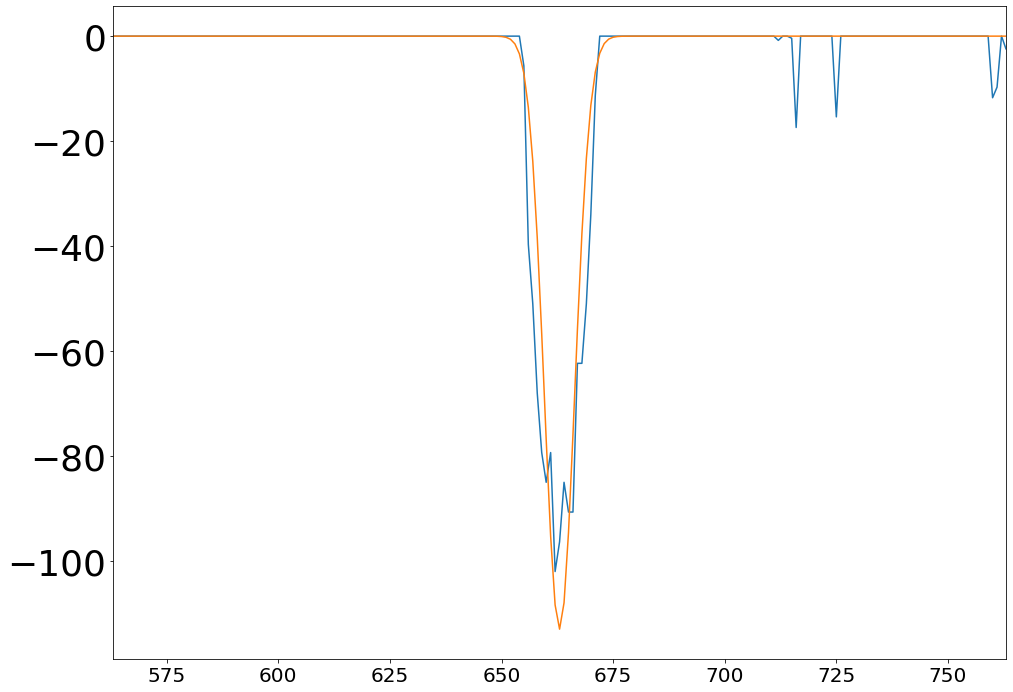

 28%|██▊       | 60/213 [00:09<00:22,  6.70it/s]

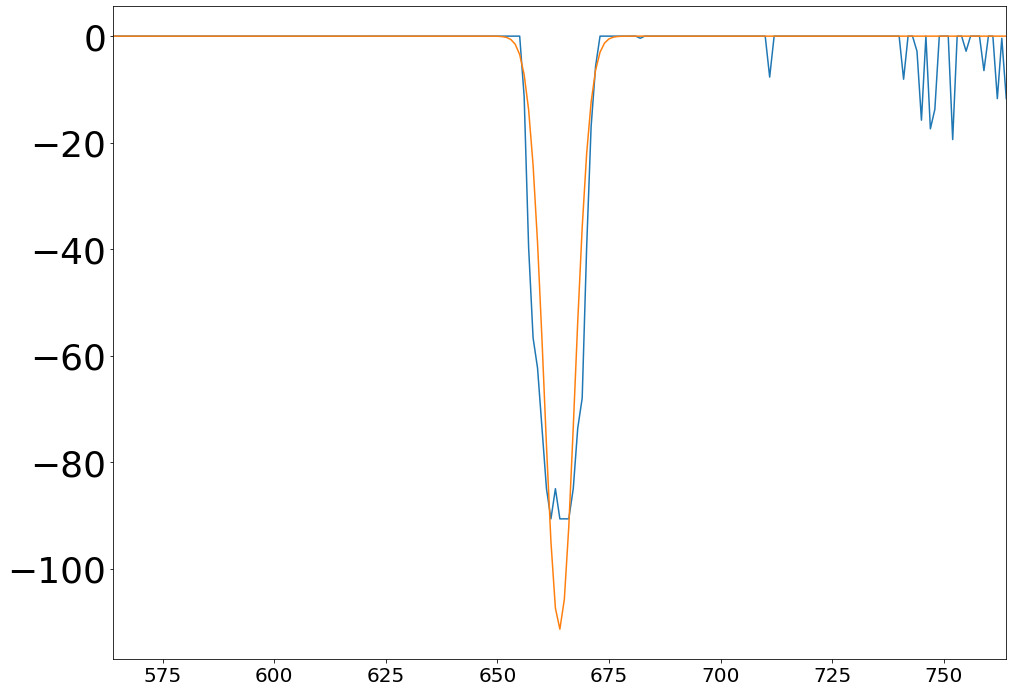

 29%|██▊       | 61/213 [00:09<00:22,  6.77it/s]

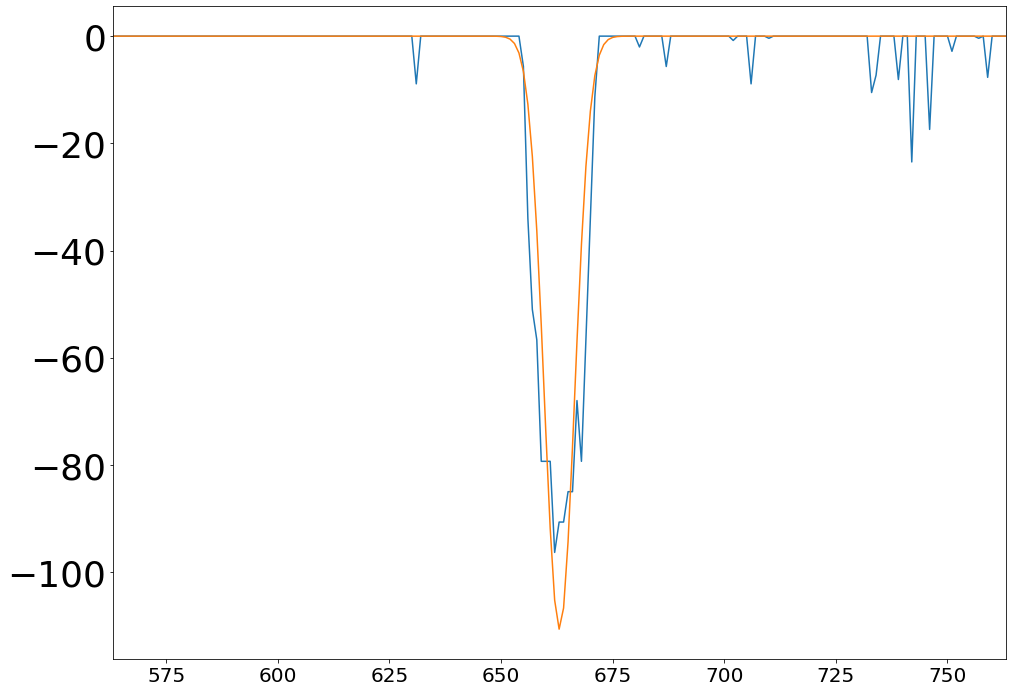

 29%|██▉       | 62/213 [00:09<00:22,  6.80it/s]

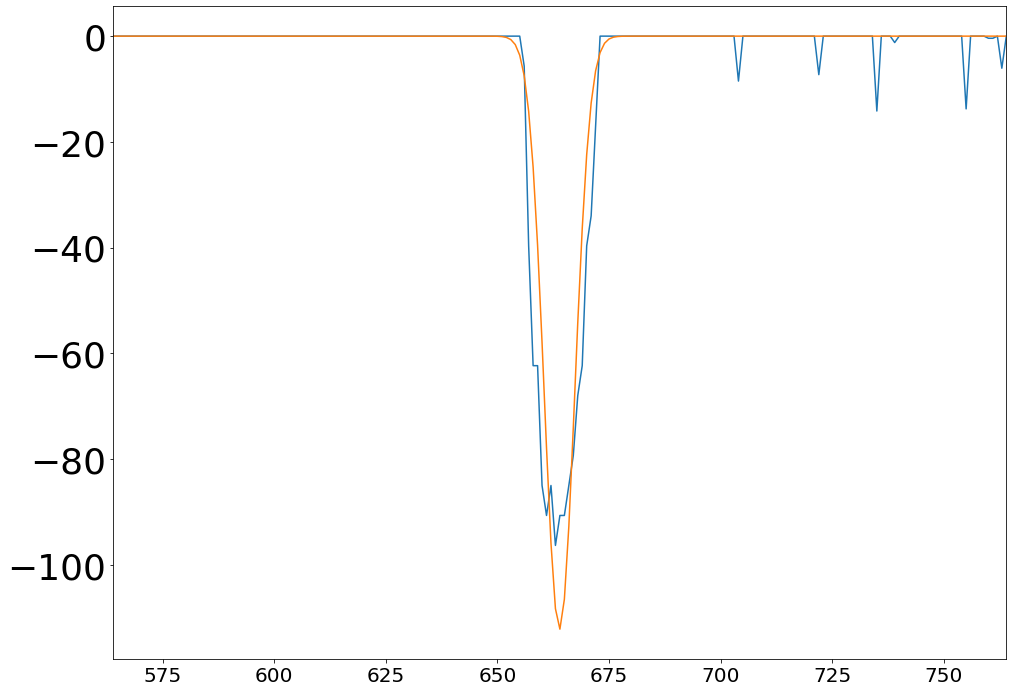

 30%|██▉       | 63/213 [00:09<00:21,  6.83it/s]

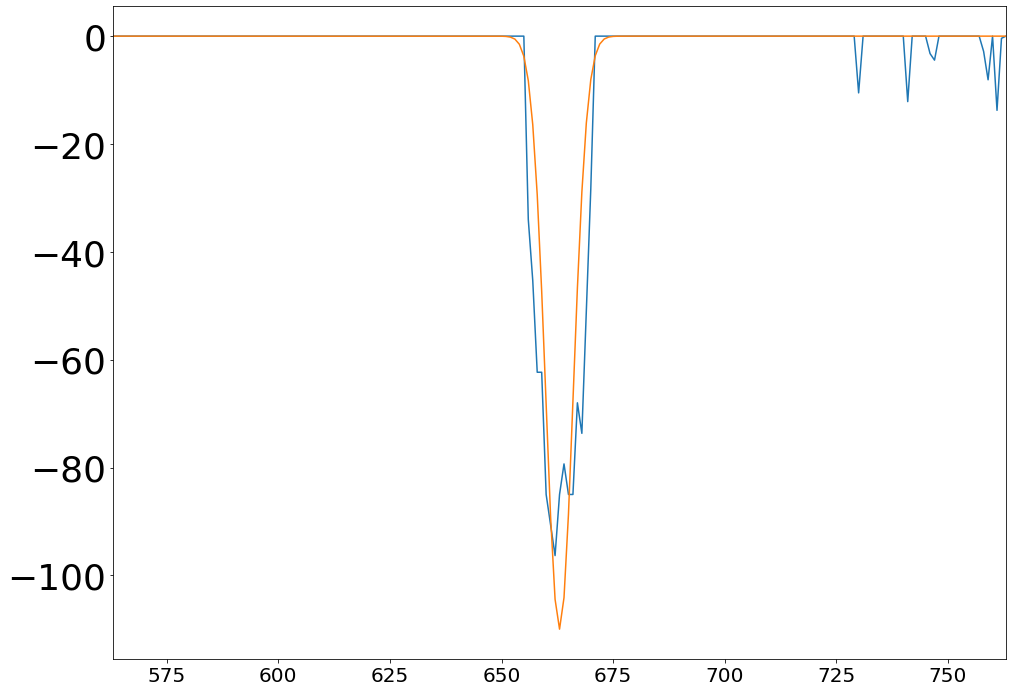

 30%|███       | 64/213 [00:09<00:21,  6.86it/s]

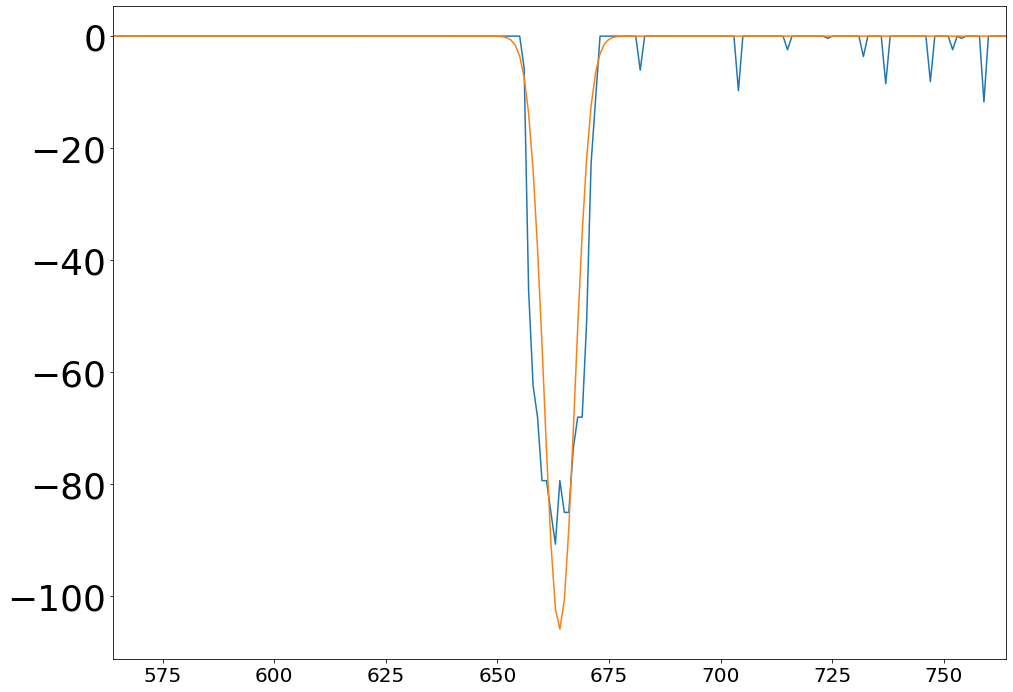

 31%|███       | 65/213 [00:09<00:23,  6.18it/s]

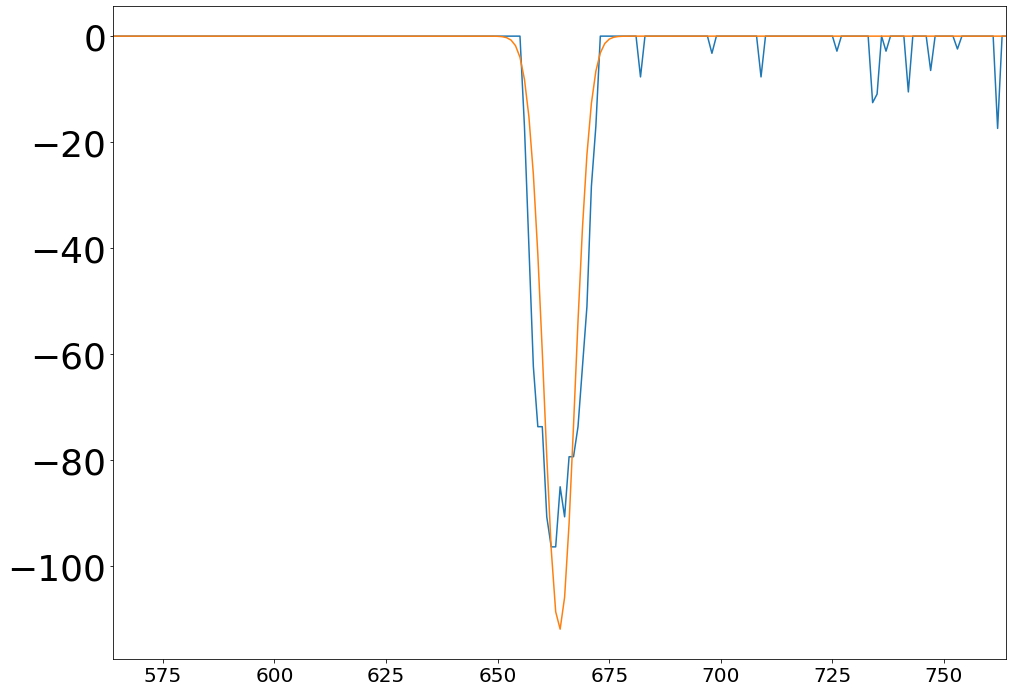

 31%|███       | 66/213 [00:10<00:23,  6.35it/s]

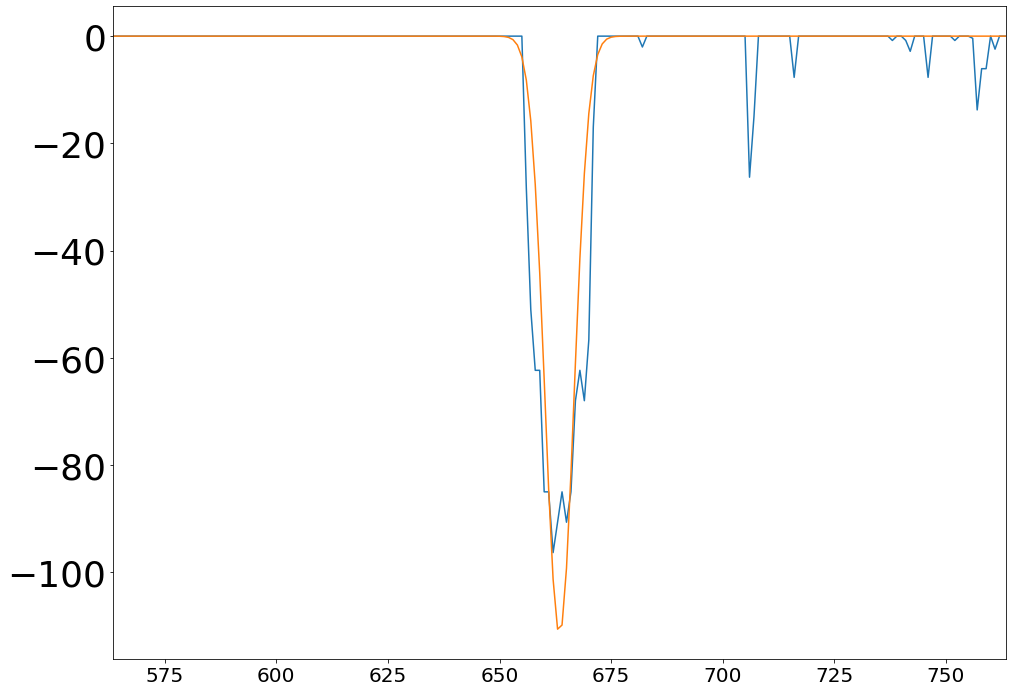

 31%|███▏      | 67/213 [00:10<00:22,  6.44it/s]

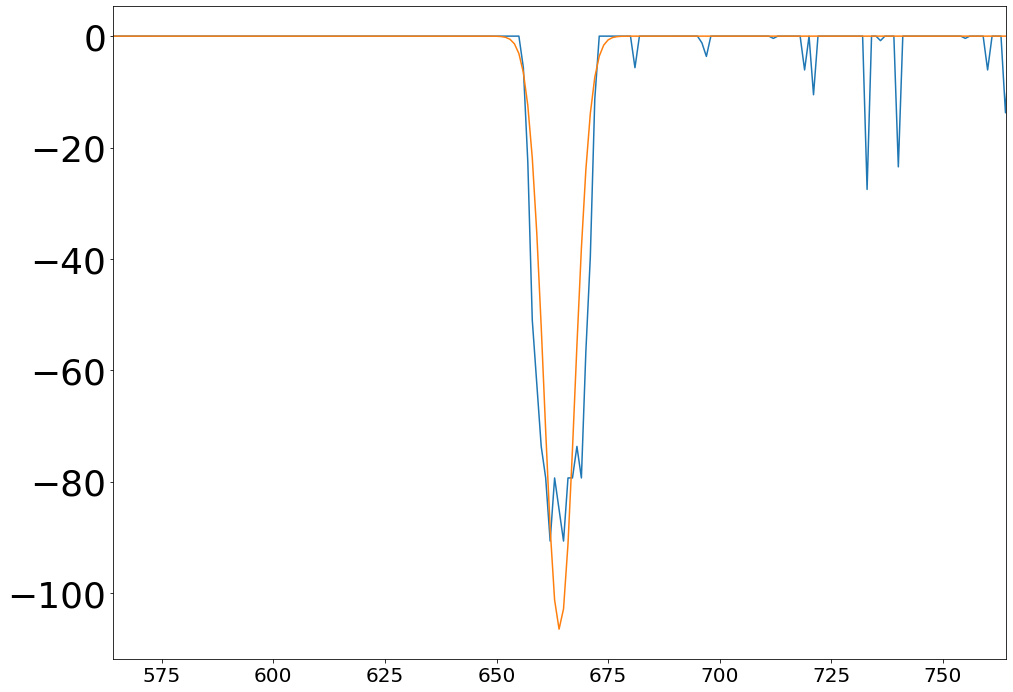

 32%|███▏      | 68/213 [00:10<00:22,  6.54it/s]

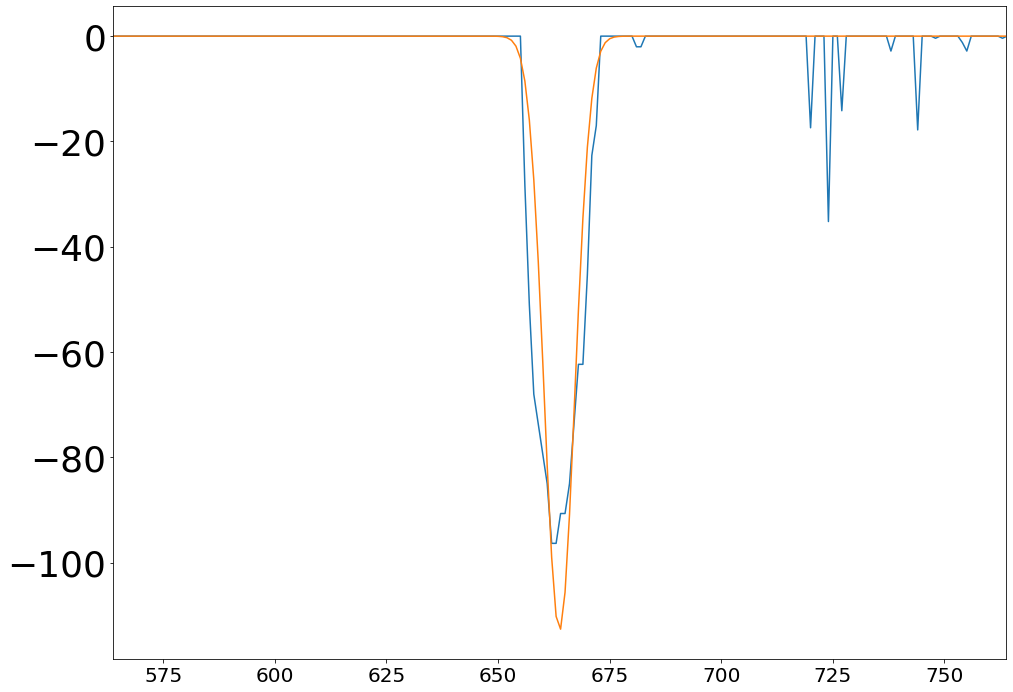

 32%|███▏      | 69/213 [00:10<00:21,  6.59it/s]

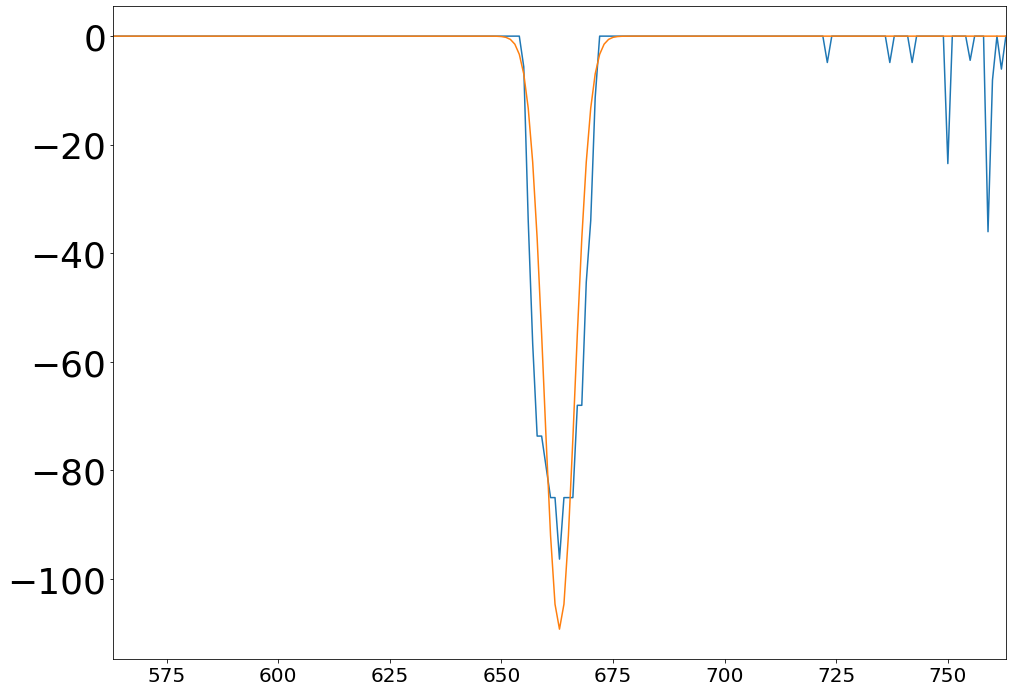

 33%|███▎      | 70/213 [00:10<00:21,  6.64it/s]

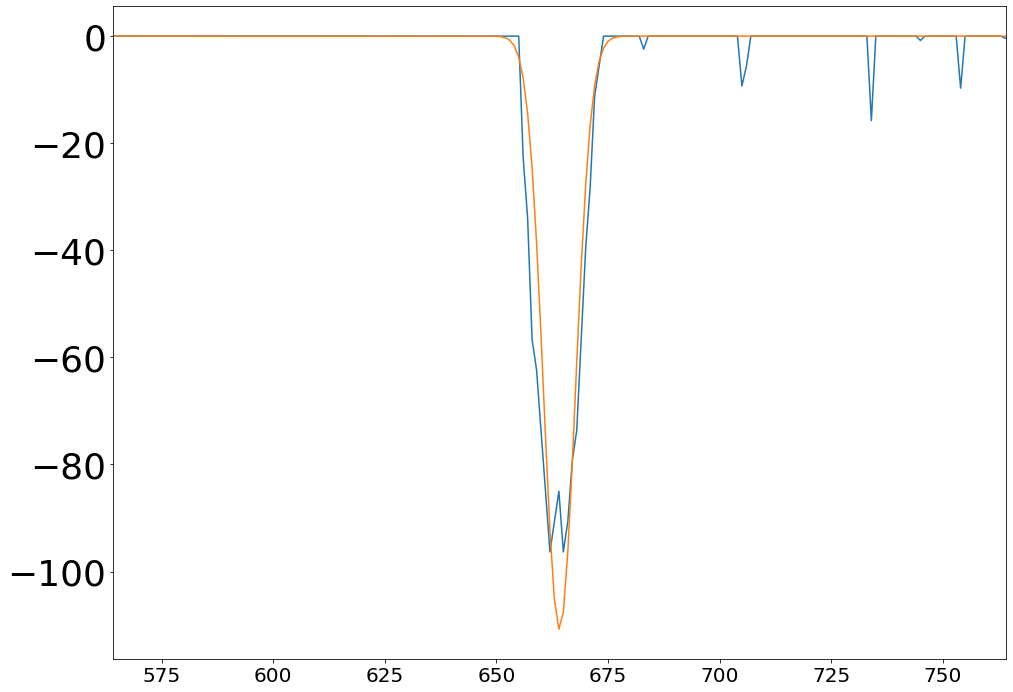

 33%|███▎      | 71/213 [00:10<00:21,  6.66it/s]

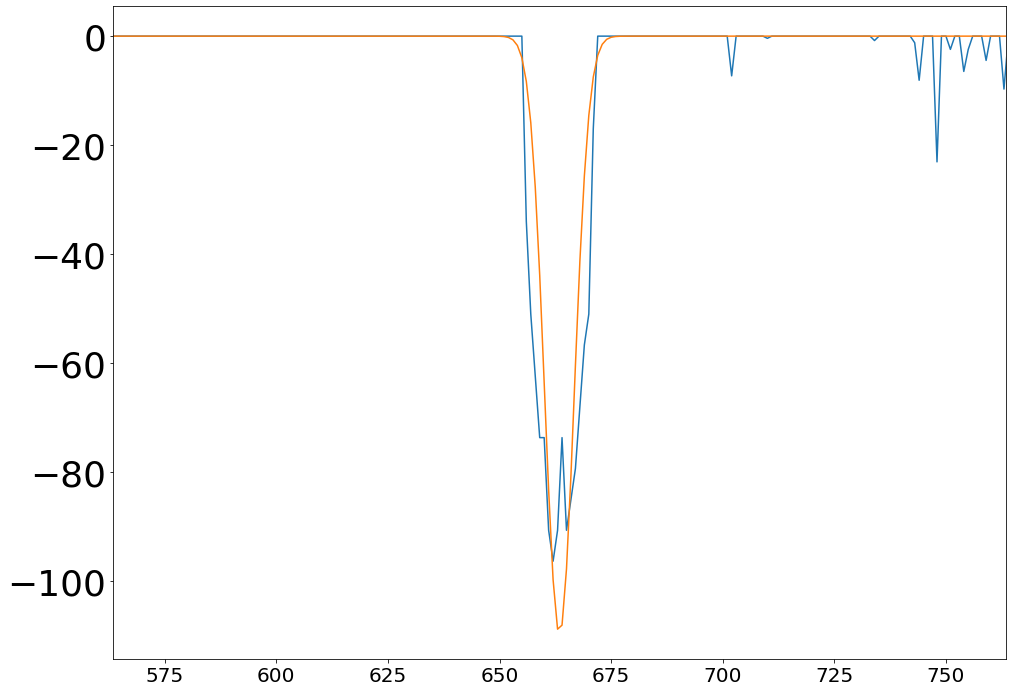

 34%|███▍      | 72/213 [00:11<00:21,  6.63it/s]

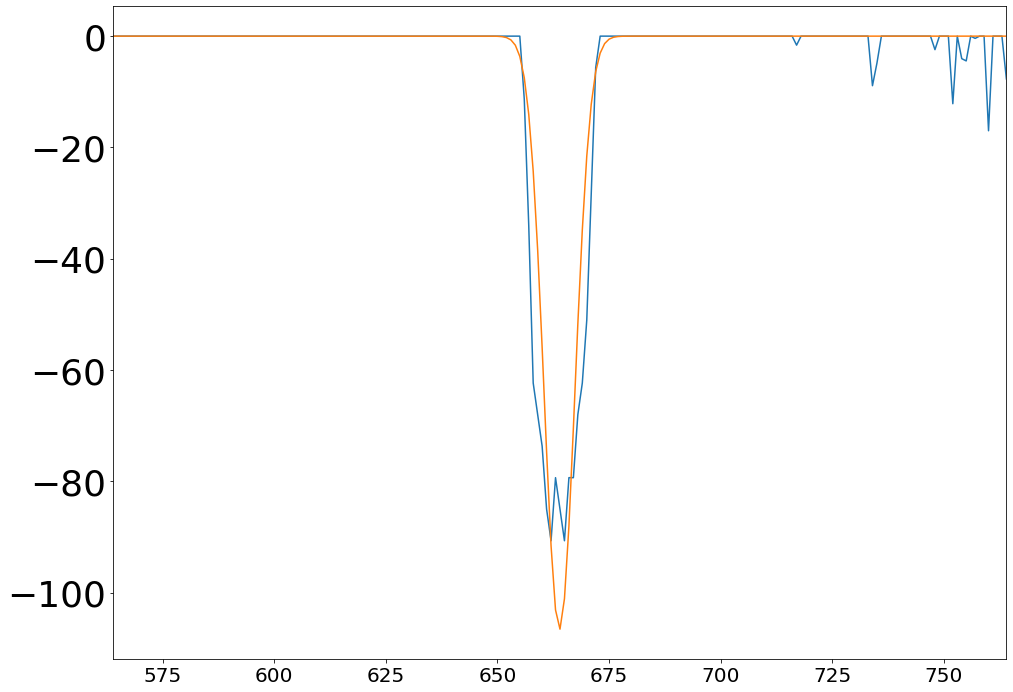

 34%|███▍      | 73/213 [00:11<00:21,  6.66it/s]

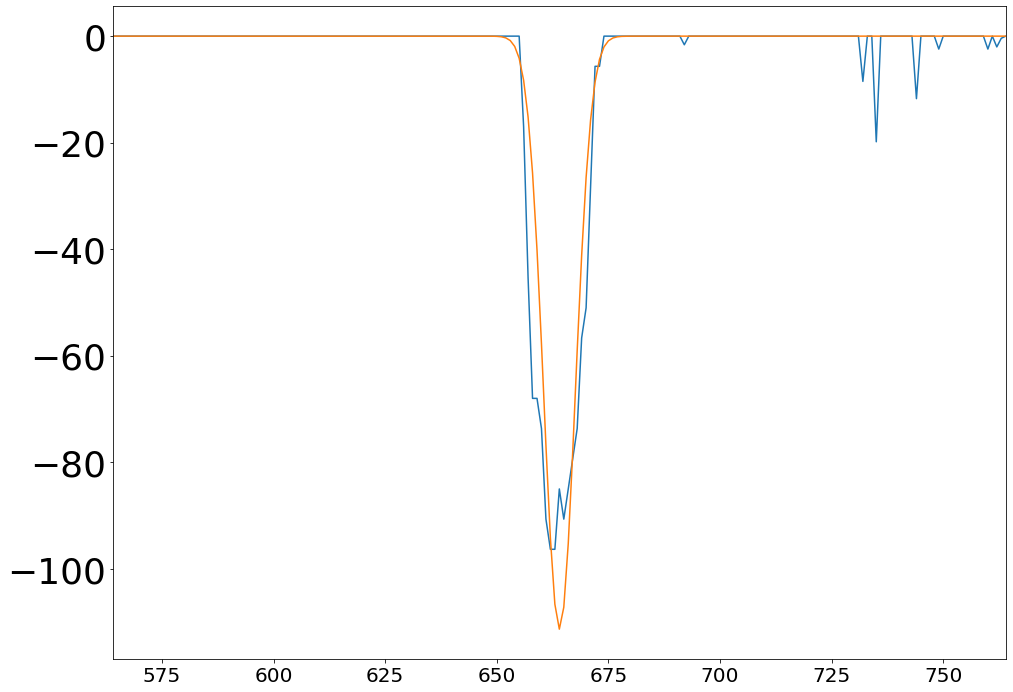

 35%|███▍      | 74/213 [00:11<00:20,  6.65it/s]

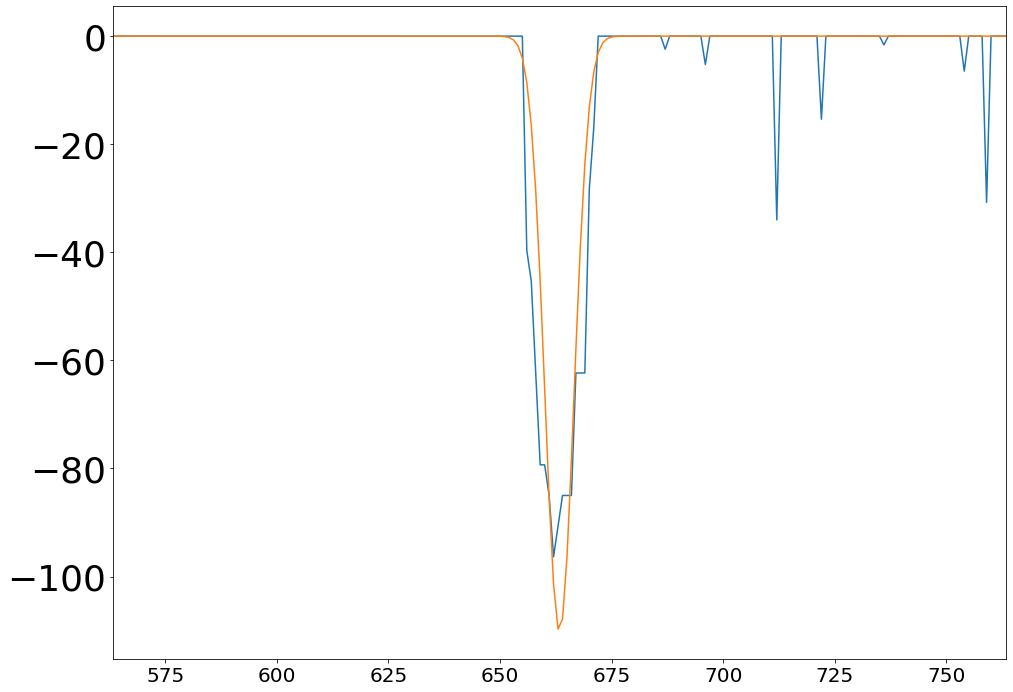

 35%|███▌      | 75/213 [00:11<00:20,  6.65it/s]

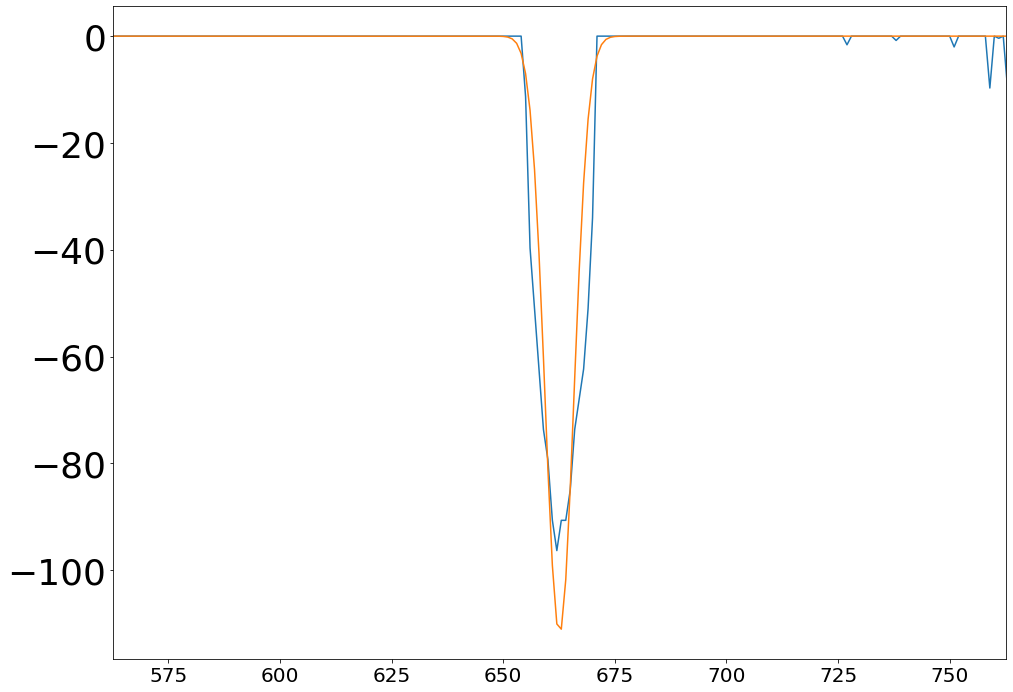

 36%|███▌      | 76/213 [00:11<00:20,  6.63it/s]

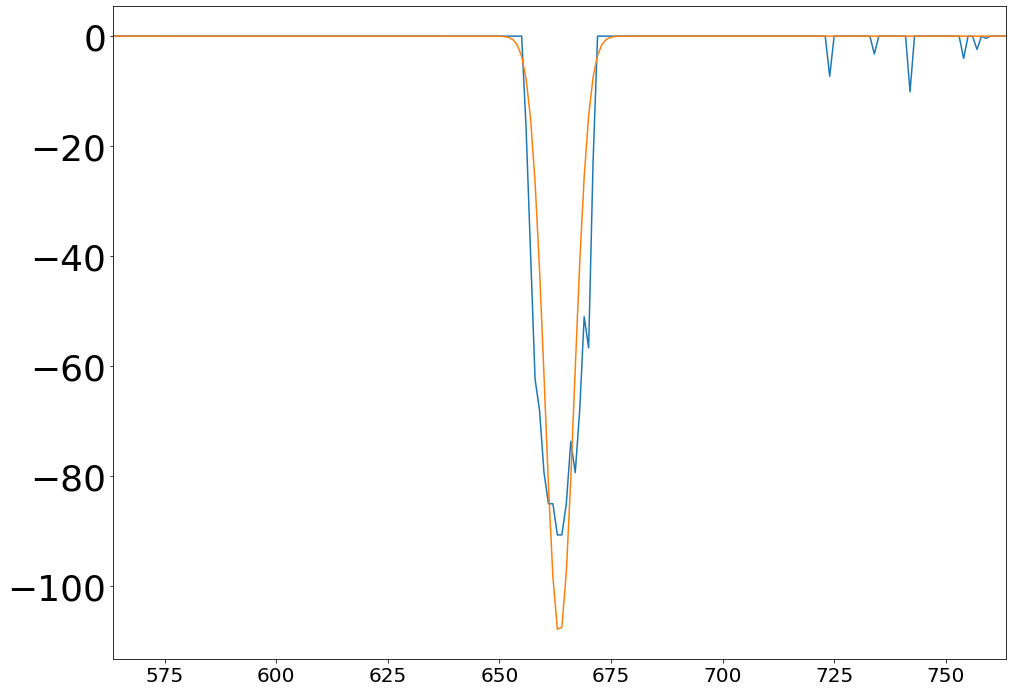

 36%|███▌      | 77/213 [00:11<00:20,  6.71it/s]

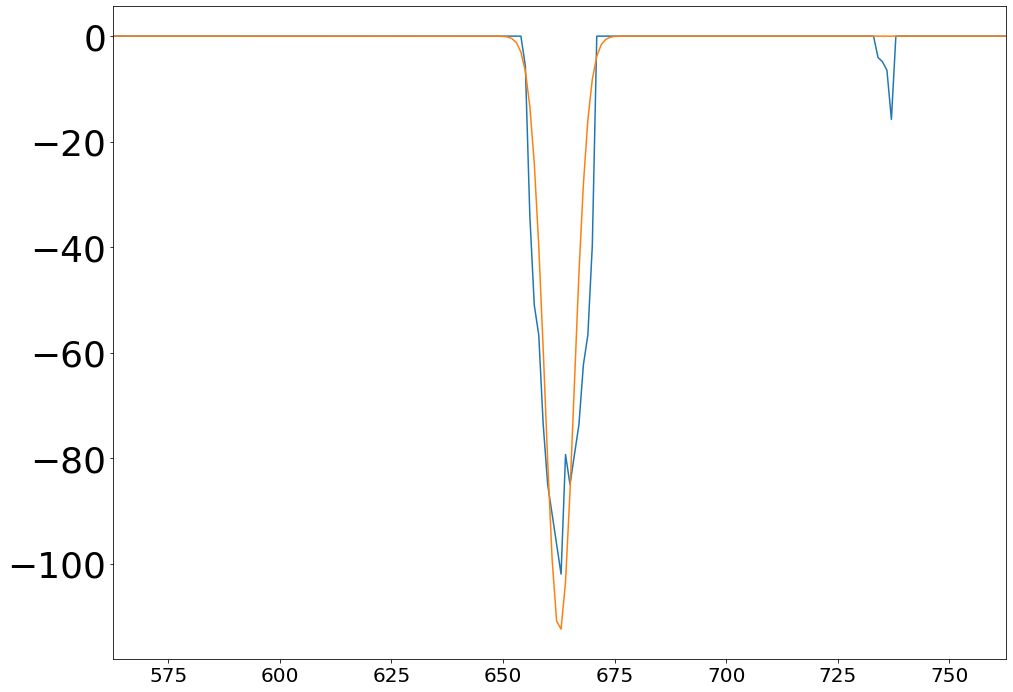

 37%|███▋      | 78/213 [00:11<00:22,  6.13it/s]

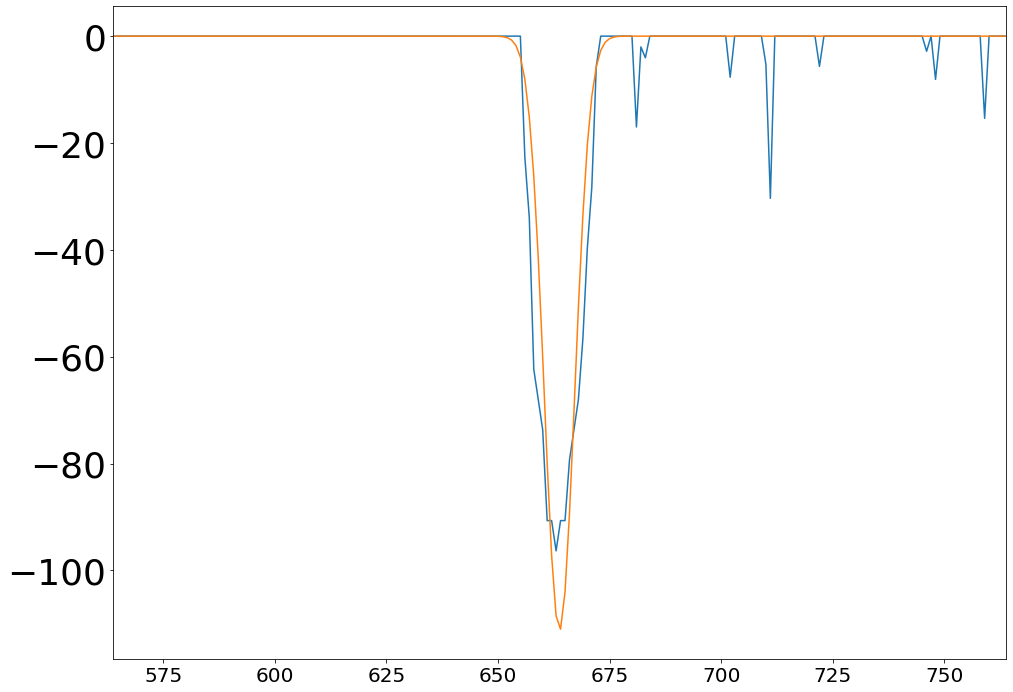

 37%|███▋      | 79/213 [00:12<00:21,  6.36it/s]

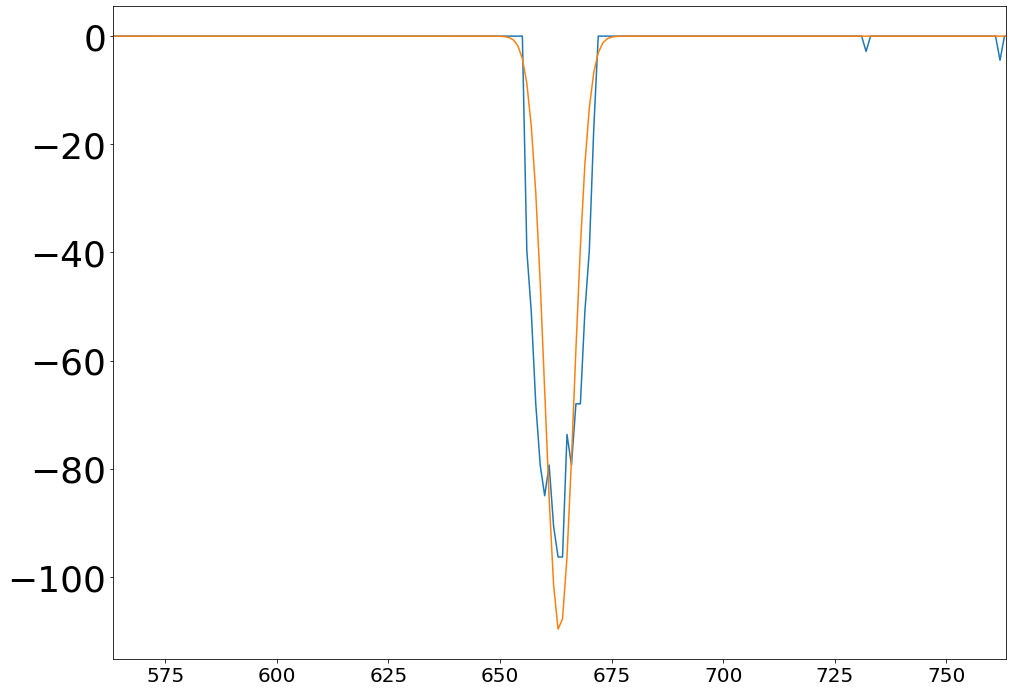

 38%|███▊      | 80/213 [00:12<00:20,  6.49it/s]

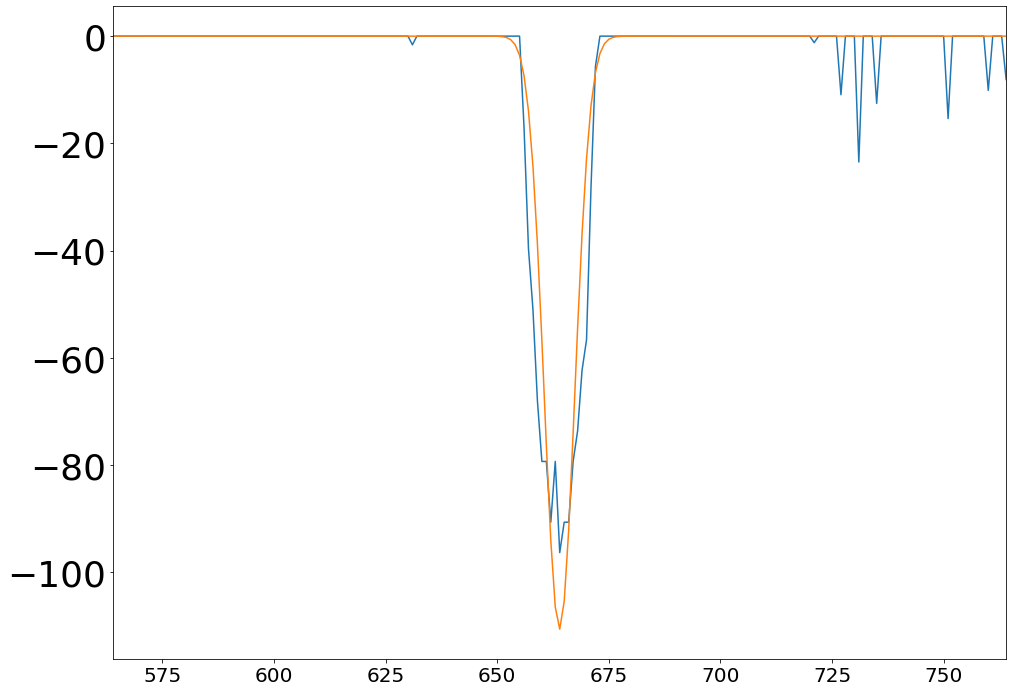

 38%|███▊      | 81/213 [00:12<00:19,  6.61it/s]

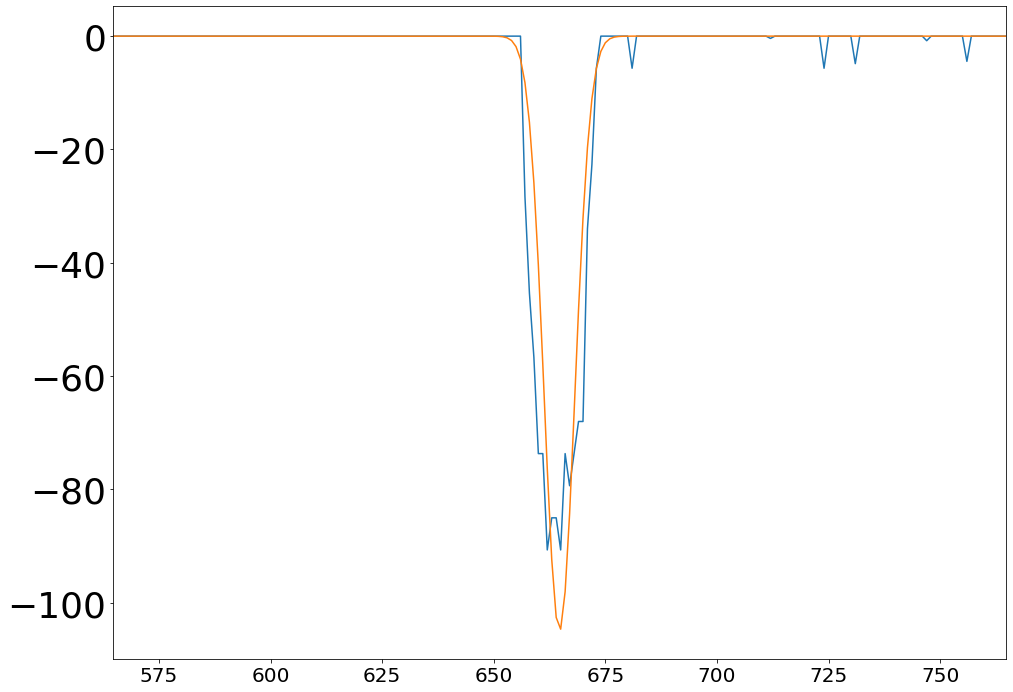

 38%|███▊      | 82/213 [00:12<00:19,  6.67it/s]

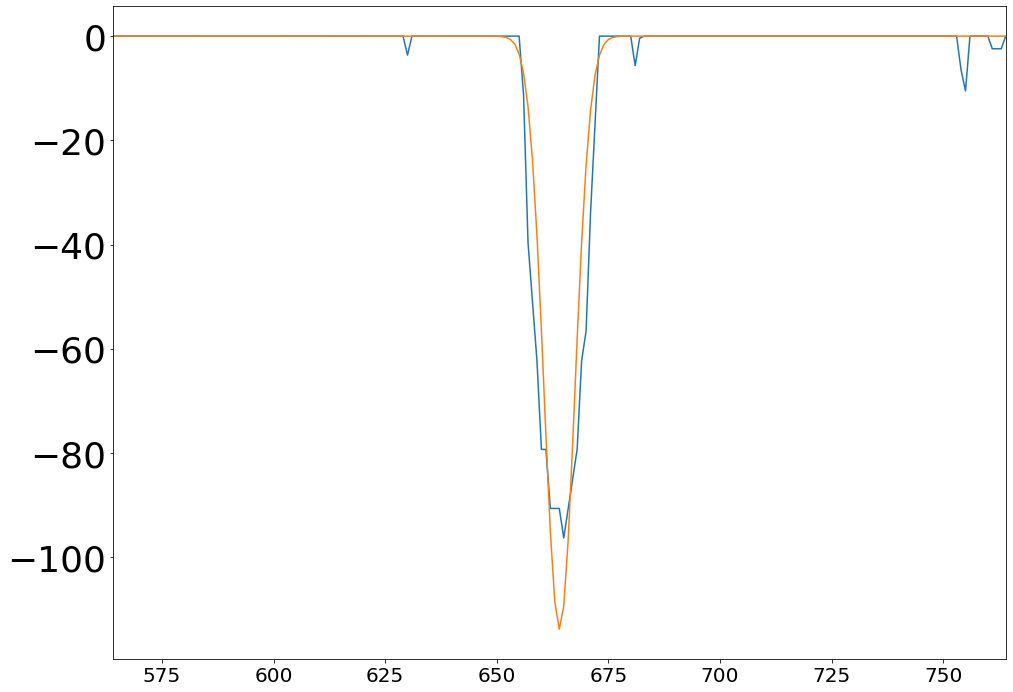

 39%|███▉      | 83/213 [00:12<00:19,  6.71it/s]

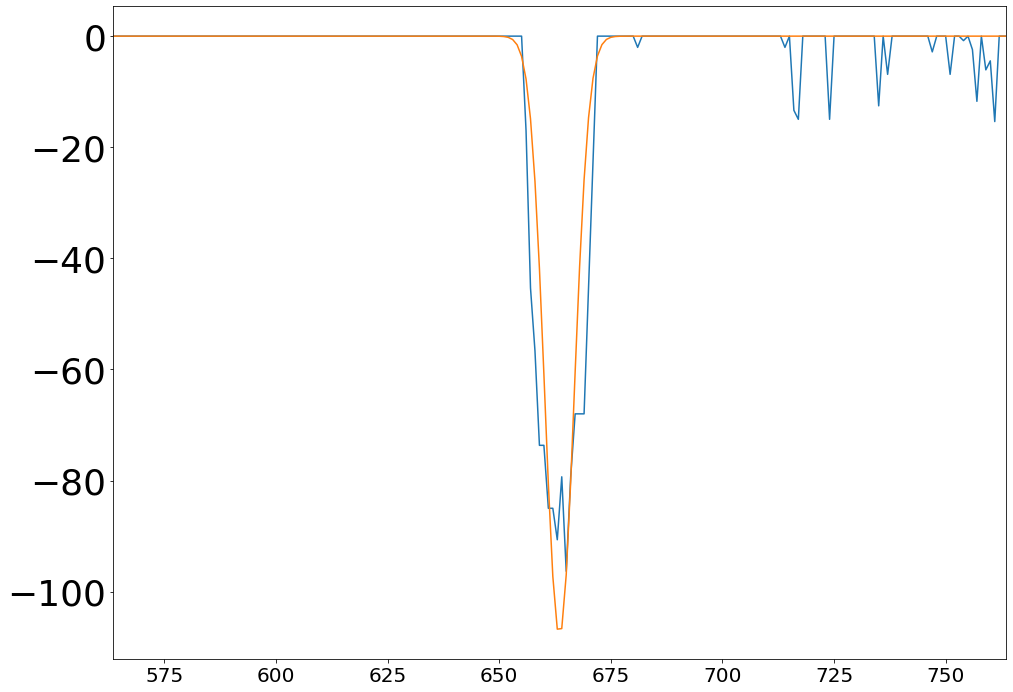

 39%|███▉      | 84/213 [00:12<00:19,  6.71it/s]

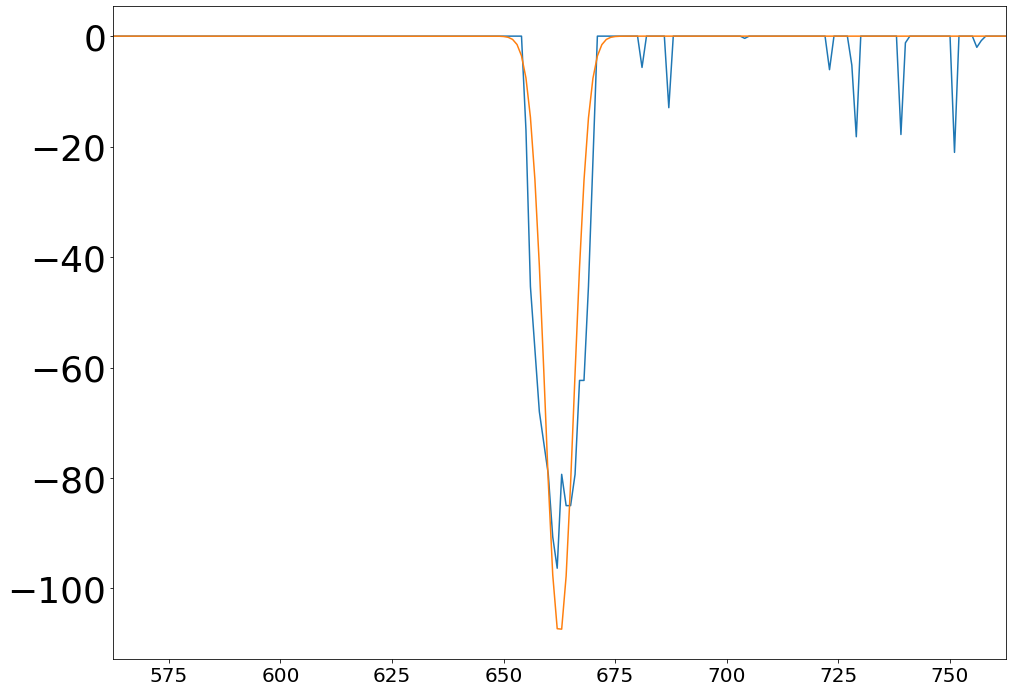

 40%|███▉      | 85/213 [00:12<00:18,  6.74it/s]

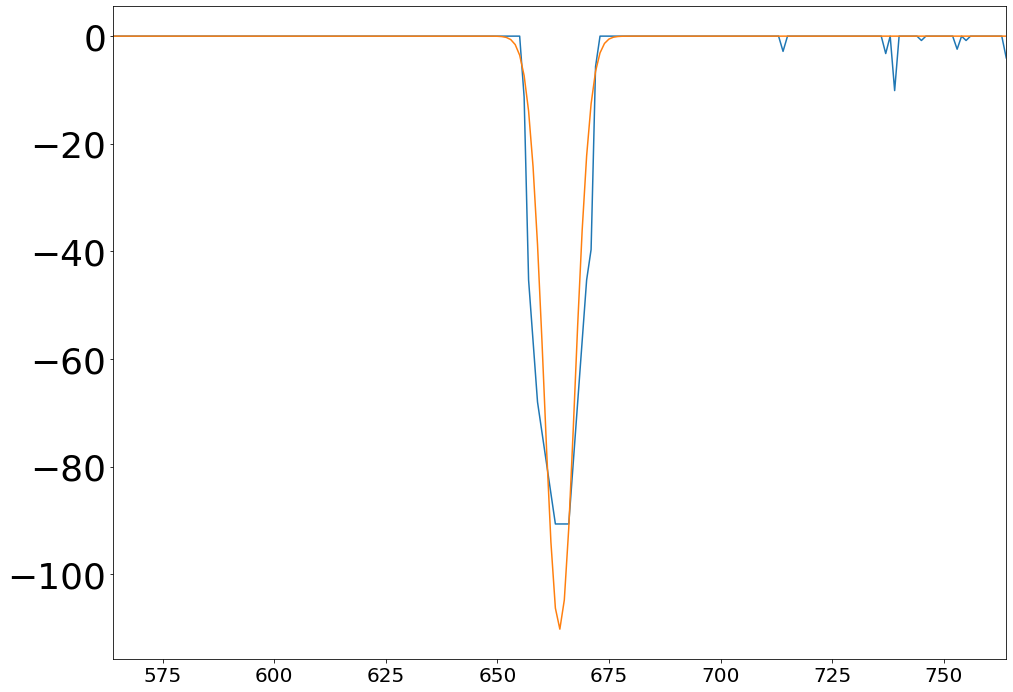

 40%|████      | 86/213 [00:13<00:18,  6.76it/s]

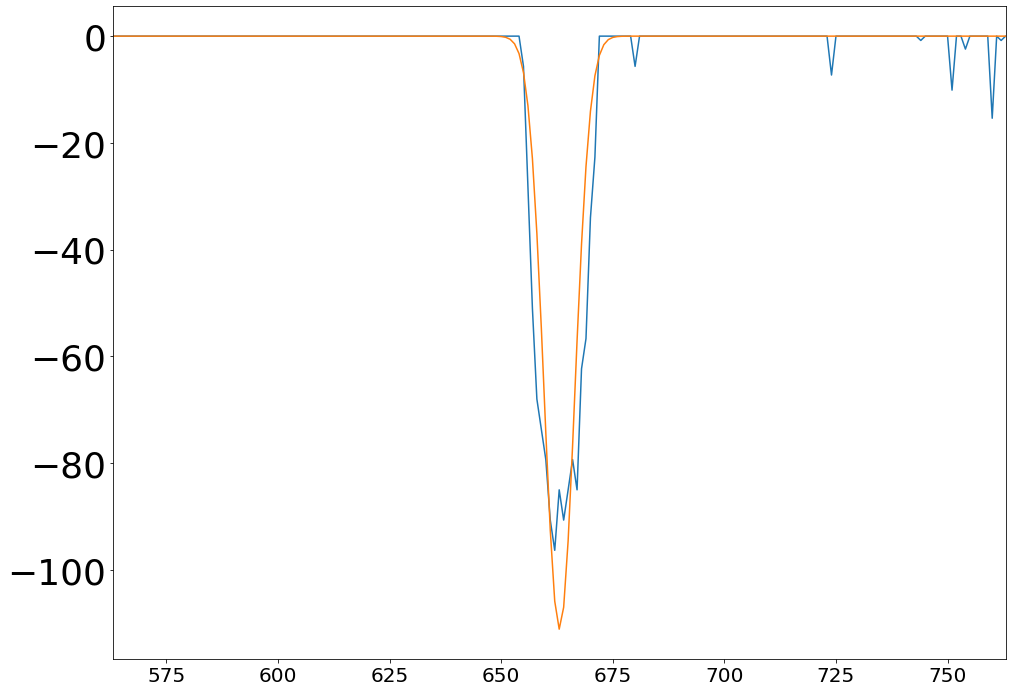

 41%|████      | 87/213 [00:13<00:18,  6.71it/s]

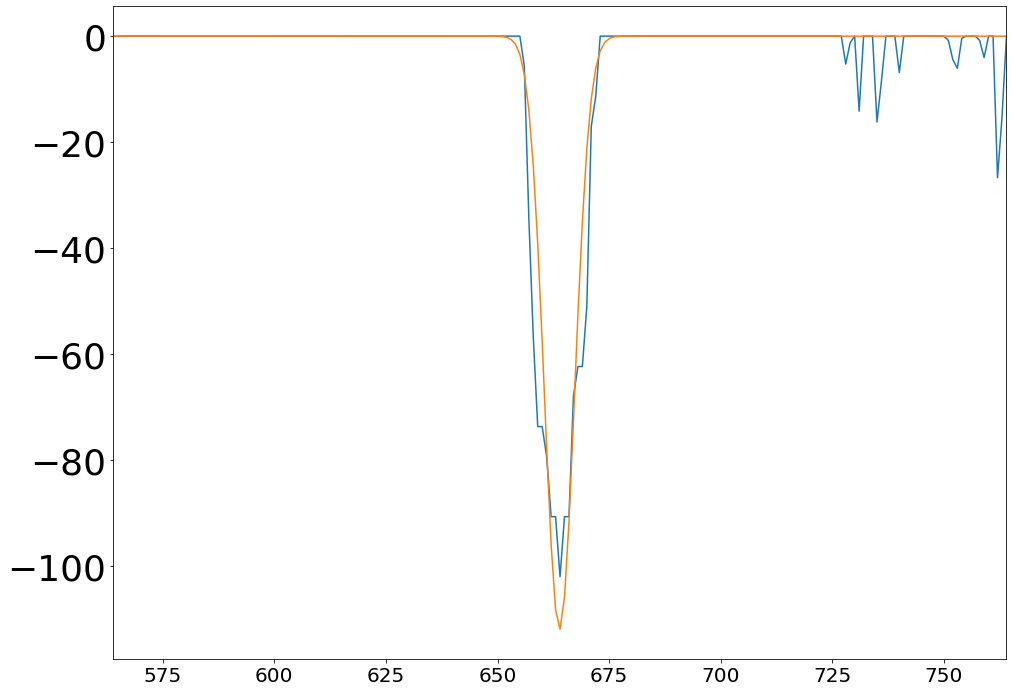

 41%|████▏     | 88/213 [00:13<00:18,  6.73it/s]

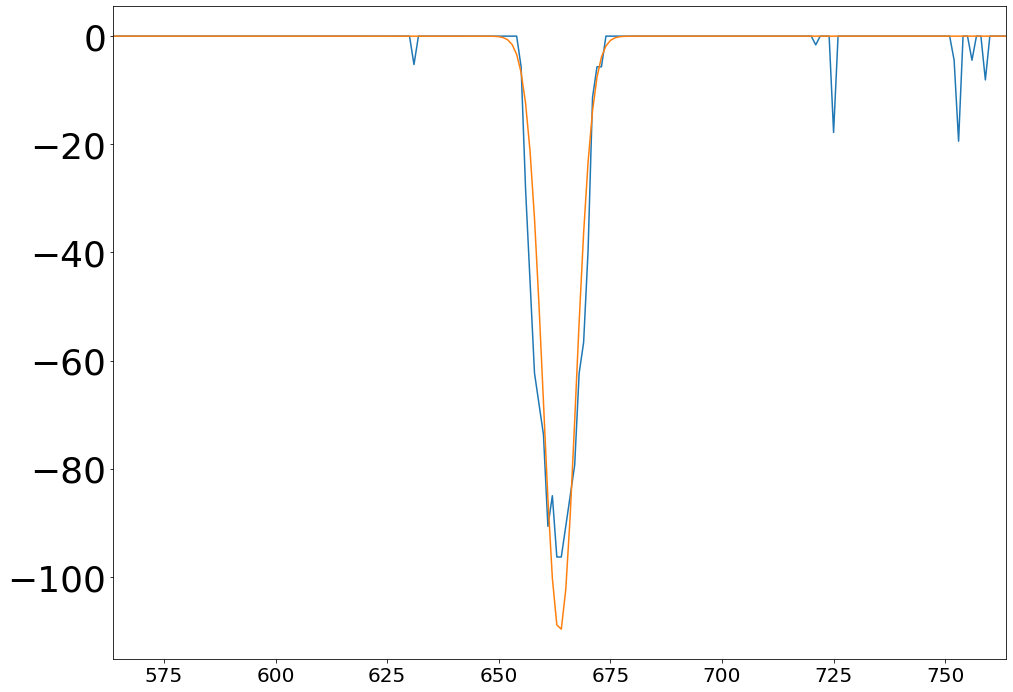

 42%|████▏     | 89/213 [00:13<00:18,  6.72it/s]

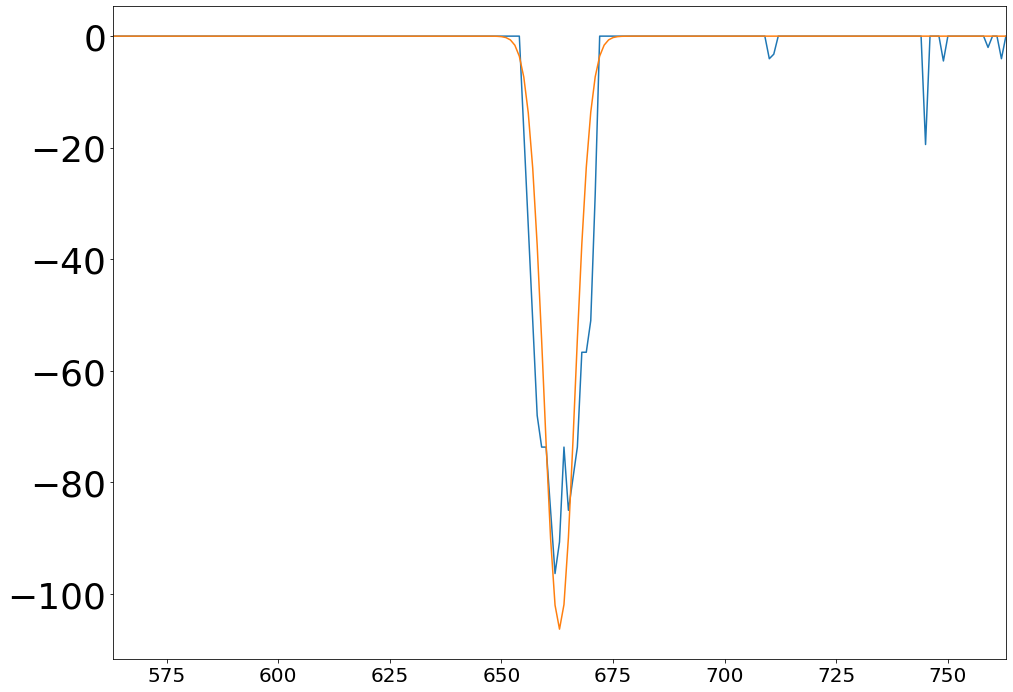

 42%|████▏     | 90/213 [00:13<00:18,  6.70it/s]

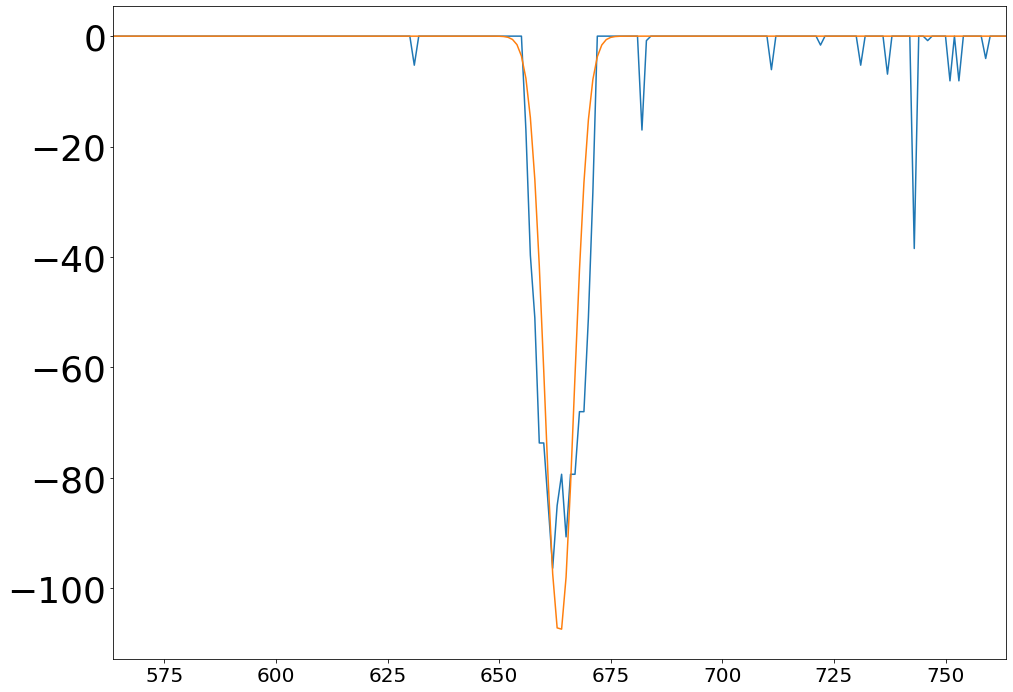

 43%|████▎     | 91/213 [00:13<00:19,  6.12it/s]

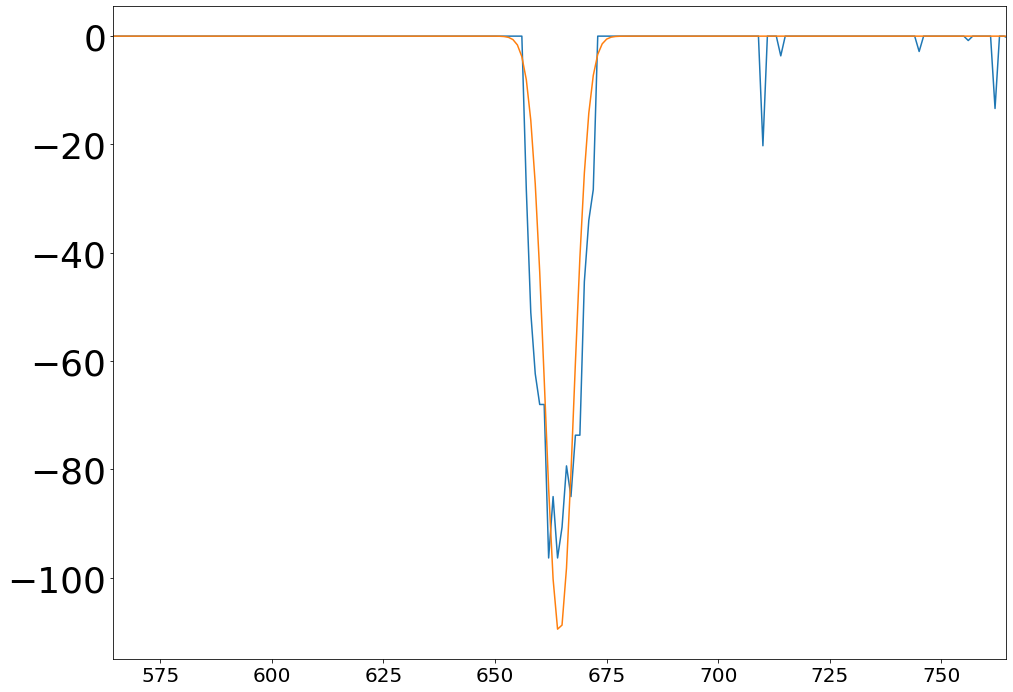

 43%|████▎     | 92/213 [00:14<00:19,  6.27it/s]

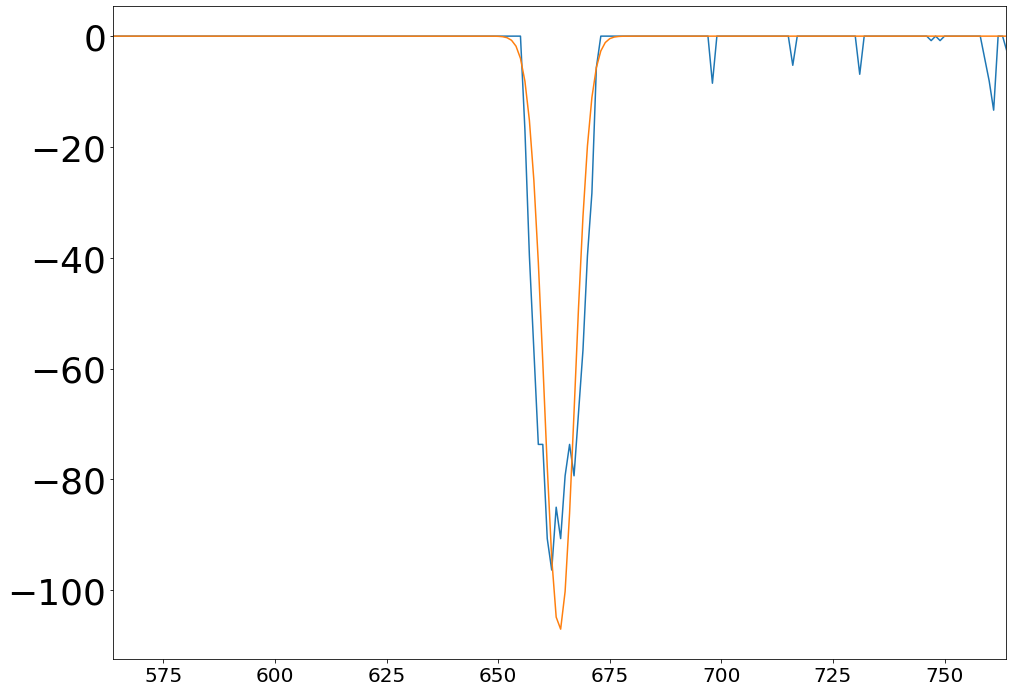

 44%|████▎     | 93/213 [00:14<00:18,  6.43it/s]

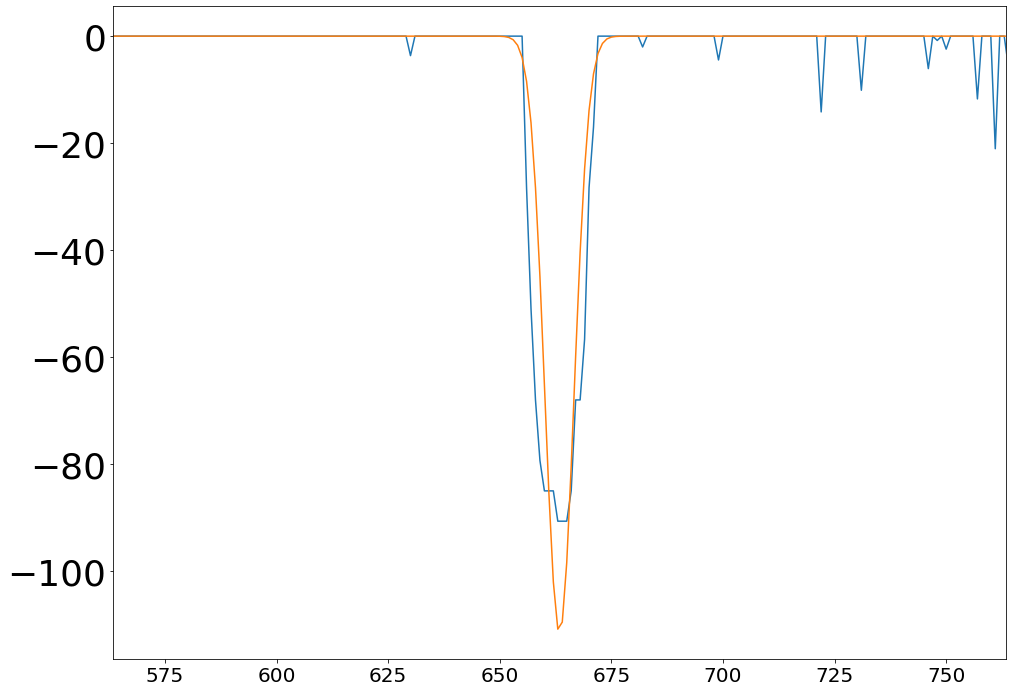

 44%|████▍     | 94/213 [00:14<00:18,  6.55it/s]

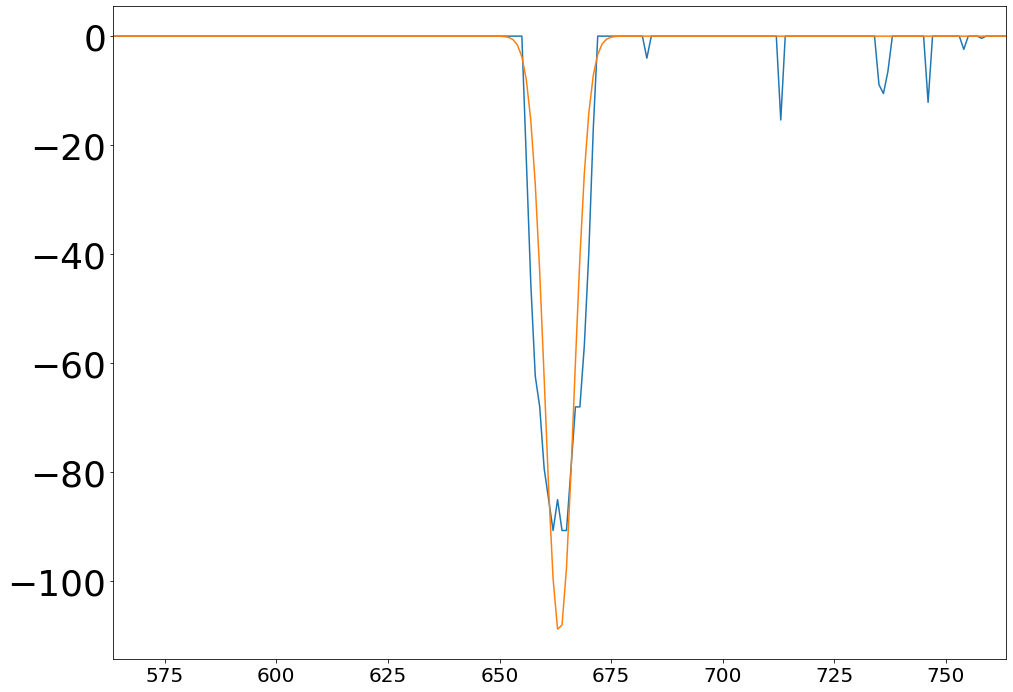

 45%|████▍     | 95/213 [00:14<00:17,  6.65it/s]

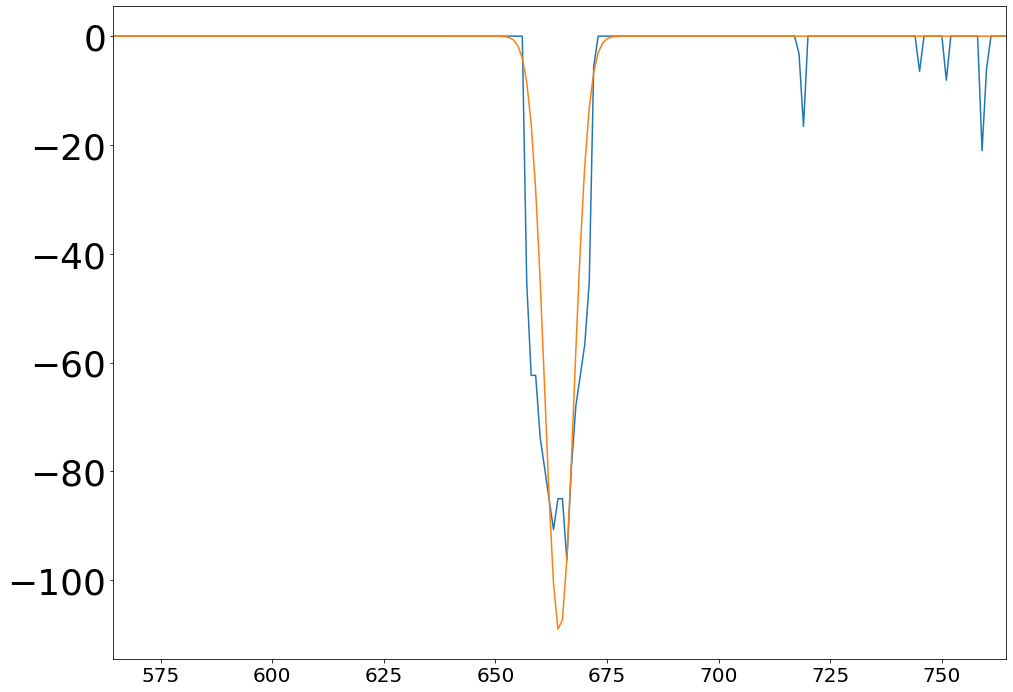

 45%|████▌     | 96/213 [00:14<00:17,  6.73it/s]

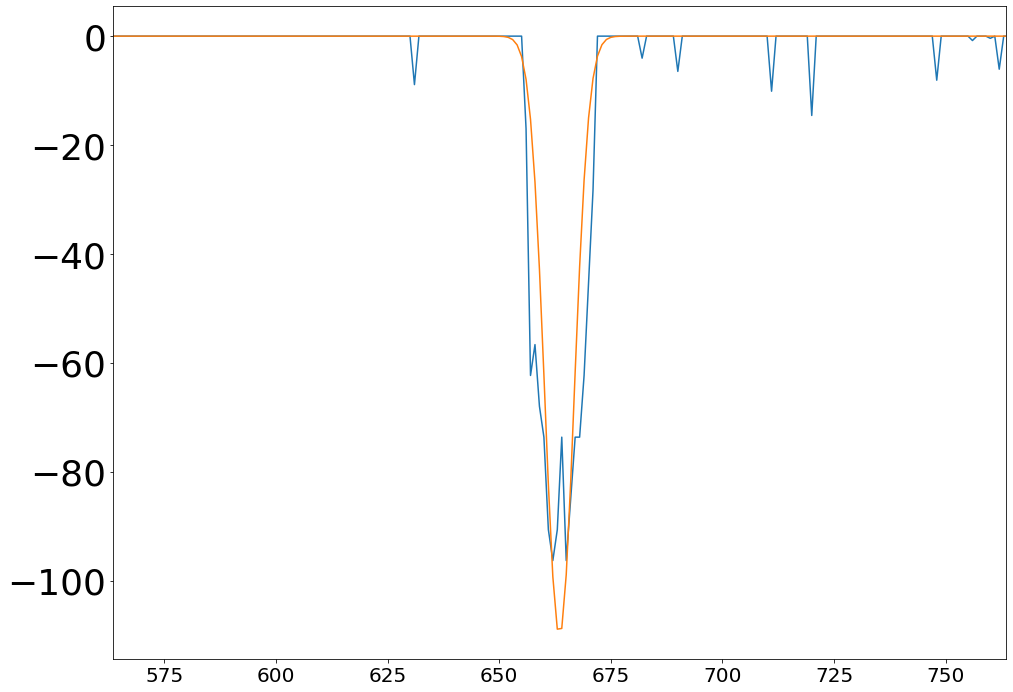

 46%|████▌     | 97/213 [00:14<00:17,  6.62it/s]

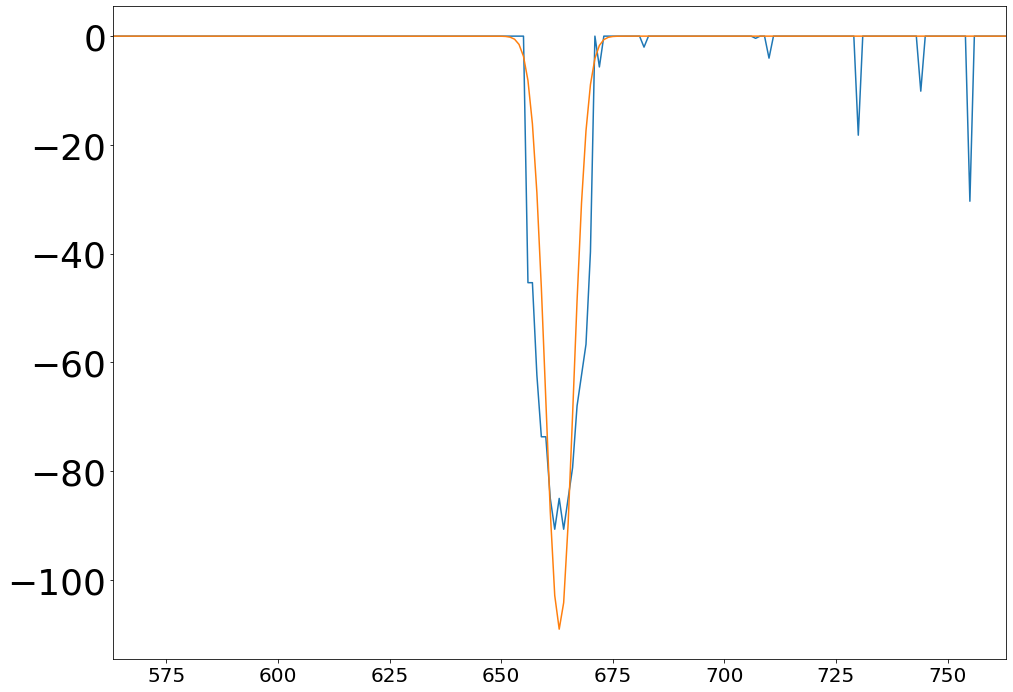

 46%|████▌     | 98/213 [00:14<00:17,  6.66it/s]

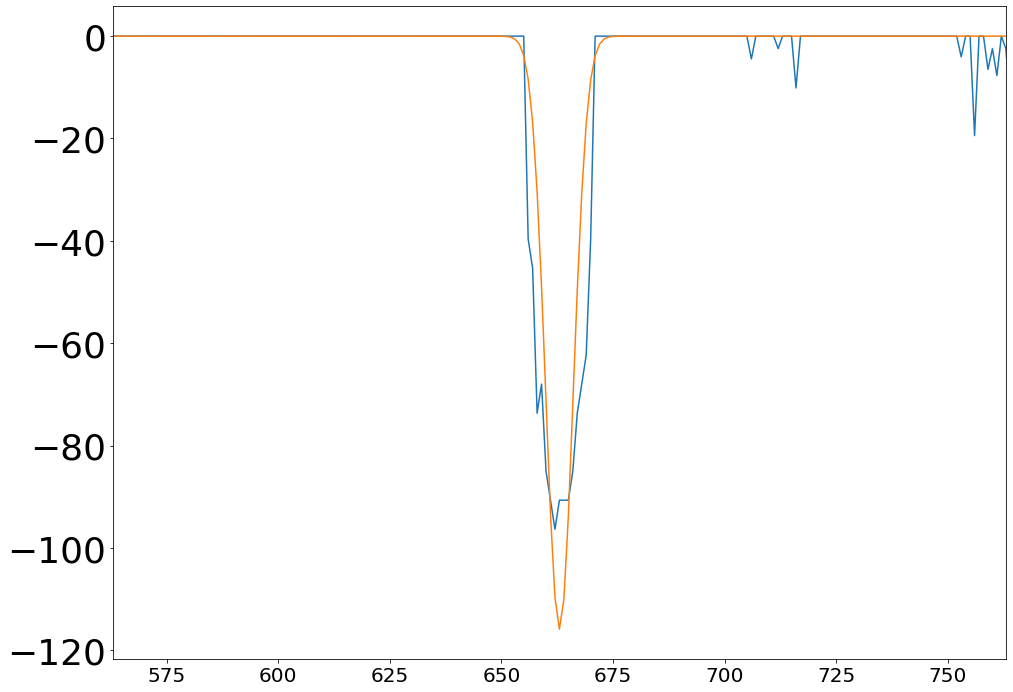

 46%|████▋     | 99/213 [00:15<00:17,  6.65it/s]

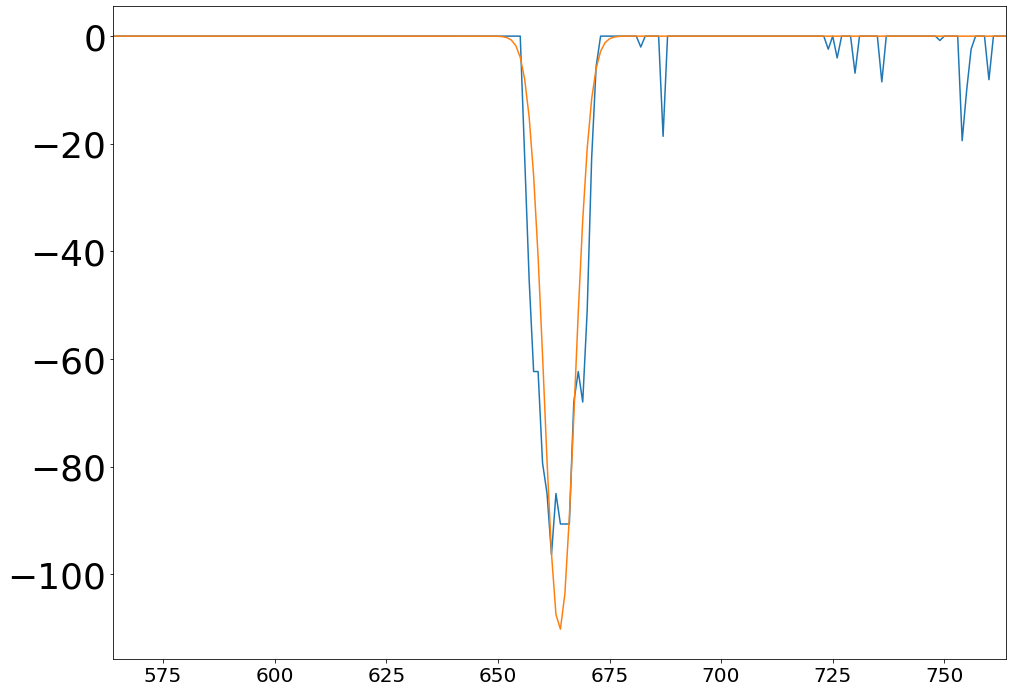

 47%|████▋     | 100/213 [00:15<00:16,  6.71it/s]

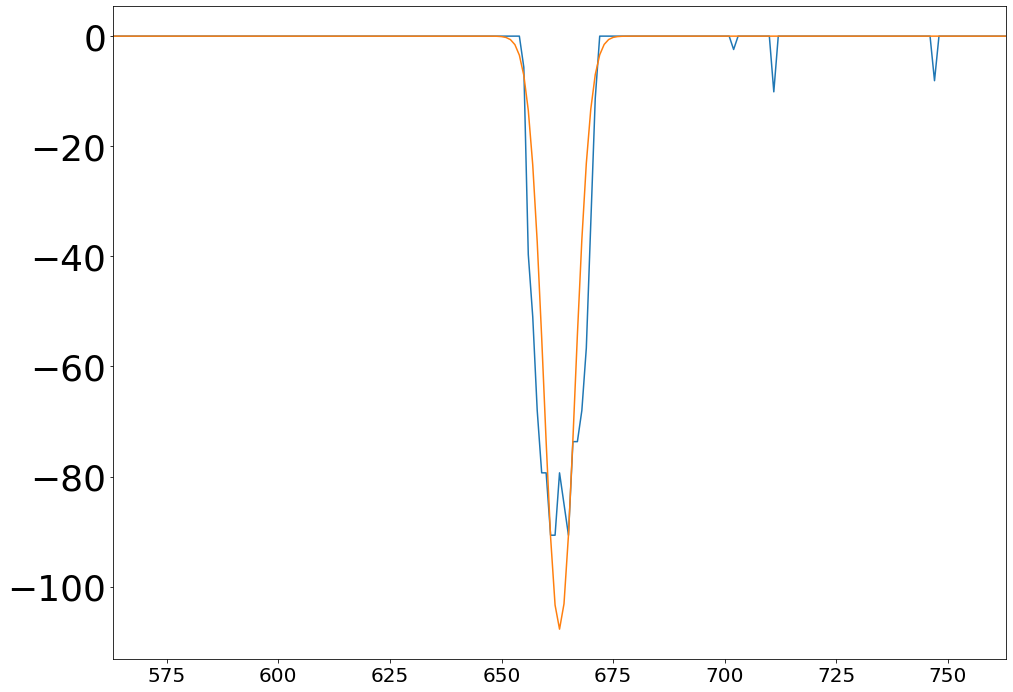

 47%|████▋     | 101/213 [00:15<00:16,  6.74it/s]

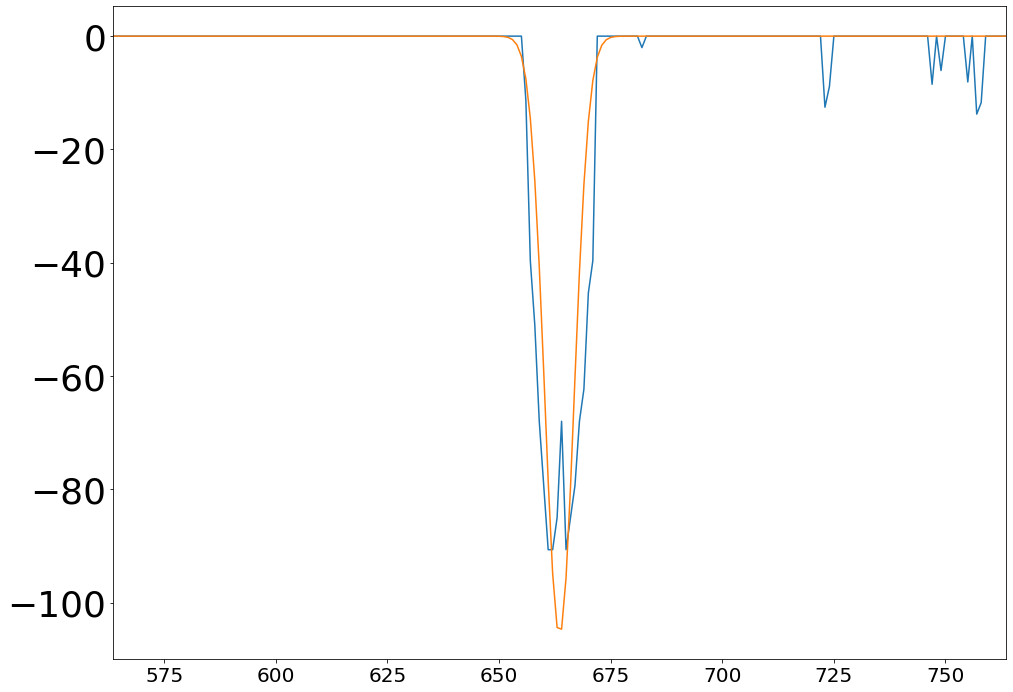

 48%|████▊     | 102/213 [00:15<00:16,  6.80it/s]

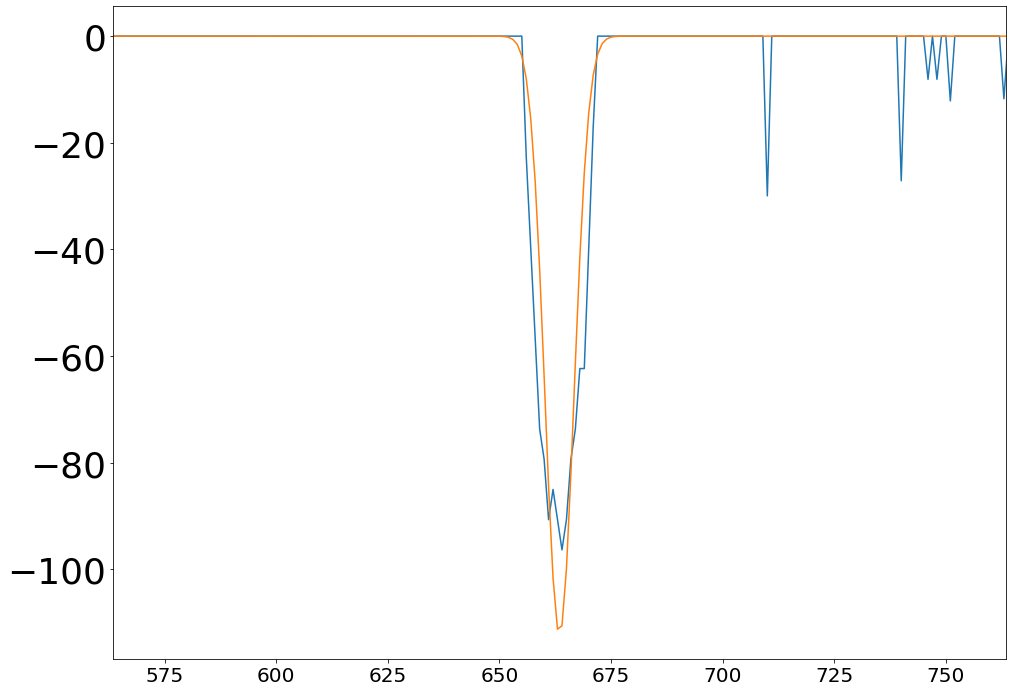

 48%|████▊     | 103/213 [00:15<00:16,  6.82it/s]

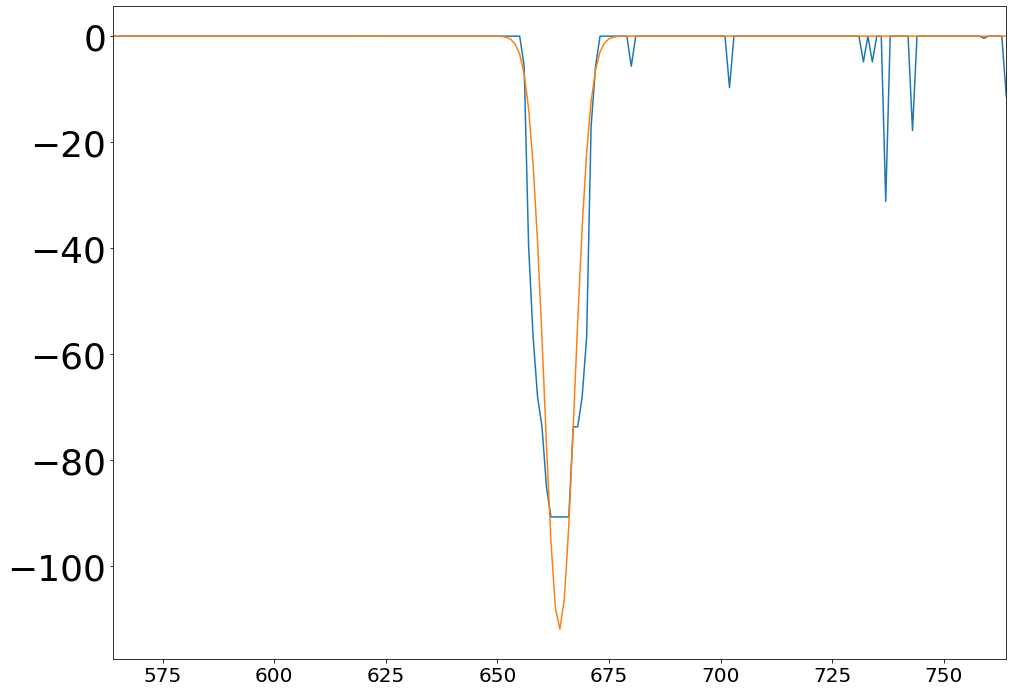

 49%|████▉     | 104/213 [00:15<00:17,  6.21it/s]

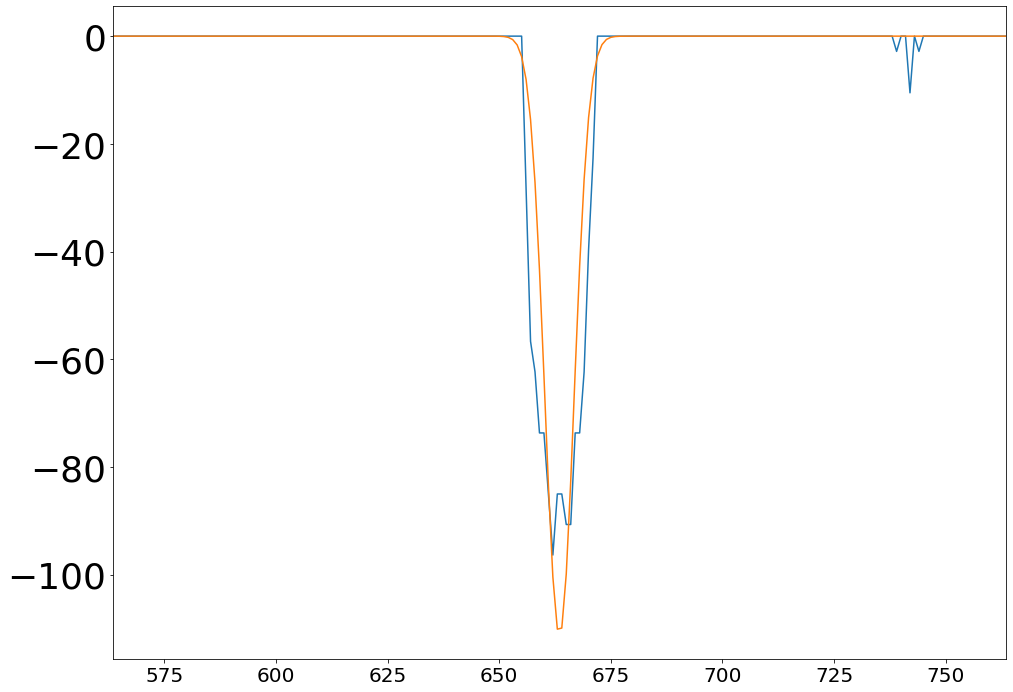

 49%|████▉     | 105/213 [00:16<00:16,  6.40it/s]

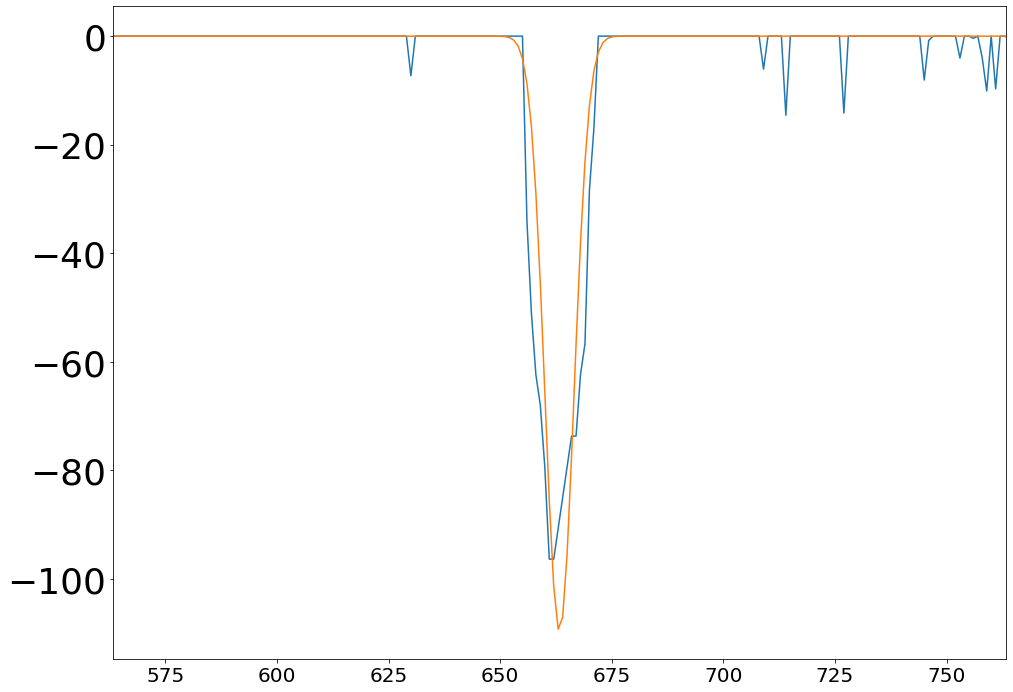

 50%|████▉     | 106/213 [00:16<00:16,  6.50it/s]

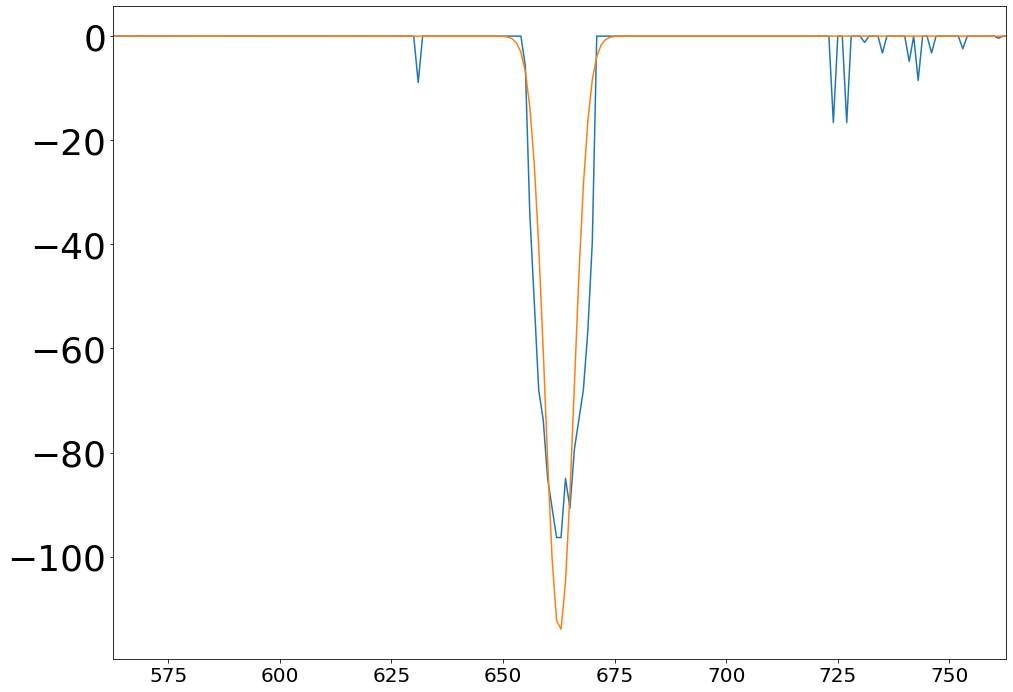

 50%|█████     | 107/213 [00:16<00:16,  6.56it/s]

KeyboardInterrupt: 

In [9]:
height = [] # get the height using the shadow method
fl=[]
for i in tqdm(np.arange(825,len(data),5)):
    mean, m = imp_from_shadow_image_to_height(data[i],120,area_low_limits=[600,730],area_widths=[45,70],flb=600,fub=750,plot=True)
    height.append(pixel_to_height(mean,calibration=True,pix_size_from_calib=pixel_size_cal))
    #print(m.values["sigma"])
    plt.show()

In [ ]:
plt.plot(height)

In [18]:
vl = []
for elements in fl[5]: 
    if(elements<0): 
        value=elements 
    else: value=0
    vl.append(value)        

IndexError: list index out of range

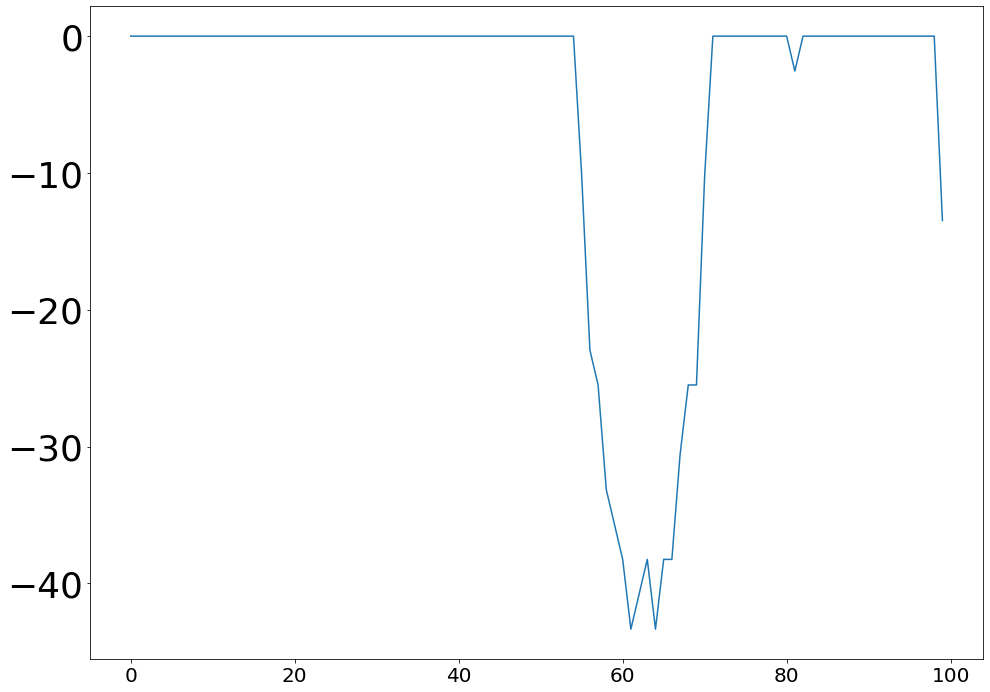

In [205]:
plt.plot(vl[600:700])

In [169]:
plt.plot(fl[fl[0][600:800]<0])

TypeError: only integer scalar arrays can be converted to a scalar index

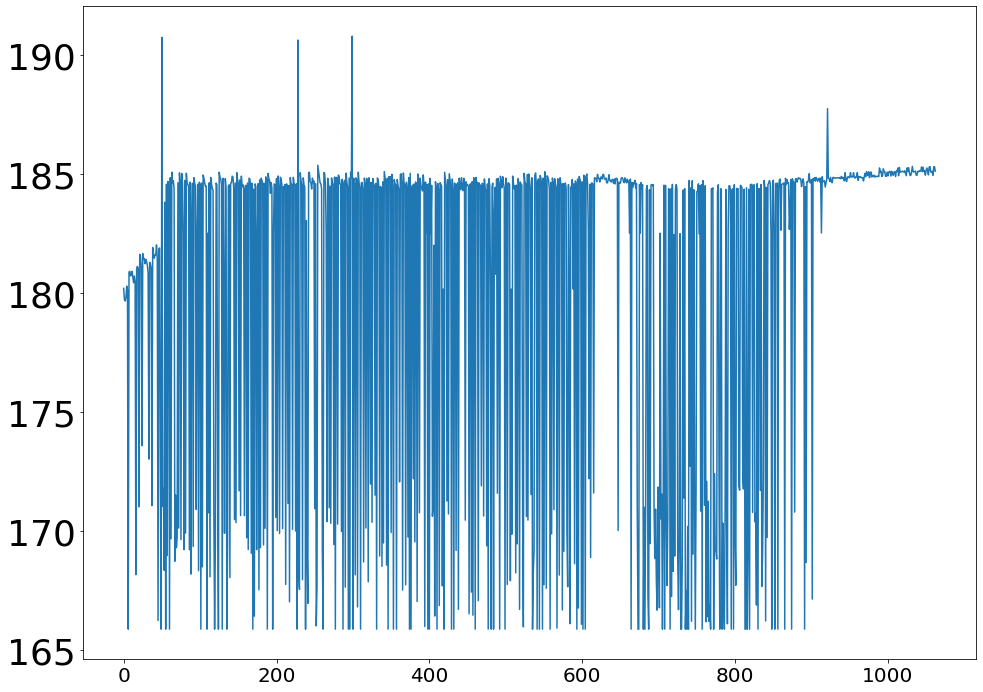

In [96]:
plt.plot(height)

In [135]:
img1=data[825][650:700,550:700]
img2=data[925][650:700,550:700]
from skimage.filters import window
img3= img1 * window('blackman', img1.shape)
shift, error, diffphase = phase_cross_correlation(img3,img2,upsample_factor=100)
print(shift)

[ 8.27 59.07]


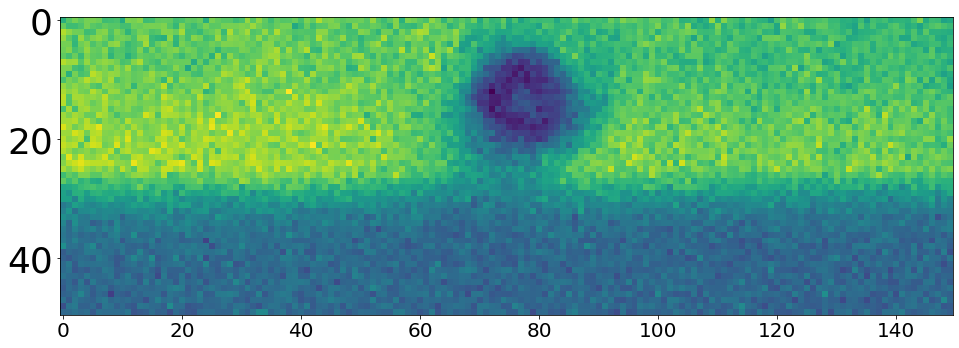

In [138]:
plt.imshow(img2)

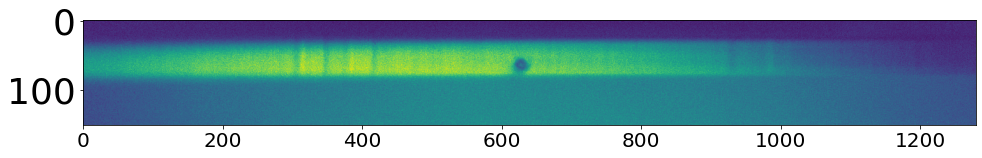

In [109]:
plt.imshow(data[925][600:750])